Dieses Notebook wird verwendet, um einen eigenständigen Bildklassifikator zu trainieren und anzuwenden. Auf Google Colab mit GPU-Unterstützung durchgeführt. 

<a href="https://colab.research.google.com/github/MichaelSeitz98/seminararbeit_review_detection/blob/main/real_fake_image_detector_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import urllib
import os
from fastai.vision.all import *
from fastdownload import download_url

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
%cd /content/drive/MyDrive/review_detecion

/content/drive/MyDrive/review_detecion


In [11]:
path = Path('/content/drive/MyDrive/review_detecion/train')
fns = get_image_files(path)
fns

(#2815) [Path('/content/drive/MyDrive/review_detecion/train/real/AF1QipPOmurB7xz78PNUHlx7lnkbK8veQwqfwzEgbnNN=w256-h256-p-k-no.png'),Path('/content/drive/MyDrive/review_detecion/train/real/AF1QipOHKBHKX3zDwh0LV16NmxOHRVqb3QHw8GQI5xN2=w256-h256-p-k-no.png'),Path('/content/drive/MyDrive/review_detecion/train/real/AF1QipMML4tDxTAmq6DsE4jshkD8xXgeX7LJEs-Gjojo=w256-h256-p-k-no.png'),Path('/content/drive/MyDrive/review_detecion/train/real/AF1QipMbledj2GyQl4t3aAuqS9vNaGUENmotFeaCA5y1=w256-h256-p-k-no.png'),Path('/content/drive/MyDrive/review_detecion/train/real/AF1QipOIrvXO63BYbOExa1rpr-yg86qF15b1ZArL6Gwb=w256-h256-p-k-no.png'),Path('/content/drive/MyDrive/review_detecion/train/real/AF1QipM74Y9LFDhFkdB80lToiKw_DhJF_D3N6rqblmDv=w256-h256-p-k-no.png'),Path('/content/drive/MyDrive/review_detecion/train/real/AF1QipPTQwsPxeStzxgQcLatnnn48lHBhqPH1SzF_EZ5=w256-h256-p-k-no.png'),Path('/content/drive/MyDrive/review_detecion/train/real/AF1QipPXRnFGHrtMD3roBVWuijMiHU_WoUWl5FLudb9a=w256-h256-p-k-no.png')

In [12]:
failed = verify_images(fns)
print(failed)
if len(failed) > 0:
    failed.map(Path.unlink);
else:
    print("All images verified successfully.")

[]
All images verified successfully.


In [ ]:
classes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.20, seed=42),
    get_y=parent_label,
    item_tfms=Resize(256))

print("Done with creating DataBlock.")

Done with creating DataBlock.


Train items: 2252
Valid items: 563


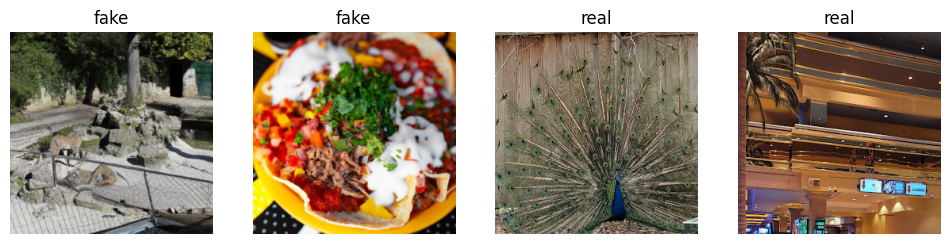

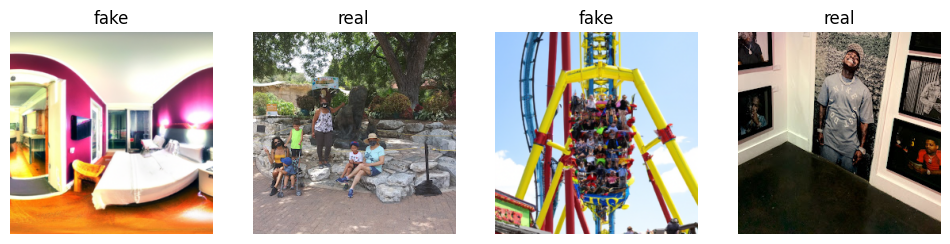

In [ ]:
dls = classes.dataloaders(path)

print(f"Train items: {len(dls.train.items)}")
print(f"Valid items: {len(dls.valid.items)}")
dls.train.show_batch(max_n=4, nrows=1)
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
classes = classes.new(item_tfms=Resize(256, ResizeMethod.Squish))
dls = classes.dataloaders(path)

classes = classes.new(
    item_tfms=RandomResizedCrop(256, min_scale=0.5),
    batch_tfms=aug_transforms())

In [ ]:
dls = classes.dataloaders(path)
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(epochs = 6, freeze_epochs=1)


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(2,2), dpi=60)
plt.savefig('imgclass_train_url12_cmatrix.svg', format='svg', dpi=1200)

Die Bilder mit den schlechtesten loss Werte.


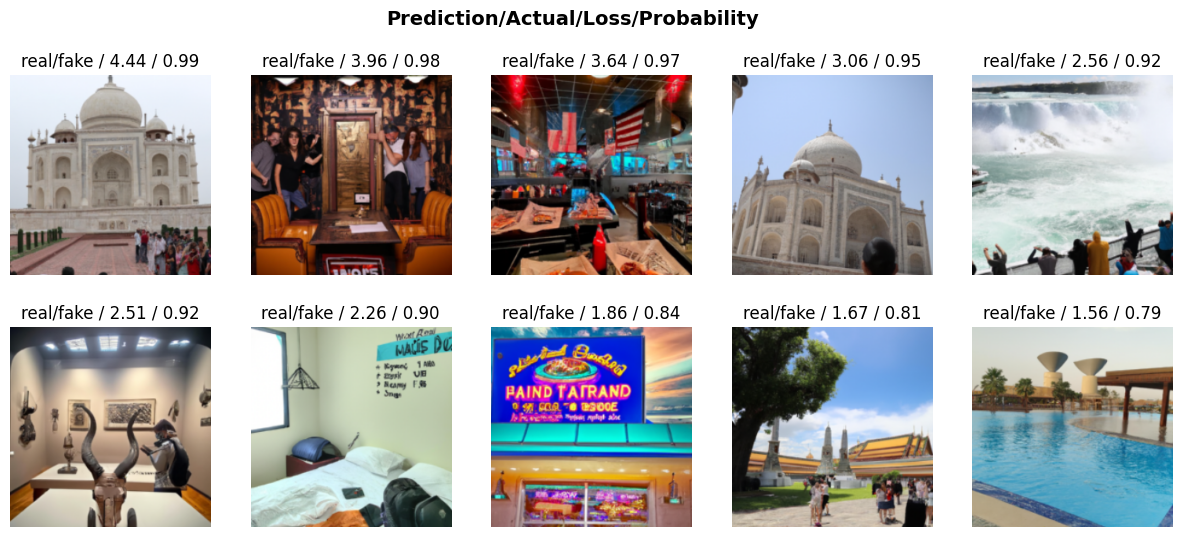

In [ ]:
print("Die Bilder mit den schlechtesten loss Werte.")
interp.plot_top_losses(10, nrows=2)

In [ ]:
learn.export("img_classif_trained_reviewUrl12.pkl")

In [ ]:
path.ls?

# Ab hier die Inferenzanwendung des Trainierten Models

In [16]:
path = Path("/content/drive/MyDrive/review_detecion")
path.ls(file_exts='.pkl')


Model saved


In [21]:
learn_inf = load_learner('/content/drive/MyDrive/review_detecion/img_classif_trained_reviewUrl12.pkl')

In [27]:
df = pd.read_csv('/content/drive/MyDrive/review_detecion/base_fake_real.csv')

In [48]:
for index, row in df.iterrows():
    print(f"Predicting for {index}...")
    if not pd.isna(row[f'reviewImageUrls/0']):
        url = row[f'reviewImageUrls/0']

        # download the image from that url and store it in a temp folder
        filename = f"{url.split('/')[-1]}.png"
        path = os.path.join('/content/drive/MyDrive/review_detecion/train/temp',filename)
        if not os.path.exists(path):
            try:
                urllib.request.urlretrieve(url, path)
            except:
                print(f'Error with {url}')
        prediction = learn_inf.predict(path)
        print(prediction)
        # Get the scores as a NumPy array
        scores_np = prediction[2].numpy()

        # Convert the scores array to a string
        scores_str = scores_np.tostring()
        # Get the scores as a NumPy array
        scores_np = prediction[2].numpy()

        # Convert the scores array to a list, then to a string
        scores_str = str(scores_np.tolist())
        print(scores_str)
        print(f'Label: {prediction[0]}')
        print(f'Score: {prediction[2]}')
        df.loc[index, f'prediction_0'] = prediction[0]
        df.loc[index,'predicion_0_prob'] = scores_str

Predicting for 0...


('real', tensor(1), tensor([0.3921, 0.6079]))
[0.3921307623386383, 0.6078692078590393]
Label: real
Score: tensor([0.3921, 0.6079])
Predicting for 1...


<ipython-input-48-098a0c500ce9>:20: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  scores_str = scores_np.tostring()


('real', tensor(1), tensor([0.0482, 0.9518]))
[0.048152320086956024, 0.9518476724624634]
Label: real
Score: tensor([0.0482, 0.9518])
Predicting for 2...


('real', tensor(1), tensor([0.1355, 0.8645]))
[0.13545702397823334, 0.8645430207252502]
Label: real
Score: tensor([0.1355, 0.8645])
Predicting for 3...


('real', tensor(1), tensor([0.3884, 0.6116]))
[0.38839298486709595, 0.6116069555282593]
Label: real
Score: tensor([0.3884, 0.6116])
Predicting for 4...


('fake', tensor(0), tensor([0.9989, 0.0011]))
[0.9989257454872131, 0.0010741997975856066]
Label: fake
Score: tensor([0.9989, 0.0011])
Predicting for 5...


('fake', tensor(0), tensor([0.9621, 0.0379]))
[0.962135910987854, 0.037864066660404205]
Label: fake
Score: tensor([0.9621, 0.0379])
Predicting for 6...


('fake', tensor(0), tensor([9.9997e-01, 3.1038e-05]))
[0.9999690055847168, 3.103812559857033e-05]
Label: fake
Score: tensor([9.9997e-01, 3.1038e-05])
Predicting for 7...


('real', tensor(1), tensor([0.1532, 0.8468]))
[0.1531582474708557, 0.8468417525291443]
Label: real
Score: tensor([0.1532, 0.8468])
Predicting for 8...


('fake', tensor(0), tensor([0.9951, 0.0049]))
[0.9951308965682983, 0.00486916396766901]
Label: fake
Score: tensor([0.9951, 0.0049])
Predicting for 9...


('fake', tensor(0), tensor([0.9914, 0.0086]))
[0.9913636445999146, 0.00863631535321474]
Label: fake
Score: tensor([0.9914, 0.0086])
Predicting for 10...


('fake', tensor(0), tensor([0.9988, 0.0012]))
[0.9988079071044922, 0.001192083116620779]
Label: fake
Score: tensor([0.9988, 0.0012])
Predicting for 11...


('fake', tensor(0), tensor([0.9512, 0.0488]))
[0.951167106628418, 0.04883292689919472]
Label: fake
Score: tensor([0.9512, 0.0488])
Predicting for 12...


('fake', tensor(0), tensor([0.9983, 0.0017]))
[0.9983356595039368, 0.001664370414800942]
Label: fake
Score: tensor([0.9983, 0.0017])
Predicting for 13...


('fake', tensor(0), tensor([9.9999e-01, 6.1835e-06]))
[0.9999938011169434, 6.18354715697933e-06]
Label: fake
Score: tensor([9.9999e-01, 6.1835e-06])
Predicting for 14...


('fake', tensor(0), tensor([9.9996e-01, 4.2236e-05]))
[0.999957799911499, 4.223617725074291e-05]
Label: fake
Score: tensor([9.9996e-01, 4.2236e-05])
Predicting for 15...


('fake', tensor(0), tensor([1.0000e+00, 1.3550e-07]))
[0.9999998807907104, 1.3550054234201525e-07]
Label: fake
Score: tensor([1.0000e+00, 1.3550e-07])
Predicting for 16...


('fake', tensor(0), tensor([0.9945, 0.0055]))
[0.9945446252822876, 0.0054554264061152935]
Label: fake
Score: tensor([0.9945, 0.0055])
Predicting for 17...


('fake', tensor(0), tensor([0.9563, 0.0437]))
[0.9562839865684509, 0.04371604323387146]
Label: fake
Score: tensor([0.9563, 0.0437])
Predicting for 18...


('fake', tensor(0), tensor([9.9999e-01, 1.1397e-05]))
[0.9999885559082031, 1.139683990913909e-05]
Label: fake
Score: tensor([9.9999e-01, 1.1397e-05])
Predicting for 19...


('fake', tensor(0), tensor([9.9961e-01, 3.8993e-04]))
[0.9996101260185242, 0.0003899332950823009]
Label: fake
Score: tensor([9.9961e-01, 3.8993e-04])
Predicting for 20...


('fake', tensor(0), tensor([9.9999e-01, 6.4265e-06]))
[0.9999935626983643, 6.42647364657023e-06]
Label: fake
Score: tensor([9.9999e-01, 6.4265e-06])
Predicting for 21...


('fake', tensor(0), tensor([0.9140, 0.0860]))
[0.9140331745147705, 0.08596684038639069]
Label: fake
Score: tensor([0.9140, 0.0860])
Predicting for 22...


('fake', tensor(0), tensor([1.0000e+00, 1.2195e-07]))
[0.9999998807907104, 1.219520555650888e-07]
Label: fake
Score: tensor([1.0000e+00, 1.2195e-07])
Predicting for 23...


('fake', tensor(0), tensor([9.9987e-01, 1.2898e-04]))
[0.999871015548706, 0.00012898461136501282]
Label: fake
Score: tensor([9.9987e-01, 1.2898e-04])
Predicting for 24...


('fake', tensor(0), tensor([0.9858, 0.0142]))
[0.9857611060142517, 0.01423892192542553]
Label: fake
Score: tensor([0.9858, 0.0142])
Predicting for 25...


('fake', tensor(0), tensor([0.8748, 0.1252]))
[0.874769926071167, 0.1252300888299942]
Label: fake
Score: tensor([0.8748, 0.1252])
Predicting for 26...


('real', tensor(1), tensor([0.3017, 0.6983]))
[0.3017362952232361, 0.6982636451721191]
Label: real
Score: tensor([0.3017, 0.6983])
Predicting for 27...


('fake', tensor(0), tensor([9.9990e-01, 1.0099e-04]))
[0.9998990297317505, 0.00010099386418005452]
Label: fake
Score: tensor([9.9990e-01, 1.0099e-04])
Predicting for 28...


('fake', tensor(0), tensor([0.7957, 0.2043]))
[0.7957075238227844, 0.20429249107837677]
Label: fake
Score: tensor([0.7957, 0.2043])
Predicting for 29...


('fake', tensor(0), tensor([9.9982e-01, 1.8259e-04]))
[0.999817430973053, 0.00018258531054016203]
Label: fake
Score: tensor([9.9982e-01, 1.8259e-04])
Predicting for 30...


('fake', tensor(0), tensor([1.0000e+00, 6.5909e-07]))
[0.9999992847442627, 6.590852308363537e-07]
Label: fake
Score: tensor([1.0000e+00, 6.5909e-07])
Predicting for 31...


('fake', tensor(0), tensor([1.0000e+00, 1.3279e-08]))
[1.0, 1.3279214172712273e-08]
Label: fake
Score: tensor([1.0000e+00, 1.3279e-08])
Predicting for 32...


('fake', tensor(0), tensor([9.9967e-01, 3.3353e-04]))
[0.9996664524078369, 0.00033352826721966267]
Label: fake
Score: tensor([9.9967e-01, 3.3353e-04])
Predicting for 33...


('fake', tensor(0), tensor([1.0000e+00, 2.9149e-07]))
[0.9999997615814209, 2.914889591920655e-07]
Label: fake
Score: tensor([1.0000e+00, 2.9149e-07])
Predicting for 34...


('fake', tensor(0), tensor([1.0000e+00, 6.8209e-08]))
[0.9999998807907104, 6.820865650070118e-08]
Label: fake
Score: tensor([1.0000e+00, 6.8209e-08])
Predicting for 35...


('fake', tensor(0), tensor([0.9934, 0.0066]))
[0.993415355682373, 0.006584632210433483]
Label: fake
Score: tensor([0.9934, 0.0066])
Predicting for 36...


('fake', tensor(0), tensor([0.9990, 0.0010]))
[0.9989989399909973, 0.0010010545374825597]
Label: fake
Score: tensor([0.9990, 0.0010])
Predicting for 37...


('fake', tensor(0), tensor([1.0000e+00, 3.7018e-06]))
[0.9999963045120239, 3.7017985050624702e-06]
Label: fake
Score: tensor([1.0000e+00, 3.7018e-06])
Predicting for 38...


('fake', tensor(0), tensor([1.0000e+00, 1.3285e-09]))
[1.0, 1.3284678912484083e-09]
Label: fake
Score: tensor([1.0000e+00, 1.3285e-09])
Predicting for 39...


('fake', tensor(0), tensor([0.9985, 0.0015]))
[0.9985440969467163, 0.0014559660339727998]
Label: fake
Score: tensor([0.9985, 0.0015])
Predicting for 40...


('fake', tensor(0), tensor([9.9999e-01, 6.0529e-06]))
[0.9999939203262329, 6.0529114307428245e-06]
Label: fake
Score: tensor([9.9999e-01, 6.0529e-06])
Predicting for 41...


('fake', tensor(0), tensor([0.9972, 0.0028]))
[0.9971879124641418, 0.0028120458591729403]
Label: fake
Score: tensor([0.9972, 0.0028])
Predicting for 42...


('fake', tensor(0), tensor([9.9954e-01, 4.6091e-04]))
[0.9995391368865967, 0.0004609140451066196]
Label: fake
Score: tensor([9.9954e-01, 4.6091e-04])
Predicting for 43...


('fake', tensor(0), tensor([1.0000e+00, 5.7121e-07]))
[0.9999994039535522, 5.712056463380577e-07]
Label: fake
Score: tensor([1.0000e+00, 5.7121e-07])
Predicting for 44...


('fake', tensor(0), tensor([0.9988, 0.0012]))
[0.9987816214561462, 0.0012183383805677295]
Label: fake
Score: tensor([0.9988, 0.0012])
Predicting for 45...


('fake', tensor(0), tensor([0.9039, 0.0961]))
[0.9038884043693542, 0.09611159563064575]
Label: fake
Score: tensor([0.9039, 0.0961])
Predicting for 46...


('fake', tensor(0), tensor([1.0000e+00, 1.0136e-06]))
[0.999998927116394, 1.0136106993741123e-06]
Label: fake
Score: tensor([1.0000e+00, 1.0136e-06])
Predicting for 47...


('fake', tensor(0), tensor([9.9911e-01, 8.9374e-04]))
[0.999106228351593, 0.000893737596925348]
Label: fake
Score: tensor([9.9911e-01, 8.9374e-04])
Predicting for 48...


('fake', tensor(0), tensor([1.0000e+00, 9.8898e-07]))
[0.9999990463256836, 9.889774901239434e-07]
Label: fake
Score: tensor([1.0000e+00, 9.8898e-07])
Predicting for 49...


('fake', tensor(0), tensor([1.0000e+00, 9.9003e-07]))
[0.9999990463256836, 9.90032503978e-07]
Label: fake
Score: tensor([1.0000e+00, 9.9003e-07])
Predicting for 50...


('fake', tensor(0), tensor([0.9888, 0.0112]))
[0.9887667298316956, 0.011233210563659668]
Label: fake
Score: tensor([0.9888, 0.0112])
Predicting for 51...


('real', tensor(1), tensor([0.2859, 0.7141]))
[0.2858954071998596, 0.7141045928001404]
Label: real
Score: tensor([0.2859, 0.7141])
Predicting for 52...


('fake', tensor(0), tensor([0.9989, 0.0011]))
[0.998852014541626, 0.001147997914813459]
Label: fake
Score: tensor([0.9989, 0.0011])
Predicting for 53...


('fake', tensor(0), tensor([1.0000e+00, 3.5068e-07]))
[0.9999996423721313, 3.50679158600542e-07]
Label: fake
Score: tensor([1.0000e+00, 3.5068e-07])
Predicting for 54...


('fake', tensor(0), tensor([0.9912, 0.0088]))
[0.9912201762199402, 0.008779886178672314]
Label: fake
Score: tensor([0.9912, 0.0088])
Predicting for 55...


('fake', tensor(0), tensor([0.8489, 0.1511]))
[0.8489484190940857, 0.1510515958070755]
Label: fake
Score: tensor([0.8489, 0.1511])
Predicting for 56...


('fake', tensor(0), tensor([1.0000e+00, 6.0021e-13]))
[1.0, 6.002112327117837e-13]
Label: fake
Score: tensor([1.0000e+00, 6.0021e-13])
Predicting for 57...


('fake', tensor(0), tensor([9.9989e-01, 1.0892e-04]))
[0.9998910427093506, 0.00010892266436712816]
Label: fake
Score: tensor([9.9989e-01, 1.0892e-04])
Predicting for 58...


('fake', tensor(0), tensor([9.9997e-01, 3.2630e-05]))
[0.9999673366546631, 3.263027247157879e-05]
Label: fake
Score: tensor([9.9997e-01, 3.2630e-05])
Predicting for 59...


('fake', tensor(0), tensor([0.9923, 0.0077]))
[0.9922877550125122, 0.007712306454777718]
Label: fake
Score: tensor([0.9923, 0.0077])
Predicting for 60...


('fake', tensor(0), tensor([9.9997e-01, 3.3148e-05]))
[0.9999668598175049, 3.314755667815916e-05]
Label: fake
Score: tensor([9.9997e-01, 3.3148e-05])
Predicting for 61...


('fake', tensor(0), tensor([9.9998e-01, 2.3773e-05]))
[0.9999762773513794, 2.3772861823090352e-05]
Label: fake
Score: tensor([9.9998e-01, 2.3773e-05])
Predicting for 62...


('fake', tensor(0), tensor([0.9945, 0.0055]))
[0.9945343732833862, 0.005465571768581867]
Label: fake
Score: tensor([0.9945, 0.0055])
Predicting for 63...


('fake', tensor(0), tensor([1.0000e+00, 1.2342e-06]))
[0.9999988079071045, 1.2341530464254902e-06]
Label: fake
Score: tensor([1.0000e+00, 1.2342e-06])
Predicting for 64...


('fake', tensor(0), tensor([9.9930e-01, 7.0020e-04]))
[0.9992997646331787, 0.0007002027705311775]
Label: fake
Score: tensor([9.9930e-01, 7.0020e-04])
Predicting for 65...


('fake', tensor(0), tensor([1.0000e+00, 1.4133e-07]))
[0.9999998807907104, 1.4132905334918178e-07]
Label: fake
Score: tensor([1.0000e+00, 1.4133e-07])
Predicting for 66...


('fake', tensor(0), tensor([1.0000e+00, 3.0434e-07]))
[0.9999996423721313, 3.04337874013072e-07]
Label: fake
Score: tensor([1.0000e+00, 3.0434e-07])
Predicting for 67...


('fake', tensor(0), tensor([9.9999e-01, 1.0978e-05]))
[0.9999890327453613, 1.097813765227329e-05]
Label: fake
Score: tensor([9.9999e-01, 1.0978e-05])
Predicting for 68...


('fake', tensor(0), tensor([9.9988e-01, 1.1791e-04]))
[0.9998821020126343, 0.00011790840653702617]
Label: fake
Score: tensor([9.9988e-01, 1.1791e-04])
Predicting for 69...


('fake', tensor(0), tensor([1.0000e+00, 2.2008e-06]))
[0.9999978542327881, 2.2007639017829206e-06]
Label: fake
Score: tensor([1.0000e+00, 2.2008e-06])
Predicting for 70...


('fake', tensor(0), tensor([0.9372, 0.0628]))
[0.9372276067733765, 0.06277240067720413]
Label: fake
Score: tensor([0.9372, 0.0628])
Predicting for 71...


('fake', tensor(0), tensor([1.0000e+00, 2.6725e-08]))
[1.0, 2.6724858770421633e-08]
Label: fake
Score: tensor([1.0000e+00, 2.6725e-08])
Predicting for 72...


('fake', tensor(0), tensor([0.9876, 0.0124]))
[0.9875645041465759, 0.012435492128133774]
Label: fake
Score: tensor([0.9876, 0.0124])
Predicting for 73...


('fake', tensor(0), tensor([1.0000e+00, 1.3310e-08]))
[1.0, 1.3310429203272633e-08]
Label: fake
Score: tensor([1.0000e+00, 1.3310e-08])
Predicting for 74...


('fake', tensor(0), tensor([1.0000e+00, 1.4585e-07]))
[0.9999998807907104, 1.458537042253738e-07]
Label: fake
Score: tensor([1.0000e+00, 1.4585e-07])
Predicting for 75...


('fake', tensor(0), tensor([1.0000e+00, 5.3941e-08]))
[1.0, 5.3940823363518575e-08]
Label: fake
Score: tensor([1.0000e+00, 5.3941e-08])
Predicting for 76...


('fake', tensor(0), tensor([0.9972, 0.0028]))
[0.9971809387207031, 0.0028190959710627794]
Label: fake
Score: tensor([0.9972, 0.0028])
Predicting for 77...


('fake', tensor(0), tensor([1.0000e+00, 5.7266e-09]))
[1.0, 5.726600971200924e-09]
Label: fake
Score: tensor([1.0000e+00, 5.7266e-09])
Predicting for 78...


('fake', tensor(0), tensor([1.0000e+00, 1.9454e-08]))
[1.0, 1.9454118316275526e-08]
Label: fake
Score: tensor([1.0000e+00, 1.9454e-08])
Predicting for 79...


('fake', tensor(0), tensor([0.9982, 0.0018]))
[0.9982389211654663, 0.0017611143412068486]
Label: fake
Score: tensor([0.9982, 0.0018])
Predicting for 80...


('fake', tensor(0), tensor([9.9921e-01, 7.9159e-04]))
[0.999208390712738, 0.0007915926398709416]
Label: fake
Score: tensor([9.9921e-01, 7.9159e-04])
Predicting for 81...


('fake', tensor(0), tensor([0.9962, 0.0038]))
[0.9962175488471985, 0.003782495390623808]
Label: fake
Score: tensor([0.9962, 0.0038])
Predicting for 82...


('fake', tensor(0), tensor([9.9928e-01, 7.2065e-04]))
[0.9992793202400208, 0.0007206532754935324]
Label: fake
Score: tensor([9.9928e-01, 7.2065e-04])
Predicting for 83...


('fake', tensor(0), tensor([1.0000e+00, 8.8980e-08]))
[0.9999998807907104, 8.897952596953473e-08]
Label: fake
Score: tensor([1.0000e+00, 8.8980e-08])
Predicting for 84...


('fake', tensor(0), tensor([0.9928, 0.0072]))
[0.992819607257843, 0.007180402986705303]
Label: fake
Score: tensor([0.9928, 0.0072])
Predicting for 85...


('fake', tensor(0), tensor([0.9945, 0.0055]))
[0.994464099407196, 0.0055358922109007835]
Label: fake
Score: tensor([0.9945, 0.0055])
Predicting for 86...


('fake', tensor(0), tensor([1.0000e+00, 1.0801e-06]))
[0.999998927116394, 1.0801464895848767e-06]
Label: fake
Score: tensor([1.0000e+00, 1.0801e-06])
Predicting for 87...


('fake', tensor(0), tensor([9.9917e-01, 8.2784e-04]))
[0.9991722106933594, 0.0008278384921140969]
Label: fake
Score: tensor([9.9917e-01, 8.2784e-04])
Predicting for 88...


('fake', tensor(0), tensor([9.9998e-01, 1.5197e-05]))
[0.999984860420227, 1.5197243556031026e-05]
Label: fake
Score: tensor([9.9998e-01, 1.5197e-05])
Predicting for 89...


('fake', tensor(0), tensor([1.0000e+00, 1.6343e-08]))
[1.0, 1.6343248532280086e-08]
Label: fake
Score: tensor([1.0000e+00, 1.6343e-08])
Predicting for 90...


('fake', tensor(0), tensor([9.9979e-01, 2.1270e-04]))
[0.9997872710227966, 0.00021269539138302207]
Label: fake
Score: tensor([9.9979e-01, 2.1270e-04])
Predicting for 91...


('fake', tensor(0), tensor([9.9990e-01, 1.0228e-04]))
[0.9998977184295654, 0.00010227703023701906]
Label: fake
Score: tensor([9.9990e-01, 1.0228e-04])
Predicting for 92...


('fake', tensor(0), tensor([0.9981, 0.0019]))
[0.9981497526168823, 0.0018502948805689812]
Label: fake
Score: tensor([0.9981, 0.0019])
Predicting for 93...


('fake', tensor(0), tensor([9.9999e-01, 8.2862e-06]))
[0.9999916553497314, 8.286240699817427e-06]
Label: fake
Score: tensor([9.9999e-01, 8.2862e-06])
Predicting for 94...


('fake', tensor(0), tensor([9.9965e-01, 3.5039e-04]))
[0.9996496438980103, 0.00035038500209338963]
Label: fake
Score: tensor([9.9965e-01, 3.5039e-04])
Predicting for 95...


('real', tensor(1), tensor([0.2734, 0.7266]))
[0.2734425365924835, 0.7265574932098389]
Label: real
Score: tensor([0.2734, 0.7266])
Predicting for 96...


('fake', tensor(0), tensor([0.9979, 0.0021]))
[0.9979224801063538, 0.0020775385200977325]
Label: fake
Score: tensor([0.9979, 0.0021])
Predicting for 97...


('real', tensor(1), tensor([0.0038, 0.9962]))
[0.0038267155177891254, 0.9961733222007751]
Label: real
Score: tensor([0.0038, 0.9962])
Predicting for 98...


('fake', tensor(0), tensor([9.9988e-01, 1.1820e-04]))
[0.9998817443847656, 0.00011819883366115391]
Label: fake
Score: tensor([9.9988e-01, 1.1820e-04])
Predicting for 99...


('real', tensor(1), tensor([0.4953, 0.5047]))
[0.49528348445892334, 0.5047164559364319]
Label: real
Score: tensor([0.4953, 0.5047])
Predicting for 100...


('fake', tensor(0), tensor([0.9990, 0.0010]))
[0.9989804625511169, 0.0010195226641371846]
Label: fake
Score: tensor([0.9990, 0.0010])
Predicting for 101...


('fake', tensor(0), tensor([0.8918, 0.1082]))
[0.8917511701583862, 0.10824882239103317]
Label: fake
Score: tensor([0.8918, 0.1082])
Predicting for 102...


('fake', tensor(0), tensor([0.8882, 0.1118]))
[0.8881596326828003, 0.1118403971195221]
Label: fake
Score: tensor([0.8882, 0.1118])
Predicting for 103...


('fake', tensor(0), tensor([0.9889, 0.0111]))
[0.9889364838600159, 0.011063570156693459]
Label: fake
Score: tensor([0.9889, 0.0111])
Predicting for 104...


('fake', tensor(0), tensor([9.9999e-01, 9.6417e-06]))
[0.9999903440475464, 9.641712495067623e-06]
Label: fake
Score: tensor([9.9999e-01, 9.6417e-06])
Predicting for 105...


('fake', tensor(0), tensor([0.9275, 0.0725]))
[0.927461564540863, 0.07253848016262054]
Label: fake
Score: tensor([0.9275, 0.0725])
Predicting for 106...


('real', tensor(1), tensor([0.3581, 0.6419]))
[0.35807639360427856, 0.6419236063957214]
Label: real
Score: tensor([0.3581, 0.6419])
Predicting for 107...


('real', tensor(1), tensor([0.2792, 0.7208]))
[0.2791517674922943, 0.7208482623100281]
Label: real
Score: tensor([0.2792, 0.7208])
Predicting for 108...


('fake', tensor(0), tensor([0.9961, 0.0039]))
[0.9960867166519165, 0.00391330337151885]
Label: fake
Score: tensor([0.9961, 0.0039])
Predicting for 109...


('fake', tensor(0), tensor([0.9774, 0.0226]))
[0.9774318933486938, 0.02256813831627369]
Label: fake
Score: tensor([0.9774, 0.0226])
Predicting for 110...


('fake', tensor(0), tensor([0.6316, 0.3684]))
[0.6315721273422241, 0.3684278726577759]
Label: fake
Score: tensor([0.6316, 0.3684])
Predicting for 111...


('fake', tensor(0), tensor([0.9861, 0.0139]))
[0.9861419796943665, 0.013858016580343246]
Label: fake
Score: tensor([0.9861, 0.0139])
Predicting for 112...


('fake', tensor(0), tensor([1.0000e+00, 2.7511e-06]))
[0.9999972581863403, 2.751079364315956e-06]
Label: fake
Score: tensor([1.0000e+00, 2.7511e-06])
Predicting for 113...


('fake', tensor(0), tensor([1.0000e+00, 4.0735e-09]))
[1.0, 4.073544612737123e-09]
Label: fake
Score: tensor([1.0000e+00, 4.0735e-09])
Predicting for 114...


('fake', tensor(0), tensor([9.9989e-01, 1.1130e-04]))
[0.9998886585235596, 0.00011130420170957223]
Label: fake
Score: tensor([9.9989e-01, 1.1130e-04])
Predicting for 115...


('fake', tensor(0), tensor([0.9987, 0.0013]))
[0.9986795783042908, 0.0013204531278461218]
Label: fake
Score: tensor([0.9987, 0.0013])
Predicting for 116...


('fake', tensor(0), tensor([1.0000e+00, 5.4017e-07]))
[0.9999994039535522, 5.401731186793768e-07]
Label: fake
Score: tensor([1.0000e+00, 5.4017e-07])
Predicting for 117...


('fake', tensor(0), tensor([1.0000e+00, 2.8863e-07]))
[0.9999997615814209, 2.8863419743174745e-07]
Label: fake
Score: tensor([1.0000e+00, 2.8863e-07])
Predicting for 118...


('real', tensor(1), tensor([0.4268, 0.5732]))
[0.4267804026603699, 0.5732195973396301]
Label: real
Score: tensor([0.4268, 0.5732])
Predicting for 119...


('fake', tensor(0), tensor([1.0000e+00, 2.4569e-06]))
[0.9999974966049194, 2.456866695865756e-06]
Label: fake
Score: tensor([1.0000e+00, 2.4569e-06])
Predicting for 120...


('fake', tensor(0), tensor([9.9999e-01, 9.1412e-06]))
[0.9999908208847046, 9.141208465734962e-06]
Label: fake
Score: tensor([9.9999e-01, 9.1412e-06])
Predicting for 121...


('fake', tensor(0), tensor([9.9939e-01, 6.0785e-04]))
[0.9993921518325806, 0.0006078470614738762]
Label: fake
Score: tensor([9.9939e-01, 6.0785e-04])
Predicting for 122...


('fake', tensor(0), tensor([1.0000e+00, 2.6455e-07]))
[0.9999997615814209, 2.645546146595734e-07]
Label: fake
Score: tensor([1.0000e+00, 2.6455e-07])
Predicting for 123...


('fake', tensor(0), tensor([9.9997e-01, 3.3187e-05]))
[0.9999668598175049, 3.31867158820387e-05]
Label: fake
Score: tensor([9.9997e-01, 3.3187e-05])
Predicting for 124...


('fake', tensor(0), tensor([1.0000e+00, 5.1374e-08]))
[1.0, 5.137417957712387e-08]
Label: fake
Score: tensor([1.0000e+00, 5.1374e-08])
Predicting for 125...


('fake', tensor(0), tensor([1.0000e+00, 1.3147e-07]))
[0.9999998807907104, 1.314744935143608e-07]
Label: fake
Score: tensor([1.0000e+00, 1.3147e-07])
Predicting for 126...


('fake', tensor(0), tensor([0.9826, 0.0174]))
[0.9826206564903259, 0.01737936958670616]
Label: fake
Score: tensor([0.9826, 0.0174])
Predicting for 127...


('fake', tensor(0), tensor([9.9999e-01, 1.0314e-05]))
[0.9999896287918091, 1.0313857274013571e-05]
Label: fake
Score: tensor([9.9999e-01, 1.0314e-05])
Predicting for 128...


('fake', tensor(0), tensor([0.9958, 0.0042]))
[0.9958130717277527, 0.004186889622360468]
Label: fake
Score: tensor([0.9958, 0.0042])
Predicting for 129...


('fake', tensor(0), tensor([1.0000e+00, 1.8641e-07]))
[0.9999997615814209, 1.8640636767486285e-07]
Label: fake
Score: tensor([1.0000e+00, 1.8641e-07])
Predicting for 130...


('fake', tensor(0), tensor([9.9998e-01, 1.6672e-05]))
[0.9999833106994629, 1.6671821867930703e-05]
Label: fake
Score: tensor([9.9998e-01, 1.6672e-05])
Predicting for 131...


('fake', tensor(0), tensor([9.9971e-01, 2.9074e-04]))
[0.9997091889381409, 0.0002907395828515291]
Label: fake
Score: tensor([9.9971e-01, 2.9074e-04])
Predicting for 132...


('fake', tensor(0), tensor([1.0000e+00, 4.4673e-08]))
[1.0, 4.4672901822195854e-08]
Label: fake
Score: tensor([1.0000e+00, 4.4673e-08])
Predicting for 133...


('fake', tensor(0), tensor([9.9906e-01, 9.4166e-04]))
[0.9990583062171936, 0.0009416648535989225]
Label: fake
Score: tensor([9.9906e-01, 9.4166e-04])
Predicting for 134...


('fake', tensor(0), tensor([9.9997e-01, 2.6333e-05]))
[0.9999736547470093, 2.6332669222028926e-05]
Label: fake
Score: tensor([9.9997e-01, 2.6333e-05])
Predicting for 135...


('fake', tensor(0), tensor([1.0000e+00, 4.1622e-07]))
[0.9999996423721313, 4.1621549939918623e-07]
Label: fake
Score: tensor([1.0000e+00, 4.1622e-07])
Predicting for 136...


('fake', tensor(0), tensor([0.9804, 0.0196]))
[0.9804252982139587, 0.01957470178604126]
Label: fake
Score: tensor([0.9804, 0.0196])
Predicting for 137...


('fake', tensor(0), tensor([9.9982e-01, 1.7836e-04]))
[0.9998217225074768, 0.00017835735343396664]
Label: fake
Score: tensor([9.9982e-01, 1.7836e-04])
Predicting for 138...


('fake', tensor(0), tensor([9.9999e-01, 5.1570e-06]))
[0.9999948740005493, 5.15700276082498e-06]
Label: fake
Score: tensor([9.9999e-01, 5.1570e-06])
Predicting for 139...


('fake', tensor(0), tensor([1.0000e+00, 3.3763e-07]))
[0.9999996423721313, 3.376284212208702e-07]
Label: fake
Score: tensor([1.0000e+00, 3.3763e-07])
Predicting for 140...


('fake', tensor(0), tensor([9.9964e-01, 3.5857e-04]))
[0.9996414184570312, 0.00035857115290127695]
Label: fake
Score: tensor([9.9964e-01, 3.5857e-04])
Predicting for 141...


('fake', tensor(0), tensor([0.9926, 0.0074]))
[0.9926261305809021, 0.007373901549726725]
Label: fake
Score: tensor([0.9926, 0.0074])
Predicting for 142...


('fake', tensor(0), tensor([1.0000e+00, 8.2424e-08]))
[0.9999998807907104, 8.242361815291588e-08]
Label: fake
Score: tensor([1.0000e+00, 8.2424e-08])
Predicting for 143...


('fake', tensor(0), tensor([1.0000e+00, 1.6959e-07]))
[0.9999998807907104, 1.6958743742634397e-07]
Label: fake
Score: tensor([1.0000e+00, 1.6959e-07])
Predicting for 144...


('fake', tensor(0), tensor([9.9987e-01, 1.2621e-04]))
[0.9998737573623657, 0.00012621302448678762]
Label: fake
Score: tensor([9.9987e-01, 1.2621e-04])
Predicting for 145...


('fake', tensor(0), tensor([0.9873, 0.0127]))
[0.9872511625289917, 0.01274886168539524]
Label: fake
Score: tensor([0.9873, 0.0127])
Predicting for 146...


('real', tensor(1), tensor([0.4047, 0.5953]))
[0.40467214584350586, 0.5953278541564941]
Label: real
Score: tensor([0.4047, 0.5953])
Predicting for 147...


('fake', tensor(0), tensor([9.9996e-01, 3.9675e-05]))
[0.9999603033065796, 3.967516022385098e-05]
Label: fake
Score: tensor([9.9996e-01, 3.9675e-05])
Predicting for 148...


('fake', tensor(0), tensor([9.9997e-01, 3.0106e-05]))
[0.9999698400497437, 3.0105591577012092e-05]
Label: fake
Score: tensor([9.9997e-01, 3.0106e-05])
Predicting for 149...


('real', tensor(1), tensor([5.9632e-04, 9.9940e-01]))
[0.0005963183357380331, 0.999403715133667]
Label: real
Score: tensor([5.9632e-04, 9.9940e-01])
Predicting for 150...


('fake', tensor(0), tensor([0.5159, 0.4841]))
[0.5158833861351013, 0.4841166138648987]
Label: fake
Score: tensor([0.5159, 0.4841])
Predicting for 151...


('real', tensor(1), tensor([0.0244, 0.9756]))
[0.024369362741708755, 0.9756306409835815]
Label: real
Score: tensor([0.0244, 0.9756])
Predicting for 152...


('fake', tensor(0), tensor([9.9991e-01, 8.6118e-05]))
[0.9999139308929443, 8.61176013131626e-05]
Label: fake
Score: tensor([9.9991e-01, 8.6118e-05])
Predicting for 153...


('fake', tensor(0), tensor([1.0000e+00, 2.7071e-07]))
[0.9999997615814209, 2.7071058639194234e-07]
Label: fake
Score: tensor([1.0000e+00, 2.7071e-07])
Predicting for 154...


('fake', tensor(0), tensor([0.9982, 0.0018]))
[0.9982463121414185, 0.0017536599189043045]
Label: fake
Score: tensor([0.9982, 0.0018])
Predicting for 155...


('fake', tensor(0), tensor([9.9980e-01, 1.9955e-04]))
[0.9998005032539368, 0.00019955173775088042]
Label: fake
Score: tensor([9.9980e-01, 1.9955e-04])
Predicting for 156...


('fake', tensor(0), tensor([1.0000e+00, 2.0988e-09]))
[1.0, 2.098833773445108e-09]
Label: fake
Score: tensor([1.0000e+00, 2.0988e-09])
Predicting for 157...


('fake', tensor(0), tensor([9.9999e-01, 1.4341e-05]))
[0.9999856948852539, 1.4341401765705086e-05]
Label: fake
Score: tensor([9.9999e-01, 1.4341e-05])
Predicting for 158...


('fake', tensor(0), tensor([9.9997e-01, 3.0043e-05]))
[0.9999699592590332, 3.0043443985050544e-05]
Label: fake
Score: tensor([9.9997e-01, 3.0043e-05])
Predicting for 159...


('fake', tensor(0), tensor([0.9821, 0.0179]))
[0.9820905327796936, 0.01790948584675789]
Label: fake
Score: tensor([0.9821, 0.0179])
Predicting for 160...


('fake', tensor(0), tensor([0.9968, 0.0032]))
[0.9968145489692688, 0.0031854272820055485]
Label: fake
Score: tensor([0.9968, 0.0032])
Predicting for 161...


('fake', tensor(0), tensor([1.0000e+00, 4.5559e-08]))
[1.0, 4.555938559747119e-08]
Label: fake
Score: tensor([1.0000e+00, 4.5559e-08])
Predicting for 162...


('fake', tensor(0), tensor([9.9950e-01, 5.0265e-04]))
[0.9994972944259644, 0.0005026540020480752]
Label: fake
Score: tensor([9.9950e-01, 5.0265e-04])
Predicting for 163...


('fake', tensor(0), tensor([1.0000e+00, 1.3094e-07]))
[0.9999998807907104, 1.3093881534587126e-07]
Label: fake
Score: tensor([1.0000e+00, 1.3094e-07])
Predicting for 164...


('fake', tensor(0), tensor([0.9970, 0.0030]))
[0.9970171451568604, 0.0029828245751559734]
Label: fake
Score: tensor([0.9970, 0.0030])
Predicting for 165...


('fake', tensor(0), tensor([9.9998e-01, 2.2484e-05]))
[0.9999774694442749, 2.2484293367597274e-05]
Label: fake
Score: tensor([9.9998e-01, 2.2484e-05])
Predicting for 166...


('fake', tensor(0), tensor([9.9999e-01, 1.3465e-05]))
[0.9999865293502808, 1.3464599760482088e-05]
Label: fake
Score: tensor([9.9999e-01, 1.3465e-05])
Predicting for 167...


('fake', tensor(0), tensor([1.0000e+00, 5.3420e-08]))
[1.0, 5.3419778822672015e-08]
Label: fake
Score: tensor([1.0000e+00, 5.3420e-08])
Predicting for 168...


('fake', tensor(0), tensor([0.9988, 0.0012]))
[0.9987921118736267, 0.0012079093139618635]
Label: fake
Score: tensor([0.9988, 0.0012])
Predicting for 169...


('fake', tensor(0), tensor([0.9759, 0.0241]))
[0.9758816957473755, 0.02411828003823757]
Label: fake
Score: tensor([0.9759, 0.0241])
Predicting for 170...


('fake', tensor(0), tensor([0.9971, 0.0029]))
[0.9970735311508179, 0.0029264939948916435]
Label: fake
Score: tensor([0.9971, 0.0029])
Predicting for 171...


('fake', tensor(0), tensor([1.0000e+00, 1.3634e-10]))
[1.0, 1.3634304796283914e-10]
Label: fake
Score: tensor([1.0000e+00, 1.3634e-10])
Predicting for 172...


('fake', tensor(0), tensor([9.9983e-01, 1.6616e-04]))
[0.9998338222503662, 0.00016616168431937695]
Label: fake
Score: tensor([9.9983e-01, 1.6616e-04])
Predicting for 173...


('fake', tensor(0), tensor([0.9859, 0.0141]))
[0.9858797192573547, 0.014120235107839108]
Label: fake
Score: tensor([0.9859, 0.0141])
Predicting for 174...


('fake', tensor(0), tensor([9.9906e-01, 9.4247e-04]))
[0.9990575909614563, 0.0009424692252650857]
Label: fake
Score: tensor([9.9906e-01, 9.4247e-04])
Predicting for 175...


('fake', tensor(0), tensor([0.8188, 0.1812]))
[0.8187803626060486, 0.1812196522951126]
Label: fake
Score: tensor([0.8188, 0.1812])
Predicting for 176...


('fake', tensor(0), tensor([0.9867, 0.0133]))
[0.9867351055145264, 0.01326488982886076]
Label: fake
Score: tensor([0.9867, 0.0133])
Predicting for 177...


('fake', tensor(0), tensor([9.9978e-01, 2.1740e-04]))
[0.9997826218605042, 0.0002173988614231348]
Label: fake
Score: tensor([9.9978e-01, 2.1740e-04])
Predicting for 178...


('fake', tensor(0), tensor([1.0000e+00, 3.0956e-08]))
[1.0, 3.095576417422308e-08]
Label: fake
Score: tensor([1.0000e+00, 3.0956e-08])
Predicting for 179...


('fake', tensor(0), tensor([0.9945, 0.0055]))
[0.9944714307785034, 0.005528609734028578]
Label: fake
Score: tensor([0.9945, 0.0055])
Predicting for 180...


('fake', tensor(0), tensor([9.9972e-01, 2.7646e-04]))
[0.999723494052887, 0.0002764629607554525]
Label: fake
Score: tensor([9.9972e-01, 2.7646e-04])
Predicting for 181...


('fake', tensor(0), tensor([0.9968, 0.0032]))
[0.9967997074127197, 0.0032002695370465517]
Label: fake
Score: tensor([0.9968, 0.0032])
Predicting for 182...


('fake', tensor(0), tensor([9.9999e-01, 1.1992e-05]))
[0.9999879598617554, 1.1991679457423743e-05]
Label: fake
Score: tensor([9.9999e-01, 1.1992e-05])
Predicting for 183...


('fake', tensor(0), tensor([0.8147, 0.1853]))
[0.8146906495094299, 0.18530932068824768]
Label: fake
Score: tensor([0.8147, 0.1853])
Predicting for 184...


('fake', tensor(0), tensor([1.0000e+00, 1.5029e-06]))
[0.9999984502792358, 1.5028841744424426e-06]
Label: fake
Score: tensor([1.0000e+00, 1.5029e-06])
Predicting for 185...


('fake', tensor(0), tensor([1.0000e+00, 1.1366e-07]))
[0.9999998807907104, 1.1366314822680579e-07]
Label: fake
Score: tensor([1.0000e+00, 1.1366e-07])
Predicting for 186...


('fake', tensor(0), tensor([1.0000e+00, 6.9173e-07]))
[0.9999992847442627, 6.917318273735873e-07]
Label: fake
Score: tensor([1.0000e+00, 6.9173e-07])
Predicting for 187...


('fake', tensor(0), tensor([9.9947e-01, 5.3289e-04]))
[0.9994670748710632, 0.0005328906700015068]
Label: fake
Score: tensor([9.9947e-01, 5.3289e-04])
Predicting for 188...


('fake', tensor(0), tensor([0.9959, 0.0041]))
[0.9959388971328735, 0.004061140585690737]
Label: fake
Score: tensor([0.9959, 0.0041])
Predicting for 189...


('fake', tensor(0), tensor([0.9946, 0.0054]))
[0.9945764541625977, 0.0054234848357737064]
Label: fake
Score: tensor([0.9946, 0.0054])
Predicting for 190...


('real', tensor(1), tensor([0.0382, 0.9618]))
[0.03820721060037613, 0.9617928266525269]
Label: real
Score: tensor([0.0382, 0.9618])
Predicting for 191...


('fake', tensor(0), tensor([1.0000e+00, 2.5010e-08]))
[1.0, 2.5010093551713908e-08]
Label: fake
Score: tensor([1.0000e+00, 2.5010e-08])
Predicting for 192...


('fake', tensor(0), tensor([0.9030, 0.0970]))
[0.9030192494392395, 0.09698076546192169]
Label: fake
Score: tensor([0.9030, 0.0970])
Predicting for 193...


('fake', tensor(0), tensor([9.9999e-01, 7.6947e-06]))
[0.9999922513961792, 7.694721716688946e-06]
Label: fake
Score: tensor([9.9999e-01, 7.6947e-06])
Predicting for 194...


('fake', tensor(0), tensor([1.0000e+00, 2.4689e-09]))
[1.0, 2.4688830979613385e-09]
Label: fake
Score: tensor([1.0000e+00, 2.4689e-09])
Predicting for 195...


('fake', tensor(0), tensor([1.0000e+00, 3.1320e-07]))
[0.9999996423721313, 3.1320098514697747e-07]
Label: fake
Score: tensor([1.0000e+00, 3.1320e-07])
Predicting for 196...


('fake', tensor(0), tensor([9.9908e-01, 9.2485e-04]))
[0.999075174331665, 0.0009248529677279294]
Label: fake
Score: tensor([9.9908e-01, 9.2485e-04])
Predicting for 197...


('fake', tensor(0), tensor([0.9969, 0.0031]))
[0.9969251751899719, 0.003074847860261798]
Label: fake
Score: tensor([0.9969, 0.0031])
Predicting for 198...


('fake', tensor(0), tensor([1.0000e+00, 2.9128e-06]))
[0.9999971389770508, 2.912818445111043e-06]
Label: fake
Score: tensor([1.0000e+00, 2.9128e-06])
Predicting for 199...


('fake', tensor(0), tensor([9.9997e-01, 3.1869e-05]))
[0.9999681711196899, 3.18691018037498e-05]
Label: fake
Score: tensor([9.9997e-01, 3.1869e-05])
Predicting for 200...


('fake', tensor(0), tensor([9.9998e-01, 2.0393e-05]))
[0.9999796152114868, 2.0393110389704816e-05]
Label: fake
Score: tensor([9.9998e-01, 2.0393e-05])
Predicting for 201...


('fake', tensor(0), tensor([0.9894, 0.0106]))
[0.989406168460846, 0.010593804530799389]
Label: fake
Score: tensor([0.9894, 0.0106])
Predicting for 202...


('fake', tensor(0), tensor([9.9918e-01, 8.2276e-04]))
[0.9991771578788757, 0.0008227637154050171]
Label: fake
Score: tensor([9.9918e-01, 8.2276e-04])
Predicting for 203...


('fake', tensor(0), tensor([1.0000e+00, 7.5758e-07]))
[0.9999992847442627, 7.575829386041733e-07]
Label: fake
Score: tensor([1.0000e+00, 7.5758e-07])
Predicting for 204...


('fake', tensor(0), tensor([0.5206, 0.4794]))
[0.5205620527267456, 0.47943785786628723]
Label: fake
Score: tensor([0.5206, 0.4794])
Predicting for 205...


('fake', tensor(0), tensor([1.0000e+00, 8.9069e-07]))
[0.9999991655349731, 8.906949915399309e-07]
Label: fake
Score: tensor([1.0000e+00, 8.9069e-07])
Predicting for 206...


('fake', tensor(0), tensor([1.0000e+00, 1.4401e-07]))
[0.9999998807907104, 1.4400536940684106e-07]
Label: fake
Score: tensor([1.0000e+00, 1.4401e-07])
Predicting for 207...


('fake', tensor(0), tensor([9.9998e-01, 1.6231e-05]))
[0.9999837875366211, 1.6230647815973498e-05]
Label: fake
Score: tensor([9.9998e-01, 1.6231e-05])
Predicting for 208...


('fake', tensor(0), tensor([1.0000e+00, 1.7803e-07]))
[0.9999998807907104, 1.7802754825879674e-07]
Label: fake
Score: tensor([1.0000e+00, 1.7803e-07])
Predicting for 209...


('fake', tensor(0), tensor([0.9942, 0.0058]))
[0.9942025542259216, 0.005797445308417082]
Label: fake
Score: tensor([0.9942, 0.0058])
Predicting for 210...


('fake', tensor(0), tensor([9.9998e-01, 1.9973e-05]))
[0.9999799728393555, 1.997279832721688e-05]
Label: fake
Score: tensor([9.9998e-01, 1.9973e-05])
Predicting for 211...


('fake', tensor(0), tensor([9.9924e-01, 7.6360e-04]))
[0.9992364645004272, 0.0007636015652678907]
Label: fake
Score: tensor([9.9924e-01, 7.6360e-04])
Predicting for 212...


('fake', tensor(0), tensor([9.9999e-01, 1.4406e-05]))
[0.9999855756759644, 1.4406266927835532e-05]
Label: fake
Score: tensor([9.9999e-01, 1.4406e-05])
Predicting for 213...


('fake', tensor(0), tensor([9.9999e-01, 1.4140e-05]))
[0.9999858140945435, 1.4139919585431926e-05]
Label: fake
Score: tensor([9.9999e-01, 1.4140e-05])
Predicting for 214...


('fake', tensor(0), tensor([0.9893, 0.0107]))
[0.989326000213623, 0.010674010962247849]
Label: fake
Score: tensor([0.9893, 0.0107])
Predicting for 215...


('fake', tensor(0), tensor([0.9951, 0.0049]))
[0.99506676197052, 0.004933271557092667]
Label: fake
Score: tensor([0.9951, 0.0049])
Predicting for 216...


('fake', tensor(0), tensor([1.0000e+00, 2.1548e-07]))
[0.9999997615814209, 2.1548028428242105e-07]
Label: fake
Score: tensor([1.0000e+00, 2.1548e-07])
Predicting for 217...


('fake', tensor(0), tensor([1.0000e+00, 1.2092e-10]))
[1.0, 1.2092141177255655e-10]
Label: fake
Score: tensor([1.0000e+00, 1.2092e-10])
Predicting for 218...


('fake', tensor(0), tensor([1.0000e+00, 1.1954e-08]))
[1.0, 1.1954421452742281e-08]
Label: fake
Score: tensor([1.0000e+00, 1.1954e-08])
Predicting for 219...


('fake', tensor(0), tensor([0.9930, 0.0070]))
[0.9930150508880615, 0.006984937470406294]
Label: fake
Score: tensor([0.9930, 0.0070])
Predicting for 220...


('fake', tensor(0), tensor([9.9981e-01, 1.9169e-04]))
[0.9998083710670471, 0.00019169489678461105]
Label: fake
Score: tensor([9.9981e-01, 1.9169e-04])
Predicting for 221...


('fake', tensor(0), tensor([1.0000e+00, 1.6006e-06]))
[0.9999984502792358, 1.6005931229301495e-06]
Label: fake
Score: tensor([1.0000e+00, 1.6006e-06])
Predicting for 222...


('fake', tensor(0), tensor([0.9730, 0.0270]))
[0.9729945063591003, 0.027005428448319435]
Label: fake
Score: tensor([0.9730, 0.0270])
Predicting for 223...


('fake', tensor(0), tensor([9.9998e-01, 1.5519e-05]))
[0.9999845027923584, 1.551889545226004e-05]
Label: fake
Score: tensor([9.9998e-01, 1.5519e-05])
Predicting for 224...


('fake', tensor(0), tensor([9.9990e-01, 1.0020e-04]))
[0.9998997449874878, 0.00010020140325650573]
Label: fake
Score: tensor([9.9990e-01, 1.0020e-04])
Predicting for 225...


('fake', tensor(0), tensor([1.0000e+00, 3.9567e-08]))
[1.0, 3.9567357390524194e-08]
Label: fake
Score: tensor([1.0000e+00, 3.9567e-08])
Predicting for 226...


('fake', tensor(0), tensor([1.0000e+00, 2.3023e-08]))
[1.0, 2.30233769826782e-08]
Label: fake
Score: tensor([1.0000e+00, 2.3023e-08])
Predicting for 227...


('fake', tensor(0), tensor([9.9998e-01, 2.2072e-05]))
[0.9999779462814331, 2.2071992134442553e-05]
Label: fake
Score: tensor([9.9998e-01, 2.2072e-05])
Predicting for 228...


('fake', tensor(0), tensor([9.9993e-01, 6.5644e-05]))
[0.9999343156814575, 6.564435898326337e-05]
Label: fake
Score: tensor([9.9993e-01, 6.5644e-05])
Predicting for 229...


('fake', tensor(0), tensor([9.9998e-01, 1.6815e-05]))
[0.9999831914901733, 1.6815276467241347e-05]
Label: fake
Score: tensor([9.9998e-01, 1.6815e-05])
Predicting for 230...


('fake', tensor(0), tensor([9.9974e-01, 2.5661e-04]))
[0.9997434020042419, 0.00025661004474386573]
Label: fake
Score: tensor([9.9974e-01, 2.5661e-04])
Predicting for 231...


('fake', tensor(0), tensor([9.9991e-01, 9.2209e-05]))
[0.9999077320098877, 9.220914944307879e-05]
Label: fake
Score: tensor([9.9991e-01, 9.2209e-05])
Predicting for 232...


('fake', tensor(0), tensor([9.9995e-01, 4.9807e-05]))
[0.9999501705169678, 4.980730591341853e-05]
Label: fake
Score: tensor([9.9995e-01, 4.9807e-05])
Predicting for 233...


('fake', tensor(0), tensor([0.9990, 0.0010]))
[0.9989991784095764, 0.0010008906247094274]
Label: fake
Score: tensor([0.9990, 0.0010])
Predicting for 234...


('fake', tensor(0), tensor([9.9997e-01, 2.7565e-05]))
[0.9999724626541138, 2.756538196990732e-05]
Label: fake
Score: tensor([9.9997e-01, 2.7565e-05])
Predicting for 235...


('fake', tensor(0), tensor([9.9999e-01, 6.4737e-06]))
[0.9999935626983643, 6.4736659624031745e-06]
Label: fake
Score: tensor([9.9999e-01, 6.4737e-06])
Predicting for 236...


('fake', tensor(0), tensor([9.9968e-01, 3.2176e-04]))
[0.9996782541275024, 0.00032176278182305396]
Label: fake
Score: tensor([9.9968e-01, 3.2176e-04])
Predicting for 237...


('fake', tensor(0), tensor([9.9997e-01, 3.1355e-05]))
[0.9999686479568481, 3.1355499231722206e-05]
Label: fake
Score: tensor([9.9997e-01, 3.1355e-05])
Predicting for 238...


('fake', tensor(0), tensor([1.0000e+00, 7.5263e-07]))
[0.9999992847442627, 7.526285799031029e-07]
Label: fake
Score: tensor([1.0000e+00, 7.5263e-07])
Predicting for 239...


('fake', tensor(0), tensor([1.0000e+00, 2.9372e-07]))
[0.9999997615814209, 2.93718528610043e-07]
Label: fake
Score: tensor([1.0000e+00, 2.9372e-07])
Predicting for 240...


('fake', tensor(0), tensor([9.9975e-01, 2.5133e-04]))
[0.9997486472129822, 0.00025133052258752286]
Label: fake
Score: tensor([9.9975e-01, 2.5133e-04])
Predicting for 241...


('fake', tensor(0), tensor([9.9932e-01, 6.7539e-04]))
[0.9993246793746948, 0.0006753896013833582]
Label: fake
Score: tensor([9.9932e-01, 6.7539e-04])
Predicting for 242...


('fake', tensor(0), tensor([1.0000e+00, 4.9436e-06]))
[0.9999951124191284, 4.9435661821917165e-06]
Label: fake
Score: tensor([1.0000e+00, 4.9436e-06])
Predicting for 243...


('fake', tensor(0), tensor([9.9985e-01, 1.4653e-04]))
[0.9998534917831421, 0.00014652851677965373]
Label: fake
Score: tensor([9.9985e-01, 1.4653e-04])
Predicting for 244...


('fake', tensor(0), tensor([0.9926, 0.0074]))
[0.9926303625106812, 0.007369655184447765]
Label: fake
Score: tensor([0.9926, 0.0074])
Predicting for 245...


('fake', tensor(0), tensor([9.9991e-01, 8.8568e-05]))
[0.9999114274978638, 8.856755448505282e-05]
Label: fake
Score: tensor([9.9991e-01, 8.8568e-05])
Predicting for 246...


('fake', tensor(0), tensor([9.9999e-01, 6.1981e-06]))
[0.9999938011169434, 6.1981363614904694e-06]
Label: fake
Score: tensor([9.9999e-01, 6.1981e-06])
Predicting for 247...


('fake', tensor(0), tensor([1.0000e+00, 2.9894e-06]))
[0.9999970197677612, 2.989430640809587e-06]
Label: fake
Score: tensor([1.0000e+00, 2.9894e-06])
Predicting for 248...


('fake', tensor(0), tensor([1.0000e+00, 7.2767e-07]))
[0.9999992847442627, 7.276730116245744e-07]
Label: fake
Score: tensor([1.0000e+00, 7.2767e-07])
Predicting for 249...


('fake', tensor(0), tensor([1.0000e+00, 3.2851e-08]))
[1.0, 3.285120442342304e-08]
Label: fake
Score: tensor([1.0000e+00, 3.2851e-08])
Predicting for 250...


('fake', tensor(0), tensor([9.9986e-01, 1.3575e-04]))
[0.9998642206192017, 0.00013574685726780444]
Label: fake
Score: tensor([9.9986e-01, 1.3575e-04])
Predicting for 251...


('fake', tensor(0), tensor([0.9788, 0.0212]))
[0.9787877202033997, 0.021212292835116386]
Label: fake
Score: tensor([0.9788, 0.0212])
Predicting for 252...


('fake', tensor(0), tensor([1.0000e+00, 1.1645e-07]))
[0.9999998807907104, 1.1644884523320798e-07]
Label: fake
Score: tensor([1.0000e+00, 1.1645e-07])
Predicting for 253...


('fake', tensor(0), tensor([9.9916e-01, 8.3601e-04]))
[0.9991639852523804, 0.0008360114297829568]
Label: fake
Score: tensor([9.9916e-01, 8.3601e-04])
Predicting for 254...


('fake', tensor(0), tensor([9.9999e-01, 1.3127e-05]))
[0.9999868869781494, 1.3126683370501269e-05]
Label: fake
Score: tensor([9.9999e-01, 1.3127e-05])
Predicting for 255...


('fake', tensor(0), tensor([0.9977, 0.0023]))
[0.9976928234100342, 0.0023072438780218363]
Label: fake
Score: tensor([0.9977, 0.0023])
Predicting for 256...


('fake', tensor(0), tensor([9.9993e-01, 7.3605e-05]))
[0.9999264478683472, 7.360460585914552e-05]
Label: fake
Score: tensor([9.9993e-01, 7.3605e-05])
Predicting for 257...


('fake', tensor(0), tensor([9.9948e-01, 5.2345e-04]))
[0.9994766116142273, 0.0005234460695646703]
Label: fake
Score: tensor([9.9948e-01, 5.2345e-04])
Predicting for 258...


('fake', tensor(0), tensor([1.0000e+00, 4.8773e-08]))
[1.0, 4.8772573535416086e-08]
Label: fake
Score: tensor([1.0000e+00, 4.8773e-08])
Predicting for 259...


('fake', tensor(0), tensor([0.9967, 0.0033]))
[0.996669590473175, 0.0033303953241556883]
Label: fake
Score: tensor([0.9967, 0.0033])
Predicting for 260...


('fake', tensor(0), tensor([1.0000e+00, 2.3903e-06]))
[0.999997615814209, 2.390296458543162e-06]
Label: fake
Score: tensor([1.0000e+00, 2.3903e-06])
Predicting for 261...


('fake', tensor(0), tensor([9.9947e-01, 5.2782e-04]))
[0.9994722008705139, 0.0005278208991512656]
Label: fake
Score: tensor([9.9947e-01, 5.2782e-04])
Predicting for 262...


('fake', tensor(0), tensor([9.9991e-01, 9.4110e-05]))
[0.9999058246612549, 9.411016799276695e-05]
Label: fake
Score: tensor([9.9991e-01, 9.4110e-05])
Predicting for 263...


('fake', tensor(0), tensor([9.9989e-01, 1.1230e-04]))
[0.9998877048492432, 0.00011230401287321001]
Label: fake
Score: tensor([9.9989e-01, 1.1230e-04])
Predicting for 264...


('fake', tensor(0), tensor([1.0000e+00, 5.1934e-07]))
[0.9999995231628418, 5.193368792788533e-07]
Label: fake
Score: tensor([1.0000e+00, 5.1934e-07])
Predicting for 265...


('fake', tensor(0), tensor([1.0000e+00, 4.3617e-06]))
[0.9999955892562866, 4.36173968410003e-06]
Label: fake
Score: tensor([1.0000e+00, 4.3617e-06])
Predicting for 266...


('fake', tensor(0), tensor([1.0000e+00, 1.9261e-08]))
[1.0, 1.9261092276678937e-08]
Label: fake
Score: tensor([1.0000e+00, 1.9261e-08])
Predicting for 267...


('fake', tensor(0), tensor([0.9989, 0.0011]))
[0.998945415019989, 0.0010545810218900442]
Label: fake
Score: tensor([0.9989, 0.0011])
Predicting for 268...


('fake', tensor(0), tensor([1.0000e+00, 5.3511e-09]))
[1.0, 5.351101783901413e-09]
Label: fake
Score: tensor([1.0000e+00, 5.3511e-09])
Predicting for 269...


('fake', tensor(0), tensor([1.0000e+00, 4.5979e-07]))
[0.9999995231628418, 4.5979024321241013e-07]
Label: fake
Score: tensor([1.0000e+00, 4.5979e-07])
Predicting for 270...


('fake', tensor(0), tensor([9.9976e-01, 2.4018e-04]))
[0.9997598528862, 0.00024018420663196594]
Label: fake
Score: tensor([9.9976e-01, 2.4018e-04])
Predicting for 271...


('fake', tensor(0), tensor([9.9991e-01, 8.5302e-05]))
[0.9999146461486816, 8.530158083885908e-05]
Label: fake
Score: tensor([9.9991e-01, 8.5302e-05])
Predicting for 272...


('fake', tensor(0), tensor([0.9865, 0.0135]))
[0.9865453839302063, 0.013454635627567768]
Label: fake
Score: tensor([0.9865, 0.0135])
Predicting for 273...


('fake', tensor(0), tensor([1.0000e+00, 2.5436e-06]))
[0.9999974966049194, 2.5435833777009975e-06]
Label: fake
Score: tensor([1.0000e+00, 2.5436e-06])
Predicting for 274...


('fake', tensor(0), tensor([9.9978e-01, 2.2162e-04]))
[0.9997783303260803, 0.00022162357345223427]
Label: fake
Score: tensor([9.9978e-01, 2.2162e-04])
Predicting for 275...


('real', tensor(1), tensor([0.4934, 0.5066]))
[0.4934289753437042, 0.5065709948539734]
Label: real
Score: tensor([0.4934, 0.5066])
Predicting for 276...


('fake', tensor(0), tensor([9.9991e-01, 9.1739e-05]))
[0.9999082088470459, 9.17390498216264e-05]
Label: fake
Score: tensor([9.9991e-01, 9.1739e-05])
Predicting for 277...


('fake', tensor(0), tensor([0.9414, 0.0586]))
[0.9413567781448364, 0.05864318832755089]
Label: fake
Score: tensor([0.9414, 0.0586])
Predicting for 278...


('fake', tensor(0), tensor([9.9991e-01, 8.9055e-05]))
[0.9999109506607056, 8.905459253583103e-05]
Label: fake
Score: tensor([9.9991e-01, 8.9055e-05])
Predicting for 279...


('fake', tensor(0), tensor([0.9979, 0.0021]))
[0.9978899359703064, 0.0021100351586937904]
Label: fake
Score: tensor([0.9979, 0.0021])
Predicting for 280...


('fake', tensor(0), tensor([0.9847, 0.0153]))
[0.9847161769866943, 0.015283818356692791]
Label: fake
Score: tensor([0.9847, 0.0153])
Predicting for 281...


('fake', tensor(0), tensor([9.9998e-01, 1.9355e-05]))
[0.9999806880950928, 1.9355084077687934e-05]
Label: fake
Score: tensor([9.9998e-01, 1.9355e-05])
Predicting for 282...


('fake', tensor(0), tensor([9.9989e-01, 1.1371e-04]))
[0.9998862743377686, 0.00011370884021744132]
Label: fake
Score: tensor([9.9989e-01, 1.1371e-04])
Predicting for 283...


('fake', tensor(0), tensor([1.0000e+00, 5.0475e-08]))
[1.0, 5.0474774582198734e-08]
Label: fake
Score: tensor([1.0000e+00, 5.0475e-08])
Predicting for 284...


('fake', tensor(0), tensor([9.9999e-01, 9.9677e-06]))
[0.9999899864196777, 9.967701771529391e-06]
Label: fake
Score: tensor([9.9999e-01, 9.9677e-06])
Predicting for 285...


('fake', tensor(0), tensor([9.9999e-01, 8.8345e-06]))
[0.9999911785125732, 8.834467735141516e-06]
Label: fake
Score: tensor([9.9999e-01, 8.8345e-06])
Predicting for 286...


('fake', tensor(0), tensor([0.9947, 0.0053]))
[0.9946908354759216, 0.005309081170707941]
Label: fake
Score: tensor([0.9947, 0.0053])
Predicting for 287...


('fake', tensor(0), tensor([0.9724, 0.0276]))
[0.9723735451698303, 0.027626486495137215]
Label: fake
Score: tensor([0.9724, 0.0276])
Predicting for 288...


('fake', tensor(0), tensor([9.9999e-01, 7.7836e-06]))
[0.9999922513961792, 7.783592081977986e-06]
Label: fake
Score: tensor([9.9999e-01, 7.7836e-06])
Predicting for 289...


('fake', tensor(0), tensor([1.0000e+00, 9.7410e-08]))
[0.9999998807907104, 9.741000894791796e-08]
Label: fake
Score: tensor([1.0000e+00, 9.7410e-08])
Predicting for 290...


('real', tensor(1), tensor([0.0478, 0.9522]))
[0.047776248306035995, 0.9522237777709961]
Label: real
Score: tensor([0.0478, 0.9522])
Predicting for 291...


('fake', tensor(0), tensor([9.9959e-01, 4.0672e-04]))
[0.9995933175086975, 0.0004067155532538891]
Label: fake
Score: tensor([9.9959e-01, 4.0672e-04])
Predicting for 292...


('fake', tensor(0), tensor([0.9964, 0.0036]))
[0.9963957667350769, 0.0036042022984474897]
Label: fake
Score: tensor([0.9964, 0.0036])
Predicting for 293...


('fake', tensor(0), tensor([0.9988, 0.0012]))
[0.9988413453102112, 0.0011586535256356]
Label: fake
Score: tensor([0.9988, 0.0012])
Predicting for 294...


('fake', tensor(0), tensor([9.9999e-01, 7.2801e-06]))
[0.9999927282333374, 7.280115369212581e-06]
Label: fake
Score: tensor([9.9999e-01, 7.2801e-06])
Predicting for 295...


('fake', tensor(0), tensor([1.0000e+00, 1.4422e-06]))
[0.9999985694885254, 1.4422034837480169e-06]
Label: fake
Score: tensor([1.0000e+00, 1.4422e-06])
Predicting for 296...


('fake', tensor(0), tensor([1.0000e+00, 2.6339e-07]))
[0.9999997615814209, 2.6339307623857167e-07]
Label: fake
Score: tensor([1.0000e+00, 2.6339e-07])
Predicting for 297...


('fake', tensor(0), tensor([9.9973e-01, 2.7108e-04]))
[0.9997288584709167, 0.0002710804110392928]
Label: fake
Score: tensor([9.9973e-01, 2.7108e-04])
Predicting for 298...


('fake', tensor(0), tensor([1.0000e+00, 4.0694e-08]))
[1.0, 4.069431014386282e-08]
Label: fake
Score: tensor([1.0000e+00, 4.0694e-08])
Predicting for 299...


('fake', tensor(0), tensor([1.0000e+00, 1.5631e-07]))
[0.9999998807907104, 1.563086158284932e-07]
Label: fake
Score: tensor([1.0000e+00, 1.5631e-07])
Predicting for 300...


('fake', tensor(0), tensor([9.9967e-01, 3.3179e-04]))
[0.9996682405471802, 0.00033179164165630937]
Label: fake
Score: tensor([9.9967e-01, 3.3179e-04])
Predicting for 301...


('fake', tensor(0), tensor([9.9999e-01, 1.1158e-05]))
[0.9999887943267822, 1.115765371650923e-05]
Label: fake
Score: tensor([9.9999e-01, 1.1158e-05])
Predicting for 302...


('fake', tensor(0), tensor([1.0000e+00, 5.8472e-07]))
[0.9999994039535522, 5.847196007380262e-07]
Label: fake
Score: tensor([1.0000e+00, 5.8472e-07])
Predicting for 303...


('fake', tensor(0), tensor([9.9998e-01, 2.0957e-05]))
[0.9999790191650391, 2.0957297238055617e-05]
Label: fake
Score: tensor([9.9998e-01, 2.0957e-05])
Predicting for 304...


('fake', tensor(0), tensor([1.0000e+00, 1.3551e-06]))
[0.9999986886978149, 1.3551195934269344e-06]
Label: fake
Score: tensor([1.0000e+00, 1.3551e-06])
Predicting for 305...


('fake', tensor(0), tensor([9.9941e-01, 5.9393e-04]))
[0.999406099319458, 0.0005939288530498743]
Label: fake
Score: tensor([9.9941e-01, 5.9393e-04])
Predicting for 306...


('fake', tensor(0), tensor([9.9995e-01, 4.8432e-05]))
[0.9999516010284424, 4.843202987103723e-05]
Label: fake
Score: tensor([9.9995e-01, 4.8432e-05])
Predicting for 307...


('fake', tensor(0), tensor([9.9995e-01, 4.8553e-05]))
[0.9999514818191528, 4.855267616221681e-05]
Label: fake
Score: tensor([9.9995e-01, 4.8553e-05])
Predicting for 308...


('fake', tensor(0), tensor([9.9986e-01, 1.4388e-04]))
[0.9998561143875122, 0.0001438802864868194]
Label: fake
Score: tensor([9.9986e-01, 1.4388e-04])
Predicting for 309...


('real', tensor(1), tensor([0.4185, 0.5815]))
[0.41853922605514526, 0.5814607739448547]
Label: real
Score: tensor([0.4185, 0.5815])
Predicting for 310...


('fake', tensor(0), tensor([9.9988e-01, 1.1732e-04]))
[0.999882698059082, 0.00011731927224900573]
Label: fake
Score: tensor([9.9988e-01, 1.1732e-04])
Predicting for 311...


('fake', tensor(0), tensor([9.9976e-01, 2.3952e-04]))
[0.9997604489326477, 0.00023951598268467933]
Label: fake
Score: tensor([9.9976e-01, 2.3952e-04])
Predicting for 312...


('fake', tensor(0), tensor([1.0000e+00, 5.1955e-08]))
[1.0, 5.195538221869356e-08]
Label: fake
Score: tensor([1.0000e+00, 5.1955e-08])
Predicting for 313...


('fake', tensor(0), tensor([9.9992e-01, 8.3450e-05]))
[0.9999165534973145, 8.345027163159102e-05]
Label: fake
Score: tensor([9.9992e-01, 8.3450e-05])
Predicting for 314...


('fake', tensor(0), tensor([0.9789, 0.0211]))
[0.9789392948150635, 0.021060766652226448]
Label: fake
Score: tensor([0.9789, 0.0211])
Predicting for 315...


('fake', tensor(0), tensor([1.0000e+00, 1.8154e-09]))
[1.0, 1.815353645184814e-09]
Label: fake
Score: tensor([1.0000e+00, 1.8154e-09])
Predicting for 316...


('fake', tensor(0), tensor([0.9947, 0.0053]))
[0.994698166847229, 0.005301786586642265]
Label: fake
Score: tensor([0.9947, 0.0053])
Predicting for 317...


('fake', tensor(0), tensor([0.9971, 0.0029]))
[0.997103750705719, 0.0028962050564587116]
Label: fake
Score: tensor([0.9971, 0.0029])
Predicting for 318...


('fake', tensor(0), tensor([1.0000e+00, 1.6185e-08]))
[1.0, 1.6184824147558174e-08]
Label: fake
Score: tensor([1.0000e+00, 1.6185e-08])
Predicting for 319...


('fake', tensor(0), tensor([9.9998e-01, 2.3622e-05]))
[0.999976396560669, 2.3622125809197314e-05]
Label: fake
Score: tensor([9.9998e-01, 2.3622e-05])
Predicting for 320...


('fake', tensor(0), tensor([9.9999e-01, 5.6704e-06]))
[0.9999942779541016, 5.670406153512886e-06]
Label: fake
Score: tensor([9.9999e-01, 5.6704e-06])
Predicting for 321...


('real', tensor(1), tensor([0.4897, 0.5103]))
[0.4897448420524597, 0.5102550983428955]
Label: real
Score: tensor([0.4897, 0.5103])
Predicting for 322...


('fake', tensor(0), tensor([9.9993e-01, 7.0801e-05]))
[0.9999291896820068, 7.080099021550268e-05]
Label: fake
Score: tensor([9.9993e-01, 7.0801e-05])
Predicting for 323...


('fake', tensor(0), tensor([9.9989e-01, 1.1100e-04]))
[0.9998890161514282, 0.00011099958646809682]
Label: fake
Score: tensor([9.9989e-01, 1.1100e-04])
Predicting for 324...


('fake', tensor(0), tensor([1.0000e+00, 6.4061e-07]))
[0.9999994039535522, 6.406107218026591e-07]
Label: fake
Score: tensor([1.0000e+00, 6.4061e-07])
Predicting for 325...


('fake', tensor(0), tensor([9.9952e-01, 4.7717e-04]))
[0.9995228052139282, 0.00047716678818687797]
Label: fake
Score: tensor([9.9952e-01, 4.7717e-04])
Predicting for 326...


('fake', tensor(0), tensor([1.0000e+00, 2.3204e-07]))
[0.9999997615814209, 2.3204356125461345e-07]
Label: fake
Score: tensor([1.0000e+00, 2.3204e-07])
Predicting for 327...


('fake', tensor(0), tensor([9.9964e-01, 3.5513e-04]))
[0.9996448755264282, 0.0003551349800545722]
Label: fake
Score: tensor([9.9964e-01, 3.5513e-04])
Predicting for 328...


('fake', tensor(0), tensor([9.9921e-01, 7.8611e-04]))
[0.9992138147354126, 0.000786114833317697]
Label: fake
Score: tensor([9.9921e-01, 7.8611e-04])
Predicting for 329...


('fake', tensor(0), tensor([9.9996e-01, 3.5325e-05]))
[0.999964714050293, 3.5324570490047336e-05]
Label: fake
Score: tensor([9.9996e-01, 3.5325e-05])
Predicting for 330...


('fake', tensor(0), tensor([0.9974, 0.0026]))
[0.9974276423454285, 0.002572395605966449]
Label: fake
Score: tensor([0.9974, 0.0026])
Predicting for 331...


('fake', tensor(0), tensor([1.0000e+00, 2.5294e-09]))
[1.0, 2.5293793726177682e-09]
Label: fake
Score: tensor([1.0000e+00, 2.5294e-09])
Predicting for 332...


('fake', tensor(0), tensor([9.9999e-01, 8.6659e-06]))
[0.9999912977218628, 8.665925633977167e-06]
Label: fake
Score: tensor([9.9999e-01, 8.6659e-06])
Predicting for 333...


('fake', tensor(0), tensor([0.9985, 0.0015]))
[0.9985443353652954, 0.001455731806345284]
Label: fake
Score: tensor([0.9985, 0.0015])
Predicting for 334...


('fake', tensor(0), tensor([9.9999e-01, 1.1028e-05]))
[0.9999889135360718, 1.1028484550479334e-05]
Label: fake
Score: tensor([9.9999e-01, 1.1028e-05])
Predicting for 335...


('fake', tensor(0), tensor([1.0000e+00, 2.9760e-07]))
[0.9999997615814209, 2.976030941681529e-07]
Label: fake
Score: tensor([1.0000e+00, 2.9760e-07])
Predicting for 336...


('fake', tensor(0), tensor([9.9960e-01, 4.0184e-04]))
[0.9995982050895691, 0.0004018411855213344]
Label: fake
Score: tensor([9.9960e-01, 4.0184e-04])
Predicting for 337...


('fake', tensor(0), tensor([9.9954e-01, 4.5932e-04]))
[0.9995406866073608, 0.0004593157791532576]
Label: fake
Score: tensor([9.9954e-01, 4.5932e-04])
Predicting for 338...


('fake', tensor(0), tensor([9.9991e-01, 9.3738e-05]))
[0.9999063014984131, 9.37381264520809e-05]
Label: fake
Score: tensor([9.9991e-01, 9.3738e-05])
Predicting for 339...


('fake', tensor(0), tensor([0.6563, 0.3437]))
[0.6562593579292297, 0.3437405526638031]
Label: fake
Score: tensor([0.6563, 0.3437])
Predicting for 340...


('real', tensor(1), tensor([0.3707, 0.6293]))
[0.37071505188941956, 0.6292849779129028]
Label: real
Score: tensor([0.3707, 0.6293])
Predicting for 341...


('fake', tensor(0), tensor([0.9272, 0.0728]))
[0.9272027015686035, 0.07279723882675171]
Label: fake
Score: tensor([0.9272, 0.0728])
Predicting for 342...


('fake', tensor(0), tensor([1.0000e+00, 5.2557e-07]))
[0.9999995231628418, 5.25568907505658e-07]
Label: fake
Score: tensor([1.0000e+00, 5.2557e-07])
Predicting for 343...


('fake', tensor(0), tensor([0.9968, 0.0032]))
[0.9967908263206482, 0.0032091650646179914]
Label: fake
Score: tensor([0.9968, 0.0032])
Predicting for 344...


('fake', tensor(0), tensor([0.9149, 0.0851]))
[0.9149131178855896, 0.08508684486150742]
Label: fake
Score: tensor([0.9149, 0.0851])
Predicting for 345...


('fake', tensor(0), tensor([9.9986e-01, 1.3578e-04]))
[0.9998642206192017, 0.00013578466314356774]
Label: fake
Score: tensor([9.9986e-01, 1.3578e-04])
Predicting for 346...


('fake', tensor(0), tensor([0.9977, 0.0023]))
[0.9976760745048523, 0.00232398952357471]
Label: fake
Score: tensor([0.9977, 0.0023])
Predicting for 347...


('fake', tensor(0), tensor([0.9344, 0.0656]))
[0.9344025254249573, 0.0655975341796875]
Label: fake
Score: tensor([0.9344, 0.0656])
Predicting for 348...


('fake', tensor(0), tensor([1.0000e+00, 1.7739e-06]))
[0.9999982118606567, 1.7738823316904018e-06]
Label: fake
Score: tensor([1.0000e+00, 1.7739e-06])
Predicting for 349...


('fake', tensor(0), tensor([9.9985e-01, 1.5500e-04]))
[0.999845027923584, 0.0001550008455524221]
Label: fake
Score: tensor([9.9985e-01, 1.5500e-04])
Predicting for 350...


('fake', tensor(0), tensor([9.9999e-01, 1.0227e-05]))
[0.9999897480010986, 1.0226746780972462e-05]
Label: fake
Score: tensor([9.9999e-01, 1.0227e-05])
Predicting for 351...


('fake', tensor(0), tensor([1.0000e+00, 1.8771e-06]))
[0.9999980926513672, 1.877100203273585e-06]
Label: fake
Score: tensor([1.0000e+00, 1.8771e-06])
Predicting for 352...


('fake', tensor(0), tensor([9.9987e-01, 1.3107e-04]))
[0.9998688697814941, 0.00013106553524266928]
Label: fake
Score: tensor([9.9987e-01, 1.3107e-04])
Predicting for 353...


('fake', tensor(0), tensor([0.9529, 0.0471]))
[0.9528788328170776, 0.04712120443582535]
Label: fake
Score: tensor([0.9529, 0.0471])
Predicting for 354...


('fake', tensor(0), tensor([9.9993e-01, 7.1879e-05]))
[0.9999281167984009, 7.187925075413659e-05]
Label: fake
Score: tensor([9.9993e-01, 7.1879e-05])
Predicting for 355...


('fake', tensor(0), tensor([1.0000e+00, 7.1619e-07]))
[0.9999992847442627, 7.16194790584268e-07]
Label: fake
Score: tensor([1.0000e+00, 7.1619e-07])
Predicting for 356...


('fake', tensor(0), tensor([1.0000e+00, 2.6565e-06]))
[0.9999973773956299, 2.656483047758229e-06]
Label: fake
Score: tensor([1.0000e+00, 2.6565e-06])
Predicting for 357...


('fake', tensor(0), tensor([9.9944e-01, 5.6206e-04]))
[0.9994378685951233, 0.0005620631272904575]
Label: fake
Score: tensor([9.9944e-01, 5.6206e-04])
Predicting for 358...


('fake', tensor(0), tensor([1.0000e+00, 9.1159e-07]))
[0.9999990463256836, 9.115858574659796e-07]
Label: fake
Score: tensor([1.0000e+00, 9.1159e-07])
Predicting for 359...


('fake', tensor(0), tensor([1.0000e+00, 4.2174e-08]))
[1.0, 4.217437776787847e-08]
Label: fake
Score: tensor([1.0000e+00, 4.2174e-08])
Predicting for 360...


('fake', tensor(0), tensor([9.9952e-01, 4.8462e-04]))
[0.9995154142379761, 0.00048462292761541903]
Label: fake
Score: tensor([9.9952e-01, 4.8462e-04])
Predicting for 361...


('fake', tensor(0), tensor([0.9538, 0.0462]))
[0.9538302421569824, 0.046169787645339966]
Label: fake
Score: tensor([0.9538, 0.0462])
Predicting for 362...


('fake', tensor(0), tensor([9.9999e-01, 7.6031e-06]))
[0.9999923706054688, 7.603111498610815e-06]
Label: fake
Score: tensor([9.9999e-01, 7.6031e-06])
Predicting for 363...


('fake', tensor(0), tensor([0.9869, 0.0131]))
[0.9869219064712524, 0.01307816244661808]
Label: fake
Score: tensor([0.9869, 0.0131])
Predicting for 364...


('fake', tensor(0), tensor([9.9999e-01, 1.1718e-05]))
[0.999988317489624, 1.171819803857943e-05]
Label: fake
Score: tensor([9.9999e-01, 1.1718e-05])
Predicting for 365...


('fake', tensor(0), tensor([0.8946, 0.1054]))
[0.894564151763916, 0.1054358258843422]
Label: fake
Score: tensor([0.8946, 0.1054])
Predicting for 366...


('fake', tensor(0), tensor([0.9978, 0.0022]))
[0.9978251457214355, 0.0021748626604676247]
Label: fake
Score: tensor([0.9978, 0.0022])
Predicting for 367...


('fake', tensor(0), tensor([1.0000e+00, 1.5349e-07]))
[0.9999998807907104, 1.5348777537838032e-07]
Label: fake
Score: tensor([1.0000e+00, 1.5349e-07])
Predicting for 368...


('fake', tensor(0), tensor([0.9162, 0.0838]))
[0.9162315130233765, 0.08376844972372055]
Label: fake
Score: tensor([0.9162, 0.0838])
Predicting for 369...


('fake', tensor(0), tensor([9.9956e-01, 4.3790e-04]))
[0.9995620846748352, 0.0004379002784844488]
Label: fake
Score: tensor([9.9956e-01, 4.3790e-04])
Predicting for 370...


('fake', tensor(0), tensor([0.9953, 0.0047]))
[0.9953195452690125, 0.004680444952100515]
Label: fake
Score: tensor([0.9953, 0.0047])
Predicting for 371...


('real', tensor(1), tensor([0.2118, 0.7882]))
[0.21184620261192322, 0.7881538271903992]
Label: real
Score: tensor([0.2118, 0.7882])
Predicting for 372...


('fake', tensor(0), tensor([1.0000e+00, 3.9142e-08]))
[1.0, 3.914234980584297e-08]
Label: fake
Score: tensor([1.0000e+00, 3.9142e-08])
Predicting for 373...


('fake', tensor(0), tensor([9.9998e-01, 1.7796e-05]))
[0.9999822378158569, 1.779575177351944e-05]
Label: fake
Score: tensor([9.9998e-01, 1.7796e-05])
Predicting for 374...


('fake', tensor(0), tensor([0.8476, 0.1524]))
[0.8475956916809082, 0.1524042785167694]
Label: fake
Score: tensor([0.8476, 0.1524])
Predicting for 375...


('fake', tensor(0), tensor([0.9990, 0.0010]))
[0.998982846736908, 0.0010170778259634972]
Label: fake
Score: tensor([0.9990, 0.0010])
Predicting for 376...


('fake', tensor(0), tensor([0.8795, 0.1205]))
[0.8794703483581543, 0.1205296739935875]
Label: fake
Score: tensor([0.8795, 0.1205])
Predicting for 377...


('fake', tensor(0), tensor([9.9994e-01, 5.7973e-05]))
[0.9999420642852783, 5.797340054414235e-05]
Label: fake
Score: tensor([9.9994e-01, 5.7973e-05])
Predicting for 378...


('real', tensor(1), tensor([0.0765, 0.9235]))
[0.07648799568414688, 0.9235120415687561]
Label: real
Score: tensor([0.0765, 0.9235])
Predicting for 379...


('fake', tensor(0), tensor([0.9402, 0.0598]))
[0.9402390718460083, 0.05976090952754021]
Label: fake
Score: tensor([0.9402, 0.0598])
Predicting for 380...


('real', tensor(1), tensor([0.0058, 0.9942]))
[0.005781284999102354, 0.9942187070846558]
Label: real
Score: tensor([0.0058, 0.9942])
Predicting for 381...


('fake', tensor(0), tensor([0.5887, 0.4113]))
[0.588692307472229, 0.411307692527771]
Label: fake
Score: tensor([0.5887, 0.4113])
Predicting for 382...


('fake', tensor(0), tensor([0.9923, 0.0077]))
[0.9923322200775146, 0.007667823228985071]
Label: fake
Score: tensor([0.9923, 0.0077])
Predicting for 383...


('real', tensor(1), tensor([0.3426, 0.6574]))
[0.34256109595298767, 0.6574388742446899]
Label: real
Score: tensor([0.3426, 0.6574])
Predicting for 384...


('fake', tensor(0), tensor([0.5794, 0.4206]))
[0.579373300075531, 0.4206266701221466]
Label: fake
Score: tensor([0.5794, 0.4206])
Predicting for 385...


('fake', tensor(0), tensor([9.9929e-01, 7.1144e-04]))
[0.9992885589599609, 0.0007114363834261894]
Label: fake
Score: tensor([9.9929e-01, 7.1144e-04])
Predicting for 386...


('fake', tensor(0), tensor([9.9998e-01, 2.2878e-05]))
[0.9999771118164062, 2.2877729861647822e-05]
Label: fake
Score: tensor([9.9998e-01, 2.2878e-05])
Predicting for 387...


('fake', tensor(0), tensor([9.9997e-01, 3.1085e-05]))
[0.9999688863754272, 3.108504097326659e-05]
Label: fake
Score: tensor([9.9997e-01, 3.1085e-05])
Predicting for 388...


('fake', tensor(0), tensor([0.9965, 0.0035]))
[0.9965062141418457, 0.003493811469525099]
Label: fake
Score: tensor([0.9965, 0.0035])
Predicting for 389...


('real', tensor(1), tensor([0.1705, 0.8295]))
[0.1704833209514618, 0.8295167088508606]
Label: real
Score: tensor([0.1705, 0.8295])
Predicting for 390...


('fake', tensor(0), tensor([0.9861, 0.0139]))
[0.9860764741897583, 0.013923509046435356]
Label: fake
Score: tensor([0.9861, 0.0139])
Predicting for 391...


('fake', tensor(0), tensor([0.7949, 0.2051]))
[0.794855535030365, 0.20514442026615143]
Label: fake
Score: tensor([0.7949, 0.2051])
Predicting for 392...


('fake', tensor(0), tensor([9.9997e-01, 2.4998e-05]))
[0.9999749660491943, 2.4997822038130835e-05]
Label: fake
Score: tensor([9.9997e-01, 2.4998e-05])
Predicting for 393...


('fake', tensor(0), tensor([9.9986e-01, 1.3651e-04]))
[0.9998635053634644, 0.00013650684559252113]
Label: fake
Score: tensor([9.9986e-01, 1.3651e-04])
Predicting for 394...


('fake', tensor(0), tensor([1.0000e+00, 8.3894e-08]))
[0.9999998807907104, 8.389375949491296e-08]
Label: fake
Score: tensor([1.0000e+00, 8.3894e-08])
Predicting for 395...


('real', tensor(1), tensor([0.0887, 0.9113]))
[0.08874642103910446, 0.9112536311149597]
Label: real
Score: tensor([0.0887, 0.9113])
Predicting for 396...


('fake', tensor(0), tensor([0.9475, 0.0525]))
[0.9475303292274475, 0.05246971175074577]
Label: fake
Score: tensor([0.9475, 0.0525])
Predicting for 397...


('fake', tensor(0), tensor([0.8653, 0.1347]))
[0.8652981519699097, 0.13470180332660675]
Label: fake
Score: tensor([0.8653, 0.1347])
Predicting for 398...


('fake', tensor(0), tensor([0.6807, 0.3193]))
[0.6806952357292175, 0.31930479407310486]
Label: fake
Score: tensor([0.6807, 0.3193])
Predicting for 399...


('fake', tensor(0), tensor([0.6343, 0.3657]))
[0.6343055963516235, 0.36569440364837646]
Label: fake
Score: tensor([0.6343, 0.3657])
Predicting for 400...


('real', tensor(1), tensor([0.2065, 0.7935]))
[0.206522136926651, 0.7934778332710266]
Label: real
Score: tensor([0.2065, 0.7935])
Predicting for 401...


('fake', tensor(0), tensor([0.8378, 0.1622]))
[0.8378243446350098, 0.16217567026615143]
Label: fake
Score: tensor([0.8378, 0.1622])
Predicting for 402...


('fake', tensor(0), tensor([0.9578, 0.0422]))
[0.9577838182449341, 0.04221611097455025]
Label: fake
Score: tensor([0.9578, 0.0422])
Predicting for 403...


('fake', tensor(0), tensor([0.9877, 0.0123]))
[0.9877161383628845, 0.012283875606954098]
Label: fake
Score: tensor([0.9877, 0.0123])
Predicting for 404...


('real', tensor(1), tensor([0.2766, 0.7234]))
[0.27664729952812195, 0.7233526706695557]
Label: real
Score: tensor([0.2766, 0.7234])
Predicting for 405...


('fake', tensor(0), tensor([0.9876, 0.0124]))
[0.987647533416748, 0.012352477759122849]
Label: fake
Score: tensor([0.9876, 0.0124])
Predicting for 406...


('fake', tensor(0), tensor([9.9971e-01, 2.9332e-04]))
[0.9997066855430603, 0.0002933210926130414]
Label: fake
Score: tensor([9.9971e-01, 2.9332e-04])
Predicting for 407...


('fake', tensor(0), tensor([9.9998e-01, 1.5128e-05]))
[0.999984860420227, 1.5128195627767127e-05]
Label: fake
Score: tensor([9.9998e-01, 1.5128e-05])
Predicting for 408...


('fake', tensor(0), tensor([0.9925, 0.0075]))
[0.9925498962402344, 0.00745012890547514]
Label: fake
Score: tensor([0.9925, 0.0075])
Predicting for 409...


('fake', tensor(0), tensor([0.9932, 0.0068]))
[0.9932037591934204, 0.006796208210289478]
Label: fake
Score: tensor([0.9932, 0.0068])
Predicting for 410...


('fake', tensor(0), tensor([0.9983, 0.0017]))
[0.9982581734657288, 0.001741879852488637]
Label: fake
Score: tensor([0.9983, 0.0017])
Predicting for 411...


('fake', tensor(0), tensor([0.8921, 0.1079]))
[0.8920812010765076, 0.10791879147291183]
Label: fake
Score: tensor([0.8921, 0.1079])
Predicting for 412...


('real', tensor(1), tensor([0.0036, 0.9964]))
[0.003579438664019108, 0.9964206218719482]
Label: real
Score: tensor([0.0036, 0.9964])
Predicting for 413...


('fake', tensor(0), tensor([0.7305, 0.2695]))
[0.7305199503898621, 0.26948004961013794]
Label: fake
Score: tensor([0.7305, 0.2695])
Predicting for 414...


('fake', tensor(0), tensor([9.9970e-01, 3.0038e-04]))
[0.9996997117996216, 0.0003003760357387364]
Label: fake
Score: tensor([9.9970e-01, 3.0038e-04])
Predicting for 415...


('real', tensor(1), tensor([0.0082, 0.9918]))
[0.008177697658538818, 0.9918223023414612]
Label: real
Score: tensor([0.0082, 0.9918])
Predicting for 416...


('fake', tensor(0), tensor([0.9963, 0.0037]))
[0.9963165521621704, 0.0036834755446761847]
Label: fake
Score: tensor([0.9963, 0.0037])
Predicting for 417...


('real', tensor(1), tensor([0.3484, 0.6516]))
[0.3483998775482178, 0.651600182056427]
Label: real
Score: tensor([0.3484, 0.6516])
Predicting for 418...


('real', tensor(1), tensor([0.0359, 0.9641]))
[0.035940635949373245, 0.9640593528747559]
Label: real
Score: tensor([0.0359, 0.9641])
Predicting for 419...


('fake', tensor(0), tensor([0.7238, 0.2762]))
[0.7237899303436279, 0.27621006965637207]
Label: fake
Score: tensor([0.7238, 0.2762])
Predicting for 420...


('real', tensor(1), tensor([0.3999, 0.6001]))
[0.3998805582523346, 0.6001194715499878]
Label: real
Score: tensor([0.3999, 0.6001])
Predicting for 421...


('fake', tensor(0), tensor([9.9904e-01, 9.5658e-04]))
[0.9990434050559998, 0.0009565818472765386]
Label: fake
Score: tensor([9.9904e-01, 9.5658e-04])
Predicting for 422...


('fake', tensor(0), tensor([0.6690, 0.3310]))
[0.6690430641174316, 0.3309568762779236]
Label: fake
Score: tensor([0.6690, 0.3310])
Predicting for 423...


('real', tensor(1), tensor([0.0016, 0.9984]))
[0.0016068820841610432, 0.9983931183815002]
Label: real
Score: tensor([0.0016, 0.9984])
Predicting for 424...


('real', tensor(1), tensor([0.0105, 0.9895]))
[0.010472672991454601, 0.9895273447036743]
Label: real
Score: tensor([0.0105, 0.9895])
Predicting for 425...


('fake', tensor(0), tensor([0.9938, 0.0062]))
[0.9938033819198608, 0.0061966422945261]
Label: fake
Score: tensor([0.9938, 0.0062])
Predicting for 426...


('real', tensor(1), tensor([0.1576, 0.8424]))
[0.15763168036937714, 0.8423683643341064]
Label: real
Score: tensor([0.1576, 0.8424])
Predicting for 427...


('fake', tensor(0), tensor([0.9844, 0.0156]))
[0.9843533635139465, 0.015646690502762794]
Label: fake
Score: tensor([0.9844, 0.0156])
Predicting for 428...


('fake', tensor(0), tensor([0.8707, 0.1293]))
[0.870658814907074, 0.12934119999408722]
Label: fake
Score: tensor([0.8707, 0.1293])
Predicting for 429...


('fake', tensor(0), tensor([0.9977, 0.0023]))
[0.9977245926856995, 0.002275448525324464]
Label: fake
Score: tensor([0.9977, 0.0023])
Predicting for 430...


('fake', tensor(0), tensor([1.0000e+00, 1.5283e-06]))
[0.9999984502792358, 1.528338430034637e-06]
Label: fake
Score: tensor([1.0000e+00, 1.5283e-06])
Predicting for 431...


('fake', tensor(0), tensor([1.0000e+00, 3.3783e-09]))
[1.0, 3.3782725505915323e-09]
Label: fake
Score: tensor([1.0000e+00, 3.3783e-09])
Predicting for 432...


('fake', tensor(0), tensor([1.0000e+00, 6.1928e-07]))
[0.9999994039535522, 6.192821047079633e-07]
Label: fake
Score: tensor([1.0000e+00, 6.1928e-07])
Predicting for 433...


('fake', tensor(0), tensor([9.9966e-01, 3.3978e-04]))
[0.9996602535247803, 0.00033977878047153354]
Label: fake
Score: tensor([9.9966e-01, 3.3978e-04])
Predicting for 434...


('fake', tensor(0), tensor([0.9988, 0.0012]))
[0.9988183379173279, 0.0011815833859145641]
Label: fake
Score: tensor([0.9988, 0.0012])
Predicting for 435...


('fake', tensor(0), tensor([1.0000e+00, 1.1905e-08]))
[1.0, 1.1904523589123528e-08]
Label: fake
Score: tensor([1.0000e+00, 1.1905e-08])
Predicting for 436...


('fake', tensor(0), tensor([0.9823, 0.0177]))
[0.9822694659233093, 0.017730524763464928]
Label: fake
Score: tensor([0.9823, 0.0177])
Predicting for 437...


('fake', tensor(0), tensor([9.9998e-01, 1.5768e-05]))
[0.9999842643737793, 1.5767820514156483e-05]
Label: fake
Score: tensor([9.9998e-01, 1.5768e-05])
Predicting for 438...


('fake', tensor(0), tensor([9.9999e-01, 7.7846e-06]))
[0.9999922513961792, 7.784564331814181e-06]
Label: fake
Score: tensor([9.9999e-01, 7.7846e-06])
Predicting for 439...


('fake', tensor(0), tensor([1.0000e+00, 1.5819e-08]))
[1.0, 1.5819072274325663e-08]
Label: fake
Score: tensor([1.0000e+00, 1.5819e-08])
Predicting for 440...


('real', tensor(1), tensor([0.0102, 0.9898]))
[0.010244196280837059, 0.9897558093070984]
Label: real
Score: tensor([0.0102, 0.9898])
Predicting for 441...


('fake', tensor(0), tensor([0.5009, 0.4991]))
[0.5008733868598938, 0.4991266429424286]
Label: fake
Score: tensor([0.5009, 0.4991])
Predicting for 442...


('fake', tensor(0), tensor([9.9951e-01, 4.8702e-04]))
[0.9995130300521851, 0.000487016630358994]
Label: fake
Score: tensor([9.9951e-01, 4.8702e-04])
Predicting for 443...


('fake', tensor(0), tensor([0.9803, 0.0197]))
[0.9803314805030823, 0.019668588414788246]
Label: fake
Score: tensor([0.9803, 0.0197])
Predicting for 444...


('fake', tensor(0), tensor([0.9980, 0.0020]))
[0.998049259185791, 0.001950747799128294]
Label: fake
Score: tensor([0.9980, 0.0020])
Predicting for 445...


('fake', tensor(0), tensor([9.9985e-01, 1.5227e-04]))
[0.9998476505279541, 0.00015227371477521956]
Label: fake
Score: tensor([9.9985e-01, 1.5227e-04])
Predicting for 446...


('fake', tensor(0), tensor([0.9925, 0.0075]))
[0.9925221800804138, 0.007477773353457451]
Label: fake
Score: tensor([0.9925, 0.0075])
Predicting for 447...


('real', tensor(1), tensor([0.0581, 0.9419]))
[0.058110788464546204, 0.9418891668319702]
Label: real
Score: tensor([0.0581, 0.9419])
Predicting for 448...


('real', tensor(1), tensor([0.0502, 0.9498]))
[0.050185225903987885, 0.9498147368431091]
Label: real
Score: tensor([0.0502, 0.9498])
Predicting for 449...


('fake', tensor(0), tensor([0.6140, 0.3860]))
[0.6140484809875488, 0.38595160841941833]
Label: fake
Score: tensor([0.6140, 0.3860])
Predicting for 450...


('fake', tensor(0), tensor([0.9946, 0.0054]))
[0.9945819973945618, 0.005417942069470882]
Label: fake
Score: tensor([0.9946, 0.0054])
Predicting for 451...


('fake', tensor(0), tensor([0.9553, 0.0447]))
[0.9552586078643799, 0.04474146291613579]
Label: fake
Score: tensor([0.9553, 0.0447])
Predicting for 452...


('fake', tensor(0), tensor([0.7449, 0.2551]))
[0.7448806166648865, 0.2551193833351135]
Label: fake
Score: tensor([0.7449, 0.2551])
Predicting for 453...


('fake', tensor(0), tensor([9.9994e-01, 6.3948e-05]))
[0.9999361038208008, 6.394843512680382e-05]
Label: fake
Score: tensor([9.9994e-01, 6.3948e-05])
Predicting for 454...


('fake', tensor(0), tensor([0.8915, 0.1085]))
[0.8914870619773865, 0.10851297527551651]
Label: fake
Score: tensor([0.8915, 0.1085])
Predicting for 455...


('real', tensor(1), tensor([0.2016, 0.7984]))
[0.2015896439552307, 0.7984102964401245]
Label: real
Score: tensor([0.2016, 0.7984])
Predicting for 456...


('fake', tensor(0), tensor([9.9994e-01, 5.7979e-05]))
[0.9999420642852783, 5.797948324470781e-05]
Label: fake
Score: tensor([9.9994e-01, 5.7979e-05])
Predicting for 457...


('fake', tensor(0), tensor([0.6346, 0.3654]))
[0.6345975995063782, 0.3654024004936218]
Label: fake
Score: tensor([0.6346, 0.3654])
Predicting for 458...


('fake', tensor(0), tensor([0.9781, 0.0219]))
[0.9780517220497131, 0.021948233246803284]
Label: fake
Score: tensor([0.9781, 0.0219])
Predicting for 459...


('fake', tensor(0), tensor([0.8561, 0.1439]))
[0.8561381697654724, 0.14386184513568878]
Label: fake
Score: tensor([0.8561, 0.1439])
Predicting for 460...


('fake', tensor(0), tensor([0.9696, 0.0304]))
[0.9696382284164429, 0.030361810699105263]
Label: fake
Score: tensor([0.9696, 0.0304])
Predicting for 461...


('fake', tensor(0), tensor([1.0000e+00, 4.3810e-06]))
[0.9999955892562866, 4.3810127863253e-06]
Label: fake
Score: tensor([1.0000e+00, 4.3810e-06])
Predicting for 462...


('fake', tensor(0), tensor([9.9999e-01, 6.9897e-06]))
[0.9999929666519165, 6.989745088503696e-06]
Label: fake
Score: tensor([9.9999e-01, 6.9897e-06])
Predicting for 463...


('fake', tensor(0), tensor([9.9994e-01, 5.7437e-05]))
[0.9999425411224365, 5.743670408264734e-05]
Label: fake
Score: tensor([9.9994e-01, 5.7437e-05])
Predicting for 464...


('fake', tensor(0), tensor([1.0000e+00, 6.6330e-07]))
[0.9999992847442627, 6.632985787291545e-07]
Label: fake
Score: tensor([1.0000e+00, 6.6330e-07])
Predicting for 465...


('fake', tensor(0), tensor([9.9999e-01, 1.0738e-05]))
[0.9999892711639404, 1.0737646334746387e-05]
Label: fake
Score: tensor([9.9999e-01, 1.0738e-05])
Predicting for 466...


('fake', tensor(0), tensor([1.0000e+00, 5.7392e-07]))
[0.9999994039535522, 5.739178163821634e-07]
Label: fake
Score: tensor([1.0000e+00, 5.7392e-07])
Predicting for 467...


('fake', tensor(0), tensor([0.9957, 0.0043]))
[0.9957308173179626, 0.0042691766284406185]
Label: fake
Score: tensor([0.9957, 0.0043])
Predicting for 468...


('fake', tensor(0), tensor([0.9320, 0.0680]))
[0.9319954514503479, 0.06800450384616852]
Label: fake
Score: tensor([0.9320, 0.0680])
Predicting for 469...


('fake', tensor(0), tensor([9.9928e-01, 7.1918e-04]))
[0.9992808699607849, 0.0007191768381744623]
Label: fake
Score: tensor([9.9928e-01, 7.1918e-04])
Predicting for 470...


('fake', tensor(0), tensor([1.0000e+00, 2.0897e-06]))
[0.9999978542327881, 2.08974483939528e-06]
Label: fake
Score: tensor([1.0000e+00, 2.0897e-06])
Predicting for 471...


('fake', tensor(0), tensor([9.9973e-01, 2.7007e-04]))
[0.9997299313545227, 0.00027007123571820557]
Label: fake
Score: tensor([9.9973e-01, 2.7007e-04])
Predicting for 472...


('fake', tensor(0), tensor([9.9996e-01, 3.7732e-05]))
[0.9999622106552124, 3.773153366637416e-05]
Label: fake
Score: tensor([9.9996e-01, 3.7732e-05])
Predicting for 473...


('fake', tensor(0), tensor([1.0000e+00, 3.1396e-06]))
[0.9999969005584717, 3.139562750220648e-06]
Label: fake
Score: tensor([1.0000e+00, 3.1396e-06])
Predicting for 474...


('fake', tensor(0), tensor([9.9980e-01, 1.9948e-04]))
[0.9998005032539368, 0.00019948095723520964]
Label: fake
Score: tensor([9.9980e-01, 1.9948e-04])
Predicting for 475...


('fake', tensor(0), tensor([1.0000e+00, 7.8401e-07]))
[0.9999991655349731, 7.840141620363283e-07]
Label: fake
Score: tensor([1.0000e+00, 7.8401e-07])
Predicting for 476...


('fake', tensor(0), tensor([1.0000e+00, 3.7349e-10]))
[1.0, 3.7349356940552525e-10]
Label: fake
Score: tensor([1.0000e+00, 3.7349e-10])
Predicting for 477...


('fake', tensor(0), tensor([0.9833, 0.0167]))
[0.9833316802978516, 0.016668274998664856]
Label: fake
Score: tensor([0.9833, 0.0167])
Predicting for 478...


('fake', tensor(0), tensor([1.0000e+00, 1.3107e-06]))
[0.9999986886978149, 1.3107029417369631e-06]
Label: fake
Score: tensor([1.0000e+00, 1.3107e-06])
Predicting for 479...


('fake', tensor(0), tensor([9.9993e-01, 6.5501e-05]))
[0.9999345541000366, 6.550117541337386e-05]
Label: fake
Score: tensor([9.9993e-01, 6.5501e-05])
Predicting for 480...


('fake', tensor(0), tensor([1.0000e+00, 1.1479e-08]))
[1.0, 1.1479452055596084e-08]
Label: fake
Score: tensor([1.0000e+00, 1.1479e-08])
Predicting for 481...


('fake', tensor(0), tensor([9.9984e-01, 1.5672e-04]))
[0.9998432397842407, 0.00015671584696974605]
Label: fake
Score: tensor([9.9984e-01, 1.5672e-04])
Predicting for 482...


('fake', tensor(0), tensor([1.0000e+00, 9.4081e-07]))
[0.9999990463256836, 9.408115033693321e-07]
Label: fake
Score: tensor([1.0000e+00, 9.4081e-07])
Predicting for 483...


('fake', tensor(0), tensor([9.9999e-01, 1.1187e-05]))
[0.9999887943267822, 1.1186761184944771e-05]
Label: fake
Score: tensor([9.9999e-01, 1.1187e-05])
Predicting for 484...


('fake', tensor(0), tensor([9.9988e-01, 1.1897e-04]))
[0.9998810291290283, 0.00011896639625774696]
Label: fake
Score: tensor([9.9988e-01, 1.1897e-04])
Predicting for 485...


('fake', tensor(0), tensor([9.9921e-01, 7.9133e-04]))
[0.9992087483406067, 0.0007913302397355437]
Label: fake
Score: tensor([9.9921e-01, 7.9133e-04])
Predicting for 486...


('fake', tensor(0), tensor([0.9865, 0.0135]))
[0.986466109752655, 0.01353391818702221]
Label: fake
Score: tensor([0.9865, 0.0135])
Predicting for 487...


('fake', tensor(0), tensor([0.8827, 0.1173]))
[0.882693886756897, 0.11730608344078064]
Label: fake
Score: tensor([0.8827, 0.1173])
Predicting for 488...


('fake', tensor(0), tensor([0.6683, 0.3317]))
[0.6682552099227905, 0.3317447304725647]
Label: fake
Score: tensor([0.6683, 0.3317])
Predicting for 489...


('fake', tensor(0), tensor([0.5308, 0.4692]))
[0.530783474445343, 0.4692164957523346]
Label: fake
Score: tensor([0.5308, 0.4692])
Predicting for 490...


('fake', tensor(0), tensor([0.7103, 0.2897]))
[0.7103385329246521, 0.2896614968776703]
Label: fake
Score: tensor([0.7103, 0.2897])
Predicting for 491...


('fake', tensor(0), tensor([0.7545, 0.2455]))
[0.7545173168182373, 0.2454826682806015]
Label: fake
Score: tensor([0.7545, 0.2455])
Predicting for 492...


('real', tensor(1), tensor([0.3472, 0.6528]))
[0.34718912839889526, 0.6528108716011047]
Label: real
Score: tensor([0.3472, 0.6528])
Predicting for 493...


('fake', tensor(0), tensor([0.7384, 0.2616]))
[0.7383549213409424, 0.2616450786590576]
Label: fake
Score: tensor([0.7384, 0.2616])
Predicting for 494...


('fake', tensor(0), tensor([0.8881, 0.1119]))
[0.8881400227546692, 0.11185994744300842]
Label: fake
Score: tensor([0.8881, 0.1119])
Predicting for 495...


('fake', tensor(0), tensor([9.9922e-01, 7.8358e-04]))
[0.9992164373397827, 0.0007835765718482435]
Label: fake
Score: tensor([9.9922e-01, 7.8358e-04])
Predicting for 496...


('fake', tensor(0), tensor([0.5102, 0.4898]))
[0.5102075934410095, 0.48979243636131287]
Label: fake
Score: tensor([0.5102, 0.4898])
Predicting for 497...


('real', tensor(1), tensor([0.1937, 0.8063]))
[0.1937144249677658, 0.806285560131073]
Label: real
Score: tensor([0.1937, 0.8063])
Predicting for 498...


('fake', tensor(0), tensor([0.8185, 0.1815]))
[0.8185084462165833, 0.18149161338806152]
Label: fake
Score: tensor([0.8185, 0.1815])
Predicting for 499...


('fake', tensor(0), tensor([9.9993e-01, 6.7479e-05]))
[0.9999325275421143, 6.747915176674724e-05]
Label: fake
Score: tensor([9.9993e-01, 6.7479e-05])
Predicting for 500...


('fake', tensor(0), tensor([9.9998e-01, 1.7339e-05]))
[0.9999827146530151, 1.7338967154501006e-05]
Label: fake
Score: tensor([9.9998e-01, 1.7339e-05])
Predicting for 501...


('real', tensor(1), tensor([0.2187, 0.7813]))
[0.21870459616184235, 0.7812954187393188]
Label: real
Score: tensor([0.2187, 0.7813])
Predicting for 502...


('fake', tensor(0), tensor([9.9910e-01, 9.0120e-04]))
[0.9990987777709961, 0.0009012041264213622]
Label: fake
Score: tensor([9.9910e-01, 9.0120e-04])
Predicting for 503...


('fake', tensor(0), tensor([9.9997e-01, 3.1545e-05]))
[0.999968409538269, 3.154462683596648e-05]
Label: fake
Score: tensor([9.9997e-01, 3.1545e-05])
Predicting for 504...


('fake', tensor(0), tensor([9.9986e-01, 1.3694e-04]))
[0.9998630285263062, 0.00013693668006453663]
Label: fake
Score: tensor([9.9986e-01, 1.3694e-04])
Predicting for 505...


('fake', tensor(0), tensor([9.9982e-01, 1.7913e-04]))
[0.99982088804245, 0.00017913366900756955]
Label: fake
Score: tensor([9.9982e-01, 1.7913e-04])
Predicting for 506...


('fake', tensor(0), tensor([0.9783, 0.0217]))
[0.9783373475074768, 0.021662626415491104]
Label: fake
Score: tensor([0.9783, 0.0217])
Predicting for 507...


('fake', tensor(0), tensor([1.0000e+00, 2.1434e-06]))
[0.9999978542327881, 2.143418896594085e-06]
Label: fake
Score: tensor([1.0000e+00, 2.1434e-06])
Predicting for 508...


('fake', tensor(0), tensor([1.0000e+00, 2.0274e-07]))
[0.9999997615814209, 2.0274224254990258e-07]
Label: fake
Score: tensor([1.0000e+00, 2.0274e-07])
Predicting for 509...


('fake', tensor(0), tensor([0.5125, 0.4875]))
[0.5125434398651123, 0.4874565005302429]
Label: fake
Score: tensor([0.5125, 0.4875])
Predicting for 510...


('fake', tensor(0), tensor([9.9999e-01, 1.0938e-05]))
[0.9999890327453613, 1.093795526685426e-05]
Label: fake
Score: tensor([9.9999e-01, 1.0938e-05])
Predicting for 511...


('fake', tensor(0), tensor([9.9952e-01, 4.7666e-04]))
[0.999523401260376, 0.0004766576748806983]
Label: fake
Score: tensor([9.9952e-01, 4.7666e-04])
Predicting for 512...


('fake', tensor(0), tensor([1.0000e+00, 9.9856e-08]))
[0.9999998807907104, 9.985554072500236e-08]
Label: fake
Score: tensor([1.0000e+00, 9.9856e-08])
Predicting for 513...


('fake', tensor(0), tensor([9.9998e-01, 1.9403e-05]))
[0.9999805688858032, 1.9402854377403855e-05]
Label: fake
Score: tensor([9.9998e-01, 1.9403e-05])
Predicting for 514...


('fake', tensor(0), tensor([0.9985, 0.0015]))
[0.9985344409942627, 0.0014655152335762978]
Label: fake
Score: tensor([0.9985, 0.0015])
Predicting for 515...


('fake', tensor(0), tensor([9.9999e-01, 1.1131e-05]))
[0.9999889135360718, 1.1131169230793603e-05]
Label: fake
Score: tensor([9.9999e-01, 1.1131e-05])
Predicting for 516...


('real', tensor(1), tensor([0.0054, 0.9946]))
[0.005433870479464531, 0.9945660829544067]
Label: real
Score: tensor([0.0054, 0.9946])
Predicting for 517...


('fake', tensor(0), tensor([0.7771, 0.2229]))
[0.7770749926567078, 0.22292494773864746]
Label: fake
Score: tensor([0.7771, 0.2229])
Predicting for 518...


('fake', tensor(0), tensor([0.8395, 0.1605]))
[0.8395429849624634, 0.16045700013637543]
Label: fake
Score: tensor([0.8395, 0.1605])
Predicting for 519...


('fake', tensor(0), tensor([9.9998e-01, 2.1549e-05]))
[0.9999784231185913, 2.1548865333897993e-05]
Label: fake
Score: tensor([9.9998e-01, 2.1549e-05])
Predicting for 520...


('real', tensor(1), tensor([0.0428, 0.9572]))
[0.0428428016602993, 0.9571571946144104]
Label: real
Score: tensor([0.0428, 0.9572])
Predicting for 521...


('fake', tensor(0), tensor([9.9999e-01, 5.2159e-06]))
[0.9999947547912598, 5.215890723775374e-06]
Label: fake
Score: tensor([9.9999e-01, 5.2159e-06])
Predicting for 522...


('fake', tensor(0), tensor([9.9932e-01, 6.7779e-04]))
[0.9993221759796143, 0.0006777888629585505]
Label: fake
Score: tensor([9.9932e-01, 6.7779e-04])
Predicting for 523...


('fake', tensor(0), tensor([0.9681, 0.0319]))
[0.9681088328361511, 0.031891126185655594]
Label: fake
Score: tensor([0.9681, 0.0319])
Predicting for 524...


('fake', tensor(0), tensor([0.9188, 0.0812]))
[0.9187920093536377, 0.0812080055475235]
Label: fake
Score: tensor([0.9188, 0.0812])
Predicting for 525...


('fake', tensor(0), tensor([0.7314, 0.2686]))
[0.7314356565475464, 0.2685643434524536]
Label: fake
Score: tensor([0.7314, 0.2686])
Predicting for 526...


('fake', tensor(0), tensor([0.6367, 0.3633]))
[0.6367373466491699, 0.36326268315315247]
Label: fake
Score: tensor([0.6367, 0.3633])
Predicting for 527...


('fake', tensor(0), tensor([1.0000e+00, 1.5126e-07]))
[0.9999998807907104, 1.5125566221740883e-07]
Label: fake
Score: tensor([1.0000e+00, 1.5126e-07])
Predicting for 528...


('fake', tensor(0), tensor([0.9967, 0.0033]))
[0.9967445135116577, 0.0032554420176893473]
Label: fake
Score: tensor([0.9967, 0.0033])
Predicting for 529...


('fake', tensor(0), tensor([9.9999e-01, 6.3514e-06]))
[0.9999936819076538, 6.351404408633243e-06]
Label: fake
Score: tensor([9.9999e-01, 6.3514e-06])
Predicting for 530...


('fake', tensor(0), tensor([1.0000e+00, 2.3919e-07]))
[0.9999997615814209, 2.3918963165669993e-07]
Label: fake
Score: tensor([1.0000e+00, 2.3919e-07])
Predicting for 531...


('fake', tensor(0), tensor([9.9999e-01, 1.4170e-05]))
[0.9999858140945435, 1.4170320355333388e-05]
Label: fake
Score: tensor([9.9999e-01, 1.4170e-05])
Predicting for 532...


('fake', tensor(0), tensor([9.9999e-01, 6.5802e-06]))
[0.9999934434890747, 6.5801714299595915e-06]
Label: fake
Score: tensor([9.9999e-01, 6.5802e-06])
Predicting for 533...


('fake', tensor(0), tensor([0.9964, 0.0036]))
[0.9963728189468384, 0.003627183847129345]
Label: fake
Score: tensor([0.9964, 0.0036])
Predicting for 534...


('fake', tensor(0), tensor([9.9993e-01, 7.2802e-05]))
[0.9999271631240845, 7.280168938450515e-05]
Label: fake
Score: tensor([9.9993e-01, 7.2802e-05])
Predicting for 535...


('fake', tensor(0), tensor([1.0000e+00, 2.0377e-08]))
[1.0, 2.0376738518734783e-08]
Label: fake
Score: tensor([1.0000e+00, 2.0377e-08])
Predicting for 536...


('fake', tensor(0), tensor([9.9997e-01, 2.5456e-05]))
[0.9999744892120361, 2.5456374714849517e-05]
Label: fake
Score: tensor([9.9997e-01, 2.5456e-05])
Predicting for 537...


('fake', tensor(0), tensor([9.9999e-01, 5.0537e-06]))
[0.9999949932098389, 5.053651420894312e-06]
Label: fake
Score: tensor([9.9999e-01, 5.0537e-06])
Predicting for 538...


('fake', tensor(0), tensor([1.0000e+00, 8.1220e-07]))
[0.9999991655349731, 8.122005965560675e-07]
Label: fake
Score: tensor([1.0000e+00, 8.1220e-07])
Predicting for 539...


('fake', tensor(0), tensor([9.9999e-01, 8.7366e-06]))
[0.9999912977218628, 8.736575182410888e-06]
Label: fake
Score: tensor([9.9999e-01, 8.7366e-06])
Predicting for 540...


('fake', tensor(0), tensor([9.9980e-01, 2.0114e-04]))
[0.9997988343238831, 0.00020114028302486986]
Label: fake
Score: tensor([9.9980e-01, 2.0114e-04])
Predicting for 541...


('fake', tensor(0), tensor([0.9430, 0.0570]))
[0.9430365562438965, 0.05696346238255501]
Label: fake
Score: tensor([0.9430, 0.0570])
Predicting for 542...


('fake', tensor(0), tensor([0.8970, 0.1030]))
[0.8969618678092957, 0.10303818434476852]
Label: fake
Score: tensor([0.8970, 0.1030])
Predicting for 543...


('real', tensor(1), tensor([0.1722, 0.8278]))
[0.17223060131072998, 0.8277694582939148]
Label: real
Score: tensor([0.1722, 0.8278])
Predicting for 544...


('real', tensor(1), tensor([0.4502, 0.5498]))
[0.4502490162849426, 0.5497509241104126]
Label: real
Score: tensor([0.4502, 0.5498])
Predicting for 545...


('fake', tensor(0), tensor([0.9737, 0.0263]))
[0.9737430214881897, 0.026256989687681198]
Label: fake
Score: tensor([0.9737, 0.0263])
Predicting for 546...


('fake', tensor(0), tensor([0.6264, 0.3736]))
[0.6263540387153625, 0.37364596128463745]
Label: fake
Score: tensor([0.6264, 0.3736])
Predicting for 547...


('fake', tensor(0), tensor([0.9931, 0.0069]))
[0.9930740594863892, 0.006925963796675205]
Label: fake
Score: tensor([0.9931, 0.0069])
Predicting for 548...


('real', tensor(1), tensor([0.0042, 0.9958]))
[0.004163266159594059, 0.9958367347717285]
Label: real
Score: tensor([0.0042, 0.9958])
Predicting for 549...


('fake', tensor(0), tensor([0.9202, 0.0798]))
[0.9202319383621216, 0.07976808398962021]
Label: fake
Score: tensor([0.9202, 0.0798])
Predicting for 550...


('fake', tensor(0), tensor([0.9861, 0.0139]))
[0.9860835671424866, 0.013916447758674622]
Label: fake
Score: tensor([0.9861, 0.0139])
Predicting for 551...


('fake', tensor(0), tensor([9.9998e-01, 1.9238e-05]))
[0.9999808073043823, 1.923791569424793e-05]
Label: fake
Score: tensor([9.9998e-01, 1.9238e-05])
Predicting for 552...


('real', tensor(1), tensor([0.0181, 0.9819]))
[0.018069040030241013, 0.9819309711456299]
Label: real
Score: tensor([0.0181, 0.9819])
Predicting for 553...


('fake', tensor(0), tensor([9.9961e-01, 3.8766e-04]))
[0.9996123909950256, 0.0003876584814861417]
Label: fake
Score: tensor([9.9961e-01, 3.8766e-04])
Predicting for 554...


('fake', tensor(0), tensor([1.0000e+00, 1.6471e-09]))
[1.0, 1.6471044528287848e-09]
Label: fake
Score: tensor([1.0000e+00, 1.6471e-09])
Predicting for 555...


('fake', tensor(0), tensor([9.9985e-01, 1.5064e-04]))
[0.9998493194580078, 0.00015063518367242068]
Label: fake
Score: tensor([9.9985e-01, 1.5064e-04])
Predicting for 556...


('fake', tensor(0), tensor([1.0000e+00, 1.0450e-08]))
[1.0, 1.0450186493926594e-08]
Label: fake
Score: tensor([1.0000e+00, 1.0450e-08])
Predicting for 557...


('fake', tensor(0), tensor([0.9965, 0.0035]))
[0.9965053796768188, 0.003494591685011983]
Label: fake
Score: tensor([0.9965, 0.0035])
Predicting for 558...


('fake', tensor(0), tensor([9.9999e-01, 6.1008e-06]))
[0.9999939203262329, 6.100833161326591e-06]
Label: fake
Score: tensor([9.9999e-01, 6.1008e-06])
Predicting for 559...


('fake', tensor(0), tensor([1.0000e+00, 3.8565e-06]))
[0.9999961853027344, 3.856525381706888e-06]
Label: fake
Score: tensor([1.0000e+00, 3.8565e-06])
Predicting for 560...


('fake', tensor(0), tensor([0.9809, 0.0191]))
[0.9809218049049377, 0.019078195095062256]
Label: fake
Score: tensor([0.9809, 0.0191])
Predicting for 561...


('fake', tensor(0), tensor([9.9924e-01, 7.5974e-04]))
[0.9992402791976929, 0.0007597440853714943]
Label: fake
Score: tensor([9.9924e-01, 7.5974e-04])
Predicting for 562...


('fake', tensor(0), tensor([0.9723, 0.0277]))
[0.9723336100578308, 0.027666369453072548]
Label: fake
Score: tensor([0.9723, 0.0277])
Predicting for 563...


('fake', tensor(0), tensor([1.0000e+00, 1.3038e-06]))
[0.9999986886978149, 1.3038023780609365e-06]
Label: fake
Score: tensor([1.0000e+00, 1.3038e-06])
Predicting for 564...


('fake', tensor(0), tensor([9.9968e-01, 3.2277e-04]))
[0.999677300453186, 0.0003227711422368884]
Label: fake
Score: tensor([9.9968e-01, 3.2277e-04])
Predicting for 565...


('fake', tensor(0), tensor([9.9945e-01, 5.4687e-04]))
[0.9994531273841858, 0.0005468674935400486]
Label: fake
Score: tensor([9.9945e-01, 5.4687e-04])
Predicting for 566...


('fake', tensor(0), tensor([0.9643, 0.0357]))
[0.9642617106437683, 0.03573833405971527]
Label: fake
Score: tensor([0.9643, 0.0357])
Predicting for 567...


('fake', tensor(0), tensor([9.9983e-01, 1.6543e-04]))
[0.9998345375061035, 0.00016542784578632563]
Label: fake
Score: tensor([9.9983e-01, 1.6543e-04])
Predicting for 568...


('fake', tensor(0), tensor([1.0000e+00, 2.8053e-06]))
[0.9999971389770508, 2.805304575304035e-06]
Label: fake
Score: tensor([1.0000e+00, 2.8053e-06])
Predicting for 569...


('fake', tensor(0), tensor([1.0000e+00, 5.2158e-09]))
[1.0, 5.215790466195358e-09]
Label: fake
Score: tensor([1.0000e+00, 5.2158e-09])
Predicting for 570...


('fake', tensor(0), tensor([9.9982e-01, 1.8431e-04]))
[0.9998157620429993, 0.00018431122589390725]
Label: fake
Score: tensor([9.9982e-01, 1.8431e-04])
Predicting for 571...


('fake', tensor(0), tensor([9.9998e-01, 1.5674e-05]))
[0.9999843835830688, 1.5673966117901728e-05]
Label: fake
Score: tensor([9.9998e-01, 1.5674e-05])
Predicting for 572...


('fake', tensor(0), tensor([0.9947, 0.0053]))
[0.9947205781936646, 0.005279399920254946]
Label: fake
Score: tensor([0.9947, 0.0053])
Predicting for 573...


('real', tensor(1), tensor([0.1574, 0.8426]))
[0.1573823094367981, 0.8426176905632019]
Label: real
Score: tensor([0.1574, 0.8426])
Predicting for 574...


('fake', tensor(0), tensor([9.9995e-01, 5.1625e-05]))
[0.9999483823776245, 5.162473098607734e-05]
Label: fake
Score: tensor([9.9995e-01, 5.1625e-05])
Predicting for 575...


('fake', tensor(0), tensor([1.0000e+00, 3.2836e-06]))
[0.9999966621398926, 3.283643764007138e-06]
Label: fake
Score: tensor([1.0000e+00, 3.2836e-06])
Predicting for 576...


('fake', tensor(0), tensor([9.9994e-01, 5.7549e-05]))
[0.999942421913147, 5.754893209086731e-05]
Label: fake
Score: tensor([9.9994e-01, 5.7549e-05])
Predicting for 577...


('fake', tensor(0), tensor([0.9943, 0.0057]))
[0.9942873120307922, 0.005712663289159536]
Label: fake
Score: tensor([0.9943, 0.0057])
Predicting for 578...


('fake', tensor(0), tensor([0.9961, 0.0039]))
[0.9961068034172058, 0.0038931670133024454]
Label: fake
Score: tensor([0.9961, 0.0039])
Predicting for 579...


('fake', tensor(0), tensor([0.9985, 0.0015]))
[0.9984568357467651, 0.0015431789215654135]
Label: fake
Score: tensor([0.9985, 0.0015])
Predicting for 580...


('fake', tensor(0), tensor([9.9997e-01, 2.5512e-05]))
[0.9999744892120361, 2.551246689108666e-05]
Label: fake
Score: tensor([9.9997e-01, 2.5512e-05])
Predicting for 581...


('fake', tensor(0), tensor([1.0000e+00, 1.4739e-07]))
[0.9999998807907104, 1.473921145134227e-07]
Label: fake
Score: tensor([1.0000e+00, 1.4739e-07])
Predicting for 582...


('fake', tensor(0), tensor([1.0000e+00, 2.2019e-07]))
[0.9999997615814209, 2.2019469270162517e-07]
Label: fake
Score: tensor([1.0000e+00, 2.2019e-07])
Predicting for 583...


('fake', tensor(0), tensor([9.9987e-01, 1.3197e-04]))
[0.9998680353164673, 0.00013197374937590212]
Label: fake
Score: tensor([9.9987e-01, 1.3197e-04])
Predicting for 584...


('fake', tensor(0), tensor([9.9996e-01, 4.1667e-05]))
[0.9999582767486572, 4.1666651668492705e-05]
Label: fake
Score: tensor([9.9996e-01, 4.1667e-05])
Predicting for 585...


('fake', tensor(0), tensor([1.0000e+00, 1.6679e-07]))
[0.9999998807907104, 1.6679398129326728e-07]
Label: fake
Score: tensor([1.0000e+00, 1.6679e-07])
Predicting for 586...


('fake', tensor(0), tensor([9.9974e-01, 2.6014e-04]))
[0.9997398257255554, 0.000260142027400434]
Label: fake
Score: tensor([9.9974e-01, 2.6014e-04])
Predicting for 587...


('fake', tensor(0), tensor([9.9991e-01, 9.0867e-05]))
[0.9999091625213623, 9.086736099561676e-05]
Label: fake
Score: tensor([9.9991e-01, 9.0867e-05])
Predicting for 588...


('fake', tensor(0), tensor([1.0000e+00, 6.8694e-07]))
[0.9999992847442627, 6.869393587294326e-07]
Label: fake
Score: tensor([1.0000e+00, 6.8694e-07])
Predicting for 589...


('fake', tensor(0), tensor([0.9989, 0.0011]))
[0.9988502264022827, 0.0011497094528749585]
Label: fake
Score: tensor([0.9989, 0.0011])
Predicting for 590...


('fake', tensor(0), tensor([9.9999e-01, 7.6711e-06]))
[0.9999923706054688, 7.671130333619658e-06]
Label: fake
Score: tensor([9.9999e-01, 7.6711e-06])
Predicting for 591...


('fake', tensor(0), tensor([0.9773, 0.0227]))
[0.977336049079895, 0.022663922980427742]
Label: fake
Score: tensor([0.9773, 0.0227])
Predicting for 592...


('fake', tensor(0), tensor([9.9978e-01, 2.1885e-04]))
[0.9997811913490295, 0.00021885427122469991]
Label: fake
Score: tensor([9.9978e-01, 2.1885e-04])
Predicting for 593...


('fake', tensor(0), tensor([0.9981, 0.0019]))
[0.9980841875076294, 0.001915834378451109]
Label: fake
Score: tensor([0.9981, 0.0019])
Predicting for 594...


('fake', tensor(0), tensor([0.6890, 0.3110]))
[0.6889650225639343, 0.3110349774360657]
Label: fake
Score: tensor([0.6890, 0.3110])
Predicting for 595...


('fake', tensor(0), tensor([0.9942, 0.0058]))
[0.994218111038208, 0.005781874526292086]
Label: fake
Score: tensor([0.9942, 0.0058])
Predicting for 596...


('fake', tensor(0), tensor([9.9994e-01, 5.7199e-05]))
[0.9999427795410156, 5.7198660215362906e-05]
Label: fake
Score: tensor([9.9994e-01, 5.7199e-05])
Predicting for 597...


('fake', tensor(0), tensor([0.9988, 0.0012]))
[0.9987800717353821, 0.0012198693584650755]
Label: fake
Score: tensor([0.9988, 0.0012])
Predicting for 598...


('fake', tensor(0), tensor([0.9047, 0.0953]))
[0.9046529531478882, 0.0953470841050148]
Label: fake
Score: tensor([0.9047, 0.0953])
Predicting for 599...


('fake', tensor(0), tensor([0.8935, 0.1065]))
[0.8935100436210632, 0.10648997873067856]
Label: fake
Score: tensor([0.8935, 0.1065])
Predicting for 600...


('fake', tensor(0), tensor([0.9966, 0.0034]))
[0.9966254234313965, 0.003374591004103422]
Label: fake
Score: tensor([0.9966, 0.0034])
Predicting for 601...


('fake', tensor(0), tensor([0.5462, 0.4538]))
[0.5462467074394226, 0.453753262758255]
Label: fake
Score: tensor([0.5462, 0.4538])
Predicting for 602...


('fake', tensor(0), tensor([0.9960, 0.0040]))
[0.9960066676139832, 0.0039933305233716965]
Label: fake
Score: tensor([0.9960, 0.0040])
Predicting for 603...


('fake', tensor(0), tensor([0.9846, 0.0154]))
[0.9846090078353882, 0.015391002409160137]
Label: fake
Score: tensor([0.9846, 0.0154])
Predicting for 604...


('fake', tensor(0), tensor([0.5786, 0.4214]))
[0.578576385974884, 0.4214235544204712]
Label: fake
Score: tensor([0.5786, 0.4214])
Predicting for 605...


('fake', tensor(0), tensor([9.9959e-01, 4.1078e-04]))
[0.9995892643928528, 0.0004107784479856491]
Label: fake
Score: tensor([9.9959e-01, 4.1078e-04])
Predicting for 606...


('fake', tensor(0), tensor([0.8323, 0.1677]))
[0.8323071599006653, 0.1676928699016571]
Label: fake
Score: tensor([0.8323, 0.1677])
Predicting for 607...


('fake', tensor(0), tensor([1.0000e+00, 2.7780e-08]))
[1.0, 2.7780446387737356e-08]
Label: fake
Score: tensor([1.0000e+00, 2.7780e-08])
Predicting for 608...


('fake', tensor(0), tensor([9.9999e-01, 1.1458e-05]))
[0.9999885559082031, 1.1458283552201465e-05]
Label: fake
Score: tensor([9.9999e-01, 1.1458e-05])
Predicting for 609...


('fake', tensor(0), tensor([9.9995e-01, 5.3764e-05]))
[0.9999462366104126, 5.376380431698635e-05]
Label: fake
Score: tensor([9.9995e-01, 5.3764e-05])
Predicting for 610...


('fake', tensor(0), tensor([1.0000e+00, 3.6418e-07]))
[0.9999996423721313, 3.641801242793008e-07]
Label: fake
Score: tensor([1.0000e+00, 3.6418e-07])
Predicting for 611...


('real', tensor(1), tensor([0.0324, 0.9676]))
[0.03239716961979866, 0.9676028490066528]
Label: real
Score: tensor([0.0324, 0.9676])
Predicting for 612...


('fake', tensor(0), tensor([1.0000e+00, 3.0211e-07]))
[0.9999996423721313, 3.02113818406724e-07]
Label: fake
Score: tensor([1.0000e+00, 3.0211e-07])
Predicting for 613...


('fake', tensor(0), tensor([1.0000e+00, 3.6382e-07]))
[0.9999996423721313, 3.6382189705364e-07]
Label: fake
Score: tensor([1.0000e+00, 3.6382e-07])
Predicting for 614...


('fake', tensor(0), tensor([1.0000e+00, 1.1341e-07]))
[0.9999998807907104, 1.1341280981014279e-07]
Label: fake
Score: tensor([1.0000e+00, 1.1341e-07])
Predicting for 615...


('fake', tensor(0), tensor([1.0000e+00, 8.0811e-07]))
[0.9999991655349731, 8.081119062808284e-07]
Label: fake
Score: tensor([1.0000e+00, 8.0811e-07])
Predicting for 616...


('fake', tensor(0), tensor([0.9896, 0.0104]))
[0.9895721673965454, 0.01042782049626112]
Label: fake
Score: tensor([0.9896, 0.0104])
Predicting for 617...


('fake', tensor(0), tensor([9.9978e-01, 2.1592e-04]))
[0.9997840523719788, 0.0002159197611035779]
Label: fake
Score: tensor([9.9978e-01, 2.1592e-04])
Predicting for 618...


('fake', tensor(0), tensor([0.9782, 0.0218]))
[0.9782128930091858, 0.02178710512816906]
Label: fake
Score: tensor([0.9782, 0.0218])
Predicting for 619...


('fake', tensor(0), tensor([1.0000e+00, 5.3512e-09]))
[1.0, 5.3512039244196785e-09]
Label: fake
Score: tensor([1.0000e+00, 5.3512e-09])
Predicting for 620...


('fake', tensor(0), tensor([0.9978, 0.0022]))
[0.9978460073471069, 0.002154006389901042]
Label: fake
Score: tensor([0.9978, 0.0022])
Predicting for 621...


('fake', tensor(0), tensor([9.9996e-01, 3.5729e-05]))
[0.9999642372131348, 3.572943023755215e-05]
Label: fake
Score: tensor([9.9996e-01, 3.5729e-05])
Predicting for 622...


('real', tensor(1), tensor([0.3125, 0.6875]))
[0.31249651312828064, 0.687503457069397]
Label: real
Score: tensor([0.3125, 0.6875])
Predicting for 623...


('fake', tensor(0), tensor([9.9953e-01, 4.6676e-04]))
[0.9995332956314087, 0.0004667550965677947]
Label: fake
Score: tensor([9.9953e-01, 4.6676e-04])
Predicting for 624...


('fake', tensor(0), tensor([9.9994e-01, 6.1691e-05]))
[0.9999382495880127, 6.169093830976635e-05]
Label: fake
Score: tensor([9.9994e-01, 6.1691e-05])
Predicting for 625...


('fake', tensor(0), tensor([9.9997e-01, 2.6555e-05]))
[0.9999734163284302, 2.655526805028785e-05]
Label: fake
Score: tensor([9.9997e-01, 2.6555e-05])
Predicting for 626...


('fake', tensor(0), tensor([0.9985, 0.0015]))
[0.9984582662582397, 0.001541748410090804]
Label: fake
Score: tensor([0.9985, 0.0015])
Predicting for 627...


('fake', tensor(0), tensor([0.6667, 0.3333]))
[0.6666533946990967, 0.3333466351032257]
Label: fake
Score: tensor([0.6667, 0.3333])
Predicting for 628...


('fake', tensor(0), tensor([0.9948, 0.0052]))
[0.9947722554206848, 0.005227752961218357]
Label: fake
Score: tensor([0.9948, 0.0052])
Predicting for 629...


('fake', tensor(0), tensor([0.9452, 0.0548]))
[0.9451550245285034, 0.05484502390027046]
Label: fake
Score: tensor([0.9452, 0.0548])
Predicting for 630...


('fake', tensor(0), tensor([9.9998e-01, 1.6738e-05]))
[0.9999833106994629, 1.673817496339325e-05]
Label: fake
Score: tensor([9.9998e-01, 1.6738e-05])
Predicting for 631...


('fake', tensor(0), tensor([1.0000e+00, 6.6944e-07]))
[0.9999992847442627, 6.694438638987776e-07]
Label: fake
Score: tensor([1.0000e+00, 6.6944e-07])
Predicting for 632...


('fake', tensor(0), tensor([9.9997e-01, 3.0086e-05]))
[0.9999699592590332, 3.0086423066677526e-05]
Label: fake
Score: tensor([9.9997e-01, 3.0086e-05])
Predicting for 633...


('real', tensor(1), tensor([0.3697, 0.6303]))
[0.3696826100349426, 0.6303173899650574]
Label: real
Score: tensor([0.3697, 0.6303])
Predicting for 634...


('fake', tensor(0), tensor([0.9980, 0.0020]))
[0.9980132579803467, 0.0019867452792823315]
Label: fake
Score: tensor([0.9980, 0.0020])
Predicting for 635...


('fake', tensor(0), tensor([1.0000e+00, 3.9663e-07]))
[0.9999996423721313, 3.966339932048868e-07]
Label: fake
Score: tensor([1.0000e+00, 3.9663e-07])
Predicting for 636...


('fake', tensor(0), tensor([1.0000e+00, 8.5556e-09]))
[1.0, 8.555637975860009e-09]
Label: fake
Score: tensor([1.0000e+00, 8.5556e-09])
Predicting for 637...


('fake', tensor(0), tensor([1.0000e+00, 5.7153e-07]))
[0.9999994039535522, 5.715314728149679e-07]
Label: fake
Score: tensor([1.0000e+00, 5.7153e-07])
Predicting for 638...


('fake', tensor(0), tensor([9.9996e-01, 3.7309e-05]))
[0.9999626874923706, 3.730864773388021e-05]
Label: fake
Score: tensor([9.9996e-01, 3.7309e-05])
Predicting for 639...


('fake', tensor(0), tensor([1.0000e+00, 3.8146e-07]))
[0.9999996423721313, 3.814595572748658e-07]
Label: fake
Score: tensor([1.0000e+00, 3.8146e-07])
Predicting for 640...


('fake', tensor(0), tensor([9.9986e-01, 1.4241e-04]))
[0.9998575448989868, 0.00014241284225136042]
Label: fake
Score: tensor([9.9986e-01, 1.4241e-04])
Predicting for 641...


('fake', tensor(0), tensor([0.9950, 0.0050]))
[0.9949506521224976, 0.005049307830631733]
Label: fake
Score: tensor([0.9950, 0.0050])
Predicting for 642...


('fake', tensor(0), tensor([0.9795, 0.0205]))
[0.9795183539390564, 0.02048167586326599]
Label: fake
Score: tensor([0.9795, 0.0205])
Predicting for 643...


('fake', tensor(0), tensor([9.9966e-01, 3.3895e-04]))
[0.9996610879898071, 0.0003389529592823237]
Label: fake
Score: tensor([9.9966e-01, 3.3895e-04])
Predicting for 644...


('fake', tensor(0), tensor([9.9949e-01, 5.1053e-04]))
[0.999489426612854, 0.0005105271702632308]
Label: fake
Score: tensor([9.9949e-01, 5.1053e-04])
Predicting for 645...


('fake', tensor(0), tensor([1.0000e+00, 1.0098e-06]))
[0.9999990463256836, 1.0098297025251668e-06]
Label: fake
Score: tensor([1.0000e+00, 1.0098e-06])
Predicting for 646...


('fake', tensor(0), tensor([9.9999e-01, 7.4184e-06]))
[0.9999926090240479, 7.418421773763839e-06]
Label: fake
Score: tensor([9.9999e-01, 7.4184e-06])
Predicting for 647...


('fake', tensor(0), tensor([9.9981e-01, 1.8805e-04]))
[0.9998119473457336, 0.00018805258150678128]
Label: fake
Score: tensor([9.9981e-01, 1.8805e-04])
Predicting for 648...


('fake', tensor(0), tensor([1.0000e+00, 1.6709e-07]))
[0.9999998807907104, 1.6708979444501892e-07]
Label: fake
Score: tensor([1.0000e+00, 1.6709e-07])
Predicting for 649...


('fake', tensor(0), tensor([9.9963e-01, 3.6822e-04]))
[0.9996317625045776, 0.0003682166279759258]
Label: fake
Score: tensor([9.9963e-01, 3.6822e-04])
Predicting for 650...


('fake', tensor(0), tensor([0.7425, 0.2575]))
[0.7424877882003784, 0.2575121223926544]
Label: fake
Score: tensor([0.7425, 0.2575])
Predicting for 651...


('fake', tensor(0), tensor([0.9990, 0.0010]))
[0.9989563226699829, 0.0010436936281621456]
Label: fake
Score: tensor([0.9990, 0.0010])
Predicting for 652...


('fake', tensor(0), tensor([9.9995e-01, 4.6197e-05]))
[0.9999537467956543, 4.6196637413231656e-05]
Label: fake
Score: tensor([9.9995e-01, 4.6197e-05])
Predicting for 653...


('fake', tensor(0), tensor([1.0000e+00, 1.5505e-06]))
[0.9999984502792358, 1.5504635939578293e-06]
Label: fake
Score: tensor([1.0000e+00, 1.5505e-06])
Predicting for 654...


('fake', tensor(0), tensor([9.9992e-01, 7.8829e-05]))
[0.9999212026596069, 7.882908539613709e-05]
Label: fake
Score: tensor([9.9992e-01, 7.8829e-05])
Predicting for 655...


('fake', tensor(0), tensor([9.9996e-01, 3.7754e-05]))
[0.9999622106552124, 3.775385266635567e-05]
Label: fake
Score: tensor([9.9996e-01, 3.7754e-05])
Predicting for 656...


('fake', tensor(0), tensor([1.0000e+00, 2.2031e-06]))
[0.9999978542327881, 2.2031431399227586e-06]
Label: fake
Score: tensor([1.0000e+00, 2.2031e-06])
Predicting for 657...


('fake', tensor(0), tensor([1.0000e+00, 3.5628e-07]))
[0.9999996423721313, 3.5627971328722197e-07]
Label: fake
Score: tensor([1.0000e+00, 3.5628e-07])
Predicting for 658...


('fake', tensor(0), tensor([1.0000e+00, 9.4167e-07]))
[0.9999990463256836, 9.416696684638737e-07]
Label: fake
Score: tensor([1.0000e+00, 9.4167e-07])
Predicting for 659...


('fake', tensor(0), tensor([0.8866, 0.1134]))
[0.8865868449211121, 0.11341315507888794]
Label: fake
Score: tensor([0.8866, 0.1134])
Predicting for 660...


('real', tensor(1), tensor([6.3104e-04, 9.9937e-01]))
[0.000631042814347893, 0.9993689656257629]
Label: real
Score: tensor([6.3104e-04, 9.9937e-01])
Predicting for 661...


('real', tensor(1), tensor([0.4757, 0.5243]))
[0.47571834921836853, 0.5242816209793091]
Label: real
Score: tensor([0.4757, 0.5243])
Predicting for 662...


('fake', tensor(0), tensor([9.9922e-01, 7.7633e-04]))
[0.9992237091064453, 0.0007763329776935279]
Label: fake
Score: tensor([9.9922e-01, 7.7633e-04])
Predicting for 663...


('fake', tensor(0), tensor([0.5962, 0.4038]))
[0.5961719751358032, 0.40382805466651917]
Label: fake
Score: tensor([0.5962, 0.4038])
Predicting for 664...


('fake', tensor(0), tensor([0.9697, 0.0303]))
[0.9696866273880005, 0.030313342809677124]
Label: fake
Score: tensor([0.9697, 0.0303])
Predicting for 665...


('fake', tensor(0), tensor([0.9860, 0.0140]))
[0.9860003590583801, 0.013999637216329575]
Label: fake
Score: tensor([0.9860, 0.0140])
Predicting for 666...


('real', tensor(1), tensor([0.0028, 0.9972]))
[0.0028020539321005344, 0.9971979856491089]
Label: real
Score: tensor([0.0028, 0.9972])
Predicting for 667...


('fake', tensor(0), tensor([0.7687, 0.2313]))
[0.7686751484870911, 0.23132485151290894]
Label: fake
Score: tensor([0.7687, 0.2313])
Predicting for 668...


('real', tensor(1), tensor([1.1433e-05, 9.9999e-01]))
[1.1432937753852457e-05, 0.9999885559082031]
Label: real
Score: tensor([1.1433e-05, 9.9999e-01])
Predicting for 669...


('fake', tensor(0), tensor([0.5780, 0.4220]))
[0.5779662728309631, 0.42203378677368164]
Label: fake
Score: tensor([0.5780, 0.4220])
Predicting for 670...


('fake', tensor(0), tensor([9.9981e-01, 1.9393e-04]))
[0.9998061060905457, 0.00019393005641177297]
Label: fake
Score: tensor([9.9981e-01, 1.9393e-04])
Predicting for 671...


('fake', tensor(0), tensor([0.9889, 0.0111]))
[0.9888984560966492, 0.01110160443931818]
Label: fake
Score: tensor([0.9889, 0.0111])
Predicting for 672...


('real', tensor(1), tensor([7.1555e-05, 9.9993e-01]))
[7.155508501455188e-05, 0.9999284744262695]
Label: real
Score: tensor([7.1555e-05, 9.9993e-01])
Predicting for 673...


('fake', tensor(0), tensor([9.9964e-01, 3.5741e-04]))
[0.9996426105499268, 0.0003574107540771365]
Label: fake
Score: tensor([9.9964e-01, 3.5741e-04])
Predicting for 674...


('real', tensor(1), tensor([7.6559e-05, 9.9992e-01]))
[7.655887020519003e-05, 0.9999234676361084]
Label: real
Score: tensor([7.6559e-05, 9.9992e-01])
Predicting for 675...


('fake', tensor(0), tensor([0.9970, 0.0030]))
[0.9969637989997864, 0.003036212408915162]
Label: fake
Score: tensor([0.9970, 0.0030])
Predicting for 676...


('fake', tensor(0), tensor([1.0000e+00, 3.3488e-06]))
[0.9999966621398926, 3.3488420285721077e-06]
Label: fake
Score: tensor([1.0000e+00, 3.3488e-06])
Predicting for 677...


('fake', tensor(0), tensor([1.0000e+00, 4.5323e-06]))
[0.9999954700469971, 4.532291768555297e-06]
Label: fake
Score: tensor([1.0000e+00, 4.5323e-06])
Predicting for 678...


('fake', tensor(0), tensor([0.9960, 0.0040]))
[0.9959805011749268, 0.004019504878669977]
Label: fake
Score: tensor([0.9960, 0.0040])
Predicting for 679...


('fake', tensor(0), tensor([9.9977e-01, 2.2667e-04]))
[0.9997733235359192, 0.00022667262237519026]
Label: fake
Score: tensor([9.9977e-01, 2.2667e-04])
Predicting for 680...


('fake', tensor(0), tensor([0.9985, 0.0015]))
[0.998508632183075, 0.0014913169434294105]
Label: fake
Score: tensor([0.9985, 0.0015])
Predicting for 681...


('fake', tensor(0), tensor([1.0000e+00, 1.4514e-07]))
[0.9999998807907104, 1.4513578605601651e-07]
Label: fake
Score: tensor([1.0000e+00, 1.4514e-07])
Predicting for 682...


('fake', tensor(0), tensor([0.9909, 0.0091]))
[0.9909273386001587, 0.00907263532280922]
Label: fake
Score: tensor([0.9909, 0.0091])
Predicting for 683...


('fake', tensor(0), tensor([0.9940, 0.0060]))
[0.9939607381820679, 0.006039261817932129]
Label: fake
Score: tensor([0.9940, 0.0060])
Predicting for 684...


('fake', tensor(0), tensor([9.9998e-01, 1.7429e-05]))
[0.9999825954437256, 1.7428705177735537e-05]
Label: fake
Score: tensor([9.9998e-01, 1.7429e-05])
Predicting for 685...


('fake', tensor(0), tensor([1.0000e+00, 3.2816e-09]))
[1.0, 3.2816367401267144e-09]
Label: fake
Score: tensor([1.0000e+00, 3.2816e-09])
Predicting for 686...


('fake', tensor(0), tensor([1.0000e+00, 2.9869e-06]))
[0.9999970197677612, 2.98692862088501e-06]
Label: fake
Score: tensor([1.0000e+00, 2.9869e-06])
Predicting for 687...


('fake', tensor(0), tensor([1.0000e+00, 8.1385e-07]))
[0.9999991655349731, 8.138505904753401e-07]
Label: fake
Score: tensor([1.0000e+00, 8.1385e-07])
Predicting for 688...


('fake', tensor(0), tensor([9.9978e-01, 2.1938e-04]))
[0.9997805953025818, 0.0002193778200307861]
Label: fake
Score: tensor([9.9978e-01, 2.1938e-04])
Predicting for 689...


('fake', tensor(0), tensor([1.0000e+00, 1.0416e-08]))
[1.0, 1.041601827012073e-08]
Label: fake
Score: tensor([1.0000e+00, 1.0416e-08])
Predicting for 690...


('fake', tensor(0), tensor([9.9999e-01, 5.8373e-06]))
[0.999994158744812, 5.837295702804113e-06]
Label: fake
Score: tensor([9.9999e-01, 5.8373e-06])
Predicting for 691...


('fake', tensor(0), tensor([1.0000e+00, 9.9124e-08]))
[0.9999998807907104, 9.912363196917795e-08]
Label: fake
Score: tensor([1.0000e+00, 9.9124e-08])
Predicting for 692...


('fake', tensor(0), tensor([9.9932e-01, 6.8106e-04]))
[0.9993189573287964, 0.0006810552440583706]
Label: fake
Score: tensor([9.9932e-01, 6.8106e-04])
Predicting for 693...


('fake', tensor(0), tensor([1.0000e+00, 2.5992e-06]))
[0.9999973773956299, 2.5991612346842885e-06]
Label: fake
Score: tensor([1.0000e+00, 2.5992e-06])
Predicting for 694...


('fake', tensor(0), tensor([9.9999e-01, 5.4297e-06]))
[0.9999945163726807, 5.429680641100276e-06]
Label: fake
Score: tensor([9.9999e-01, 5.4297e-06])
Predicting for 695...


('fake', tensor(0), tensor([0.9972, 0.0028]))
[0.9971694350242615, 0.002830585464835167]
Label: fake
Score: tensor([0.9972, 0.0028])
Predicting for 696...


('fake', tensor(0), tensor([9.9998e-01, 2.1627e-05]))
[0.9999784231185913, 2.1626749003189616e-05]
Label: fake
Score: tensor([9.9998e-01, 2.1627e-05])
Predicting for 697...


('fake', tensor(0), tensor([1.0000e+00, 1.7038e-09]))
[1.0, 1.7037965482913364e-09]
Label: fake
Score: tensor([1.0000e+00, 1.7038e-09])
Predicting for 698...


('fake', tensor(0), tensor([0.9857, 0.0143]))
[0.985741376876831, 0.014258591458201408]
Label: fake
Score: tensor([0.9857, 0.0143])
Predicting for 699...


('fake', tensor(0), tensor([9.9956e-01, 4.4127e-04]))
[0.9995587468147278, 0.00044126532156951725]
Label: fake
Score: tensor([9.9956e-01, 4.4127e-04])
Predicting for 700...


('fake', tensor(0), tensor([1.0000e+00, 2.2985e-09]))
[1.0, 2.2985060521563128e-09]
Label: fake
Score: tensor([1.0000e+00, 2.2985e-09])
Predicting for 701...


('fake', tensor(0), tensor([1.0000e+00, 6.4110e-08]))
[0.9999998807907104, 6.411021047370014e-08]
Label: fake
Score: tensor([1.0000e+00, 6.4110e-08])
Predicting for 702...


('fake', tensor(0), tensor([0.8619, 0.1381]))
[0.8618572950363159, 0.13814271986484528]
Label: fake
Score: tensor([0.8619, 0.1381])
Predicting for 703...


('fake', tensor(0), tensor([1.0000e+00, 6.4521e-08]))
[0.9999998807907104, 6.452103917808927e-08]
Label: fake
Score: tensor([1.0000e+00, 6.4521e-08])
Predicting for 704...


('fake', tensor(0), tensor([1.0000e+00, 3.0545e-10]))
[1.0, 3.0544825002642995e-10]
Label: fake
Score: tensor([1.0000e+00, 3.0545e-10])
Predicting for 705...


('real', tensor(1), tensor([0.0287, 0.9713]))
[0.028729435056447983, 0.9712705016136169]
Label: real
Score: tensor([0.0287, 0.9713])
Predicting for 706...


('real', tensor(1), tensor([6.1149e-10, 1.0000e+00]))
[6.114901918152782e-10, 1.0]
Label: real
Score: tensor([6.1149e-10, 1.0000e+00])
Predicting for 707...


('real', tensor(1), tensor([5.0186e-08, 1.0000e+00]))
[5.0185633426735876e-08, 1.0]
Label: real
Score: tensor([5.0186e-08, 1.0000e+00])
Predicting for 708...


('real', tensor(1), tensor([1.1193e-07, 1.0000e+00]))
[1.1192871340881538e-07, 0.9999998807907104]
Label: real
Score: tensor([1.1193e-07, 1.0000e+00])
Predicting for 709...


('real', tensor(1), tensor([1.9534e-09, 1.0000e+00]))
[1.95344584952295e-09, 1.0]
Label: real
Score: tensor([1.9534e-09, 1.0000e+00])
Predicting for 710...


('real', tensor(1), tensor([1.3565e-07, 1.0000e+00]))
[1.3564859102643823e-07, 0.9999998807907104]
Label: real
Score: tensor([1.3565e-07, 1.0000e+00])
Predicting for 711...


('real', tensor(1), tensor([1.7009e-06, 1.0000e+00]))
[1.7009487010000157e-06, 0.9999983310699463]
Label: real
Score: tensor([1.7009e-06, 1.0000e+00])
Predicting for 712...


('real', tensor(1), tensor([4.4978e-06, 1.0000e+00]))
[4.497827376326313e-06, 0.9999954700469971]
Label: real
Score: tensor([4.4978e-06, 1.0000e+00])
Predicting for 713...


('real', tensor(1), tensor([5.7307e-06, 9.9999e-01]))
[5.730707016482484e-06, 0.9999942779541016]
Label: real
Score: tensor([5.7307e-06, 9.9999e-01])
Predicting for 714...


('real', tensor(1), tensor([9.3274e-07, 1.0000e+00]))
[9.32744342208025e-07, 0.9999990463256836]
Label: real
Score: tensor([9.3274e-07, 1.0000e+00])
Predicting for 715...


('real', tensor(1), tensor([7.3290e-07, 1.0000e+00]))
[7.329040840886591e-07, 0.9999992847442627]
Label: real
Score: tensor([7.3290e-07, 1.0000e+00])
Predicting for 716...


('real', tensor(1), tensor([2.7809e-09, 1.0000e+00]))
[2.78086353944218e-09, 1.0]
Label: real
Score: tensor([2.7809e-09, 1.0000e+00])
Predicting for 717...


('real', tensor(1), tensor([1.6972e-09, 1.0000e+00]))
[1.6972188099373398e-09, 1.0]
Label: real
Score: tensor([1.6972e-09, 1.0000e+00])
Predicting for 718...


('real', tensor(1), tensor([2.0652e-05, 9.9998e-01]))
[2.0651645172620192e-05, 0.9999793767929077]
Label: real
Score: tensor([2.0652e-05, 9.9998e-01])
Predicting for 719...


('real', tensor(1), tensor([1.3160e-07, 1.0000e+00]))
[1.3160044431970164e-07, 0.9999998807907104]
Label: real
Score: tensor([1.3160e-07, 1.0000e+00])
Predicting for 720...


('real', tensor(1), tensor([7.9712e-06, 9.9999e-01]))
[7.971151717356406e-06, 0.9999920129776001]
Label: real
Score: tensor([7.9712e-06, 9.9999e-01])
Predicting for 721...


('real', tensor(1), tensor([4.9766e-09, 1.0000e+00]))
[4.976572043347005e-09, 1.0]
Label: real
Score: tensor([4.9766e-09, 1.0000e+00])
Predicting for 722...


('real', tensor(1), tensor([1.8209e-10, 1.0000e+00]))
[1.8208699825716934e-10, 1.0]
Label: real
Score: tensor([1.8209e-10, 1.0000e+00])
Predicting for 723...


('real', tensor(1), tensor([5.1524e-10, 1.0000e+00]))
[5.152436810540451e-10, 1.0]
Label: real
Score: tensor([5.1524e-10, 1.0000e+00])
Predicting for 724...


('real', tensor(1), tensor([9.4853e-06, 9.9999e-01]))
[9.485301234235521e-06, 0.9999904632568359]
Label: real
Score: tensor([9.4853e-06, 9.9999e-01])
Predicting for 725...


('real', tensor(1), tensor([1.8172e-08, 1.0000e+00]))
[1.81716632852158e-08, 1.0]
Label: real
Score: tensor([1.8172e-08, 1.0000e+00])
Predicting for 726...


('real', tensor(1), tensor([3.0232e-12, 1.0000e+00]))
[3.0231691715981723e-12, 1.0]
Label: real
Score: tensor([3.0232e-12, 1.0000e+00])
Predicting for 727...


('real', tensor(1), tensor([1.7141e-09, 1.0000e+00]))
[1.7141065233872155e-09, 1.0]
Label: real
Score: tensor([1.7141e-09, 1.0000e+00])
Predicting for 728...


('real', tensor(1), tensor([2.0084e-07, 1.0000e+00]))
[2.0083784590951836e-07, 0.9999997615814209]
Label: real
Score: tensor([2.0084e-07, 1.0000e+00])
Predicting for 729...


('real', tensor(1), tensor([9.4840e-09, 1.0000e+00]))
[9.483983376412652e-09, 1.0]
Label: real
Score: tensor([9.4840e-09, 1.0000e+00])
Predicting for 730...


('real', tensor(1), tensor([2.8812e-08, 1.0000e+00]))
[2.8812094043928482e-08, 1.0]
Label: real
Score: tensor([2.8812e-08, 1.0000e+00])
Predicting for 731...


('real', tensor(1), tensor([1.1002e-06, 1.0000e+00]))
[1.1001823168044211e-06, 0.999998927116394]
Label: real
Score: tensor([1.1002e-06, 1.0000e+00])
Predicting for 732...


('real', tensor(1), tensor([5.5829e-05, 9.9994e-01]))
[5.5828837503213435e-05, 0.9999442100524902]
Label: real
Score: tensor([5.5829e-05, 9.9994e-01])
Predicting for 733...


('real', tensor(1), tensor([0.3907, 0.6093]))
[0.3907068967819214, 0.6092931032180786]
Label: real
Score: tensor([0.3907, 0.6093])
Predicting for 734...


('real', tensor(1), tensor([5.5191e-07, 1.0000e+00]))
[5.519092383110547e-07, 0.9999994039535522]
Label: real
Score: tensor([5.5191e-07, 1.0000e+00])
Predicting for 735...


('real', tensor(1), tensor([2.8818e-10, 1.0000e+00]))
[2.881827554368499e-10, 1.0]
Label: real
Score: tensor([2.8818e-10, 1.0000e+00])
Predicting for 736...


('real', tensor(1), tensor([5.1775e-07, 1.0000e+00]))
[5.177514026399876e-07, 0.9999995231628418]
Label: real
Score: tensor([5.1775e-07, 1.0000e+00])
Predicting for 737...


('real', tensor(1), tensor([4.2282e-04, 9.9958e-01]))
[0.0004228150937706232, 0.9995772242546082]
Label: real
Score: tensor([4.2282e-04, 9.9958e-01])
Predicting for 738...


('real', tensor(1), tensor([3.1854e-04, 9.9968e-01]))
[0.0003185396490152925, 0.9996814727783203]
Label: real
Score: tensor([3.1854e-04, 9.9968e-01])
Predicting for 739...


('real', tensor(1), tensor([2.9247e-09, 1.0000e+00]))
[2.9246551846995317e-09, 1.0]
Label: real
Score: tensor([2.9247e-09, 1.0000e+00])
Predicting for 740...


('real', tensor(1), tensor([2.0716e-11, 1.0000e+00]))
[2.071643377676846e-11, 1.0]
Label: real
Score: tensor([2.0716e-11, 1.0000e+00])
Predicting for 741...


('real', tensor(1), tensor([6.7315e-07, 1.0000e+00]))
[6.731518737979059e-07, 0.9999992847442627]
Label: real
Score: tensor([6.7315e-07, 1.0000e+00])
Predicting for 742...


('real', tensor(1), tensor([2.8125e-08, 1.0000e+00]))
[2.8124913953320174e-08, 1.0]
Label: real
Score: tensor([2.8125e-08, 1.0000e+00])
Predicting for 743...


('real', tensor(1), tensor([6.5996e-04, 9.9934e-01]))
[0.0006599582266062498, 0.9993399977684021]
Label: real
Score: tensor([6.5996e-04, 9.9934e-01])
Predicting for 744...


('real', tensor(1), tensor([7.3217e-06, 9.9999e-01]))
[7.321675184357446e-06, 0.9999927282333374]
Label: real
Score: tensor([7.3217e-06, 9.9999e-01])
Predicting for 745...


('real', tensor(1), tensor([1.4843e-06, 1.0000e+00]))
[1.4842790960756247e-06, 0.9999985694885254]
Label: real
Score: tensor([1.4843e-06, 1.0000e+00])
Predicting for 746...


('real', tensor(1), tensor([9.8213e-04, 9.9902e-01]))
[0.0009821295971050858, 0.9990178346633911]
Label: real
Score: tensor([9.8213e-04, 9.9902e-01])
Predicting for 747...


('real', tensor(1), tensor([1.0126e-04, 9.9990e-01]))
[0.00010125595872523263, 0.9998987913131714]
Label: real
Score: tensor([1.0126e-04, 9.9990e-01])
Predicting for 748...


('real', tensor(1), tensor([1.4807e-08, 1.0000e+00]))
[1.480711286916403e-08, 1.0]
Label: real
Score: tensor([1.4807e-08, 1.0000e+00])
Predicting for 749...


('real', tensor(1), tensor([1.6766e-08, 1.0000e+00]))
[1.676592376043118e-08, 1.0]
Label: real
Score: tensor([1.6766e-08, 1.0000e+00])
Predicting for 750...


('real', tensor(1), tensor([3.5503e-06, 1.0000e+00]))
[3.550322162482189e-06, 0.9999964237213135]
Label: real
Score: tensor([3.5503e-06, 1.0000e+00])
Predicting for 751...


('real', tensor(1), tensor([0.3467, 0.6533]))
[0.3466664254665375, 0.6533335447311401]
Label: real
Score: tensor([0.3467, 0.6533])
Predicting for 752...


('real', tensor(1), tensor([1.1806e-07, 1.0000e+00]))
[1.1805669686282272e-07, 0.9999998807907104]
Label: real
Score: tensor([1.1806e-07, 1.0000e+00])
Predicting for 753...


('real', tensor(1), tensor([1.9136e-10, 1.0000e+00]))
[1.9135620865640135e-10, 1.0]
Label: real
Score: tensor([1.9136e-10, 1.0000e+00])
Predicting for 754...


('real', tensor(1), tensor([8.9947e-10, 1.0000e+00]))
[8.994677780371774e-10, 1.0]
Label: real
Score: tensor([8.9947e-10, 1.0000e+00])
Predicting for 755...


('real', tensor(1), tensor([5.5196e-10, 1.0000e+00]))
[5.519592560787601e-10, 1.0]
Label: real
Score: tensor([5.5196e-10, 1.0000e+00])
Predicting for 756...


('real', tensor(1), tensor([3.2521e-07, 1.0000e+00]))
[3.252137901199603e-07, 0.9999996423721313]
Label: real
Score: tensor([3.2521e-07, 1.0000e+00])
Predicting for 757...


('real', tensor(1), tensor([7.7130e-11, 1.0000e+00]))
[7.713048949531398e-11, 1.0]
Label: real
Score: tensor([7.7130e-11, 1.0000e+00])
Predicting for 758...


('real', tensor(1), tensor([2.8349e-07, 1.0000e+00]))
[2.8348753744467103e-07, 0.9999997615814209]
Label: real
Score: tensor([2.8349e-07, 1.0000e+00])
Predicting for 759...


('real', tensor(1), tensor([3.6341e-09, 1.0000e+00]))
[3.6341176734566716e-09, 1.0]
Label: real
Score: tensor([3.6341e-09, 1.0000e+00])
Predicting for 760...


('real', tensor(1), tensor([3.9529e-12, 1.0000e+00]))
[3.952850199939739e-12, 1.0]
Label: real
Score: tensor([3.9529e-12, 1.0000e+00])
Predicting for 761...


('real', tensor(1), tensor([3.5440e-06, 1.0000e+00]))
[3.5440471037873067e-06, 0.9999964237213135]
Label: real
Score: tensor([3.5440e-06, 1.0000e+00])
Predicting for 762...


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


('real', tensor(1), tensor([0.4191, 0.5809]))
[0.41905781626701355, 0.5809421539306641]
Label: real
Score: tensor([0.4191, 0.5809])
Predicting for 763...


('real', tensor(1), tensor([2.8131e-07, 1.0000e+00]))
[2.8131225349170563e-07, 0.9999997615814209]
Label: real
Score: tensor([2.8131e-07, 1.0000e+00])
Predicting for 764...


('real', tensor(1), tensor([4.6407e-08, 1.0000e+00]))
[4.640712703007921e-08, 1.0]
Label: real
Score: tensor([4.6407e-08, 1.0000e+00])
Predicting for 765...


('real', tensor(1), tensor([1.1997e-05, 9.9999e-01]))
[1.199749021907337e-05, 0.9999879598617554]
Label: real
Score: tensor([1.1997e-05, 9.9999e-01])
Predicting for 766...


('real', tensor(1), tensor([1.0312e-04, 9.9990e-01]))
[0.00010312414087820798, 0.9998968839645386]
Label: real
Score: tensor([1.0312e-04, 9.9990e-01])
Predicting for 767...


('real', tensor(1), tensor([4.5609e-10, 1.0000e+00]))
[4.560881117221527e-10, 1.0]
Label: real
Score: tensor([4.5609e-10, 1.0000e+00])
Predicting for 768...


('real', tensor(1), tensor([3.5882e-09, 1.0000e+00]))
[3.588163544065992e-09, 1.0]
Label: real
Score: tensor([3.5882e-09, 1.0000e+00])
Predicting for 769...


('real', tensor(1), tensor([7.8124e-07, 1.0000e+00]))
[7.812384410499362e-07, 0.9999991655349731]
Label: real
Score: tensor([7.8124e-07, 1.0000e+00])
Predicting for 770...


('real', tensor(1), tensor([1.5531e-08, 1.0000e+00]))
[1.553101647289168e-08, 1.0]
Label: real
Score: tensor([1.5531e-08, 1.0000e+00])
Predicting for 771...


('real', tensor(1), tensor([2.8555e-11, 1.0000e+00]))
[2.8554807823821804e-11, 1.0]
Label: real
Score: tensor([2.8555e-11, 1.0000e+00])
Predicting for 772...


('real', tensor(1), tensor([8.5763e-07, 1.0000e+00]))
[8.576282084504783e-07, 0.9999991655349731]
Label: real
Score: tensor([8.5763e-07, 1.0000e+00])
Predicting for 773...


('real', tensor(1), tensor([5.5833e-08, 1.0000e+00]))
[5.583255813235155e-08, 1.0]
Label: real
Score: tensor([5.5833e-08, 1.0000e+00])
Predicting for 774...


('real', tensor(1), tensor([2.0780e-04, 9.9979e-01]))
[0.00020779570331797004, 0.9997922778129578]
Label: real
Score: tensor([2.0780e-04, 9.9979e-01])
Predicting for 775...


('real', tensor(1), tensor([4.8292e-06, 1.0000e+00]))
[4.829195859201718e-06, 0.9999951124191284]
Label: real
Score: tensor([4.8292e-06, 1.0000e+00])
Predicting for 776...


('real', tensor(1), tensor([7.1523e-10, 1.0000e+00]))
[7.152290426581942e-10, 1.0]
Label: real
Score: tensor([7.1523e-10, 1.0000e+00])
Predicting for 777...


('real', tensor(1), tensor([1.2236e-07, 1.0000e+00]))
[1.2236097290951875e-07, 0.9999998807907104]
Label: real
Score: tensor([1.2236e-07, 1.0000e+00])
Predicting for 778...


('real', tensor(1), tensor([4.1594e-09, 1.0000e+00]))
[4.159366628897487e-09, 1.0]
Label: real
Score: tensor([4.1594e-09, 1.0000e+00])
Predicting for 779...


('real', tensor(1), tensor([2.0654e-05, 9.9998e-01]))
[2.065389162453357e-05, 0.9999793767929077]
Label: real
Score: tensor([2.0654e-05, 9.9998e-01])
Predicting for 780...


('real', tensor(1), tensor([0.0028, 0.9972]))
[0.002794108120724559, 0.997205913066864]
Label: real
Score: tensor([0.0028, 0.9972])
Predicting for 781...


('real', tensor(1), tensor([3.5470e-07, 1.0000e+00]))
[3.54695799842375e-07, 0.9999996423721313]
Label: real
Score: tensor([3.5470e-07, 1.0000e+00])
Predicting for 782...


('real', tensor(1), tensor([1.3607e-08, 1.0000e+00]))
[1.3606806348320788e-08, 1.0]
Label: real
Score: tensor([1.3607e-08, 1.0000e+00])
Predicting for 783...


('real', tensor(1), tensor([0.4020, 0.5980]))
[0.402020126581192, 0.5979798436164856]
Label: real
Score: tensor([0.4020, 0.5980])
Predicting for 784...


('real', tensor(1), tensor([1.6109e-07, 1.0000e+00]))
[1.6108546674331592e-07, 0.9999998807907104]
Label: real
Score: tensor([1.6109e-07, 1.0000e+00])
Predicting for 785...


('real', tensor(1), tensor([4.0386e-06, 1.0000e+00]))
[4.038608949485933e-06, 0.9999959468841553]
Label: real
Score: tensor([4.0386e-06, 1.0000e+00])
Predicting for 786...


('real', tensor(1), tensor([8.5485e-13, 1.0000e+00]))
[8.548508038594416e-13, 1.0]
Label: real
Score: tensor([8.5485e-13, 1.0000e+00])
Predicting for 787...


('real', tensor(1), tensor([9.5873e-11, 1.0000e+00]))
[9.587315663583951e-11, 1.0]
Label: real
Score: tensor([9.5873e-11, 1.0000e+00])
Predicting for 788...


('real', tensor(1), tensor([2.5428e-09, 1.0000e+00]))
[2.5428219529999296e-09, 1.0]
Label: real
Score: tensor([2.5428e-09, 1.0000e+00])
Predicting for 789...


('real', tensor(1), tensor([1.1163e-09, 1.0000e+00]))
[1.1163034940864236e-09, 1.0]
Label: real
Score: tensor([1.1163e-09, 1.0000e+00])
Predicting for 790...


('real', tensor(1), tensor([5.8445e-08, 1.0000e+00]))
[5.8445095874049e-08, 1.0]
Label: real
Score: tensor([5.8445e-08, 1.0000e+00])
Predicting for 791...


('real', tensor(1), tensor([3.4177e-11, 1.0000e+00]))
[3.417739008471088e-11, 1.0]
Label: real
Score: tensor([3.4177e-11, 1.0000e+00])
Predicting for 792...


('real', tensor(1), tensor([1.4724e-09, 1.0000e+00]))
[1.4724305108515523e-09, 1.0]
Label: real
Score: tensor([1.4724e-09, 1.0000e+00])
Predicting for 793...


('real', tensor(1), tensor([6.9896e-08, 1.0000e+00]))
[6.9896266552405e-08, 0.9999998807907104]
Label: real
Score: tensor([6.9896e-08, 1.0000e+00])
Predicting for 794...


('real', tensor(1), tensor([3.3458e-09, 1.0000e+00]))
[3.345799637344271e-09, 1.0]
Label: real
Score: tensor([3.3458e-09, 1.0000e+00])
Predicting for 795...


('real', tensor(1), tensor([8.9497e-09, 1.0000e+00]))
[8.94967477904629e-09, 1.0]
Label: real
Score: tensor([8.9497e-09, 1.0000e+00])
Predicting for 796...


('real', tensor(1), tensor([2.5871e-08, 1.0000e+00]))
[2.587052705393944e-08, 1.0]
Label: real
Score: tensor([2.5871e-08, 1.0000e+00])
Predicting for 797...


('real', tensor(1), tensor([2.0154e-08, 1.0000e+00]))
[2.015375244468487e-08, 1.0]
Label: real
Score: tensor([2.0154e-08, 1.0000e+00])
Predicting for 798...


('real', tensor(1), tensor([0.0011, 0.9989]))
[0.001144253183156252, 0.998855710029602]
Label: real
Score: tensor([0.0011, 0.9989])
Predicting for 799...


('real', tensor(1), tensor([1.7965e-07, 1.0000e+00]))
[1.7964877940812585e-07, 0.9999997615814209]
Label: real
Score: tensor([1.7965e-07, 1.0000e+00])
Predicting for 800...


('real', tensor(1), tensor([5.9232e-09, 1.0000e+00]))
[5.923152635034512e-09, 1.0]
Label: real
Score: tensor([5.9232e-09, 1.0000e+00])
Predicting for 801...


('real', tensor(1), tensor([0.0010, 0.9990]))
[0.0010222358396276832, 0.998977780342102]
Label: real
Score: tensor([0.0010, 0.9990])
Predicting for 802...


('real', tensor(1), tensor([2.9041e-06, 1.0000e+00]))
[2.904136636061594e-06, 0.9999971389770508]
Label: real
Score: tensor([2.9041e-06, 1.0000e+00])
Predicting for 803...


('real', tensor(1), tensor([1.8303e-12, 1.0000e+00]))
[1.8303392655683037e-12, 1.0]
Label: real
Score: tensor([1.8303e-12, 1.0000e+00])
Predicting for 804...


('real', tensor(1), tensor([0.0019, 0.9981]))
[0.0018936366541311145, 0.9981063604354858]
Label: real
Score: tensor([0.0019, 0.9981])
Predicting for 805...


('real', tensor(1), tensor([1.9295e-08, 1.0000e+00]))
[1.929455351046272e-08, 1.0]
Label: real
Score: tensor([1.9295e-08, 1.0000e+00])
Predicting for 806...


('real', tensor(1), tensor([1.6177e-05, 9.9998e-01]))
[1.617705675016623e-05, 0.9999837875366211]
Label: real
Score: tensor([1.6177e-05, 9.9998e-01])
Predicting for 807...


('real', tensor(1), tensor([1.7378e-06, 1.0000e+00]))
[1.7378181382809998e-06, 0.9999982118606567]
Label: real
Score: tensor([1.7378e-06, 1.0000e+00])
Predicting for 808...


('real', tensor(1), tensor([0.0064, 0.9936]))
[0.006379697937518358, 0.9936203360557556]
Label: real
Score: tensor([0.0064, 0.9936])
Predicting for 809...


('real', tensor(1), tensor([5.6670e-05, 9.9994e-01]))
[5.666963625117205e-05, 0.9999433755874634]
Label: real
Score: tensor([5.6670e-05, 9.9994e-01])
Predicting for 810...


('real', tensor(1), tensor([2.7640e-04, 9.9972e-01]))
[0.0002764049859251827, 0.9997236132621765]
Label: real
Score: tensor([2.7640e-04, 9.9972e-01])
Predicting for 811...


('real', tensor(1), tensor([9.5663e-06, 9.9999e-01]))
[9.566316293785349e-06, 0.9999904632568359]
Label: real
Score: tensor([9.5663e-06, 9.9999e-01])
Predicting for 812...


('real', tensor(1), tensor([8.1992e-05, 9.9992e-01]))
[8.199216244975105e-05, 0.9999179840087891]
Label: real
Score: tensor([8.1992e-05, 9.9992e-01])
Predicting for 813...


('real', tensor(1), tensor([0.0021, 0.9979]))
[0.002131788758561015, 0.9978681802749634]
Label: real
Score: tensor([0.0021, 0.9979])
Predicting for 814...


('real', tensor(1), tensor([7.8806e-07, 1.0000e+00]))
[7.88061356615799e-07, 0.9999991655349731]
Label: real
Score: tensor([7.8806e-07, 1.0000e+00])
Predicting for 815...


('real', tensor(1), tensor([2.0685e-06, 1.0000e+00]))
[2.0685056369984522e-06, 0.9999979734420776]
Label: real
Score: tensor([2.0685e-06, 1.0000e+00])
Predicting for 816...


('real', tensor(1), tensor([2.2963e-08, 1.0000e+00]))
[2.296289913772398e-08, 1.0]
Label: real
Score: tensor([2.2963e-08, 1.0000e+00])
Predicting for 817...


('real', tensor(1), tensor([9.2148e-07, 1.0000e+00]))
[9.21476726034598e-07, 0.9999990463256836]
Label: real
Score: tensor([9.2148e-07, 1.0000e+00])
Predicting for 818...


('real', tensor(1), tensor([1.4257e-06, 1.0000e+00]))
[1.425690925316303e-06, 0.9999985694885254]
Label: real
Score: tensor([1.4257e-06, 1.0000e+00])
Predicting for 819...


('real', tensor(1), tensor([8.5942e-06, 9.9999e-01]))
[8.594167411501985e-06, 0.9999914169311523]
Label: real
Score: tensor([8.5942e-06, 9.9999e-01])
Predicting for 820...


('real', tensor(1), tensor([5.3963e-07, 1.0000e+00]))
[5.396314577410521e-07, 0.9999994039535522]
Label: real
Score: tensor([5.3963e-07, 1.0000e+00])
Predicting for 821...


('real', tensor(1), tensor([2.7963e-06, 1.0000e+00]))
[2.7963460524915718e-06, 0.9999972581863403]
Label: real
Score: tensor([2.7963e-06, 1.0000e+00])
Predicting for 822...


('real', tensor(1), tensor([3.2786e-07, 1.0000e+00]))
[3.27860448123829e-07, 0.9999996423721313]
Label: real
Score: tensor([3.2786e-07, 1.0000e+00])
Predicting for 823...


('real', tensor(1), tensor([1.9443e-06, 1.0000e+00]))
[1.9443343717284733e-06, 0.9999980926513672]
Label: real
Score: tensor([1.9443e-06, 1.0000e+00])
Predicting for 824...


('real', tensor(1), tensor([1.0507e-06, 1.0000e+00]))
[1.0506986427571974e-06, 0.999998927116394]
Label: real
Score: tensor([1.0507e-06, 1.0000e+00])
Predicting for 825...


('real', tensor(1), tensor([0.0053, 0.9947]))
[0.00526801124215126, 0.9947320222854614]
Label: real
Score: tensor([0.0053, 0.9947])
Predicting for 826...


('real', tensor(1), tensor([7.2615e-06, 9.9999e-01]))
[7.261504379130201e-06, 0.9999927282333374]
Label: real
Score: tensor([7.2615e-06, 9.9999e-01])
Predicting for 827...


('real', tensor(1), tensor([8.3978e-08, 1.0000e+00]))
[8.397780959512602e-08, 0.9999998807907104]
Label: real
Score: tensor([8.3978e-08, 1.0000e+00])
Predicting for 828...


('real', tensor(1), tensor([1.5573e-07, 1.0000e+00]))
[1.557284718955998e-07, 0.9999998807907104]
Label: real
Score: tensor([1.5573e-07, 1.0000e+00])
Predicting for 829...


('real', tensor(1), tensor([2.9098e-05, 9.9997e-01]))
[2.9098089726176113e-05, 0.9999709129333496]
Label: real
Score: tensor([2.9098e-05, 9.9997e-01])
Predicting for 830...


('real', tensor(1), tensor([1.5524e-07, 1.0000e+00]))
[1.5524062746408163e-07, 0.9999998807907104]
Label: real
Score: tensor([1.5524e-07, 1.0000e+00])
Predicting for 831...


('real', tensor(1), tensor([2.5825e-09, 1.0000e+00]))
[2.582486224866898e-09, 1.0]
Label: real
Score: tensor([2.5825e-09, 1.0000e+00])
Predicting for 832...


('real', tensor(1), tensor([4.7919e-08, 1.0000e+00]))
[4.791889551825079e-08, 1.0]
Label: real
Score: tensor([4.7919e-08, 1.0000e+00])
Predicting for 833...


('real', tensor(1), tensor([3.9404e-06, 1.0000e+00]))
[3.940388978662668e-06, 0.9999960660934448]
Label: real
Score: tensor([3.9404e-06, 1.0000e+00])
Predicting for 834...


('real', tensor(1), tensor([7.9814e-05, 9.9992e-01]))
[7.981414091773331e-05, 0.999920129776001]
Label: real
Score: tensor([7.9814e-05, 9.9992e-01])
Predicting for 835...


('real', tensor(1), tensor([2.1376e-13, 1.0000e+00]))
[2.1375531011023907e-13, 1.0]
Label: real
Score: tensor([2.1376e-13, 1.0000e+00])
Predicting for 836...


('real', tensor(1), tensor([1.4581e-08, 1.0000e+00]))
[1.4580580298684254e-08, 1.0]
Label: real
Score: tensor([1.4581e-08, 1.0000e+00])
Predicting for 837...


('real', tensor(1), tensor([9.9196e-08, 1.0000e+00]))
[9.919644838873865e-08, 0.9999998807907104]
Label: real
Score: tensor([9.9196e-08, 1.0000e+00])
Predicting for 838...


('real', tensor(1), tensor([8.2108e-07, 1.0000e+00]))
[8.210844271161477e-07, 0.9999991655349731]
Label: real
Score: tensor([8.2108e-07, 1.0000e+00])
Predicting for 839...


('real', tensor(1), tensor([5.7983e-06, 9.9999e-01]))
[5.79829156777123e-06, 0.999994158744812]
Label: real
Score: tensor([5.7983e-06, 9.9999e-01])
Predicting for 840...


('real', tensor(1), tensor([2.1834e-08, 1.0000e+00]))
[2.1833796992609678e-08, 1.0]
Label: real
Score: tensor([2.1834e-08, 1.0000e+00])
Predicting for 841...


('real', tensor(1), tensor([3.8683e-05, 9.9996e-01]))
[3.8683450839016587e-05, 0.999961256980896]
Label: real
Score: tensor([3.8683e-05, 9.9996e-01])
Predicting for 842...


('real', tensor(1), tensor([4.4565e-08, 1.0000e+00]))
[4.4564735901531094e-08, 1.0]
Label: real
Score: tensor([4.4565e-08, 1.0000e+00])
Predicting for 843...


('real', tensor(1), tensor([2.7572e-07, 1.0000e+00]))
[2.7572309591050725e-07, 0.9999997615814209]
Label: real
Score: tensor([2.7572e-07, 1.0000e+00])
Predicting for 844...


('real', tensor(1), tensor([6.4700e-10, 1.0000e+00]))
[6.469978997003523e-10, 1.0]
Label: real
Score: tensor([6.4700e-10, 1.0000e+00])
Predicting for 845...


('real', tensor(1), tensor([8.7499e-04, 9.9913e-01]))
[0.000874994439072907, 0.999125063419342]
Label: real
Score: tensor([8.7499e-04, 9.9913e-01])
Predicting for 846...


('real', tensor(1), tensor([1.7402e-07, 1.0000e+00]))
[1.7401519869508775e-07, 0.9999998807907104]
Label: real
Score: tensor([1.7402e-07, 1.0000e+00])
Predicting for 847...


('real', tensor(1), tensor([4.5639e-05, 9.9995e-01]))
[4.563869151752442e-05, 0.999954342842102]
Label: real
Score: tensor([4.5639e-05, 9.9995e-01])
Predicting for 848...


('real', tensor(1), tensor([1.2283e-05, 9.9999e-01]))
[1.228253859153483e-05, 0.9999877214431763]
Label: real
Score: tensor([1.2283e-05, 9.9999e-01])
Predicting for 849...


('real', tensor(1), tensor([6.5086e-08, 1.0000e+00]))
[6.508565064677896e-08, 0.9999998807907104]
Label: real
Score: tensor([6.5086e-08, 1.0000e+00])
Predicting for 850...


('real', tensor(1), tensor([3.9299e-08, 1.0000e+00]))
[3.929854841544511e-08, 1.0]
Label: real
Score: tensor([3.9299e-08, 1.0000e+00])
Predicting for 851...


('real', tensor(1), tensor([8.2613e-08, 1.0000e+00]))
[8.261343253934683e-08, 0.9999998807907104]
Label: real
Score: tensor([8.2613e-08, 1.0000e+00])
Predicting for 852...


('real', tensor(1), tensor([3.0399e-06, 1.0000e+00]))
[3.039873945454019e-06, 0.9999969005584717]
Label: real
Score: tensor([3.0399e-06, 1.0000e+00])
Predicting for 853...


('real', tensor(1), tensor([2.6432e-07, 1.0000e+00]))
[2.643160428306146e-07, 0.9999997615814209]
Label: real
Score: tensor([2.6432e-07, 1.0000e+00])
Predicting for 854...


('real', tensor(1), tensor([6.1596e-09, 1.0000e+00]))
[6.159574184039229e-09, 1.0]
Label: real
Score: tensor([6.1596e-09, 1.0000e+00])
Predicting for 855...


('real', tensor(1), tensor([2.7244e-07, 1.0000e+00]))
[2.724406726883899e-07, 0.9999997615814209]
Label: real
Score: tensor([2.7244e-07, 1.0000e+00])
Predicting for 856...


('real', tensor(1), tensor([2.6599e-06, 1.0000e+00]))
[2.65993594439351e-06, 0.9999973773956299]
Label: real
Score: tensor([2.6599e-06, 1.0000e+00])
Predicting for 857...


('real', tensor(1), tensor([1.5394e-05, 9.9998e-01]))
[1.5394163710880093e-05, 0.999984622001648]
Label: real
Score: tensor([1.5394e-05, 9.9998e-01])
Predicting for 858...


('real', tensor(1), tensor([6.1832e-09, 1.0000e+00]))
[6.183233924872411e-09, 1.0]
Label: real
Score: tensor([6.1832e-09, 1.0000e+00])
Predicting for 859...


('real', tensor(1), tensor([0.0027, 0.9973]))
[0.0027391212061047554, 0.9972608089447021]
Label: real
Score: tensor([0.0027, 0.9973])
Predicting for 860...


('real', tensor(1), tensor([0.0273, 0.9727]))
[0.02734275907278061, 0.9726572036743164]
Label: real
Score: tensor([0.0273, 0.9727])
Predicting for 861...


('real', tensor(1), tensor([8.2611e-09, 1.0000e+00]))
[8.261102912854312e-09, 1.0]
Label: real
Score: tensor([8.2611e-09, 1.0000e+00])
Predicting for 862...


('real', tensor(1), tensor([9.1709e-06, 9.9999e-01]))
[9.170913472189568e-06, 0.9999908208847046]
Label: real
Score: tensor([9.1709e-06, 9.9999e-01])
Predicting for 863...


('real', tensor(1), tensor([8.6862e-05, 9.9991e-01]))
[8.686167711857706e-05, 0.9999130964279175]
Label: real
Score: tensor([8.6862e-05, 9.9991e-01])
Predicting for 864...


('real', tensor(1), tensor([1.4484e-05, 9.9999e-01]))
[1.4484029634331819e-05, 0.9999854564666748]
Label: real
Score: tensor([1.4484e-05, 9.9999e-01])
Predicting for 865...


('real', tensor(1), tensor([2.7458e-08, 1.0000e+00]))
[2.7457581097678485e-08, 1.0]
Label: real
Score: tensor([2.7458e-08, 1.0000e+00])
Predicting for 866...


('real', tensor(1), tensor([6.1284e-04, 9.9939e-01]))
[0.0006128372624516487, 0.9993871450424194]
Label: real
Score: tensor([6.1284e-04, 9.9939e-01])
Predicting for 867...


('real', tensor(1), tensor([1.6844e-06, 1.0000e+00]))
[1.6844379615577054e-06, 0.9999983310699463]
Label: real
Score: tensor([1.6844e-06, 1.0000e+00])
Predicting for 868...


('real', tensor(1), tensor([1.7682e-05, 9.9998e-01]))
[1.768178481142968e-05, 0.9999823570251465]
Label: real
Score: tensor([1.7682e-05, 9.9998e-01])
Predicting for 869...


('real', tensor(1), tensor([1.4855e-04, 9.9985e-01]))
[0.00014854966138955206, 0.9998514652252197]
Label: real
Score: tensor([1.4855e-04, 9.9985e-01])
Predicting for 870...


('real', tensor(1), tensor([1.4779e-07, 1.0000e+00]))
[1.4779494961203454e-07, 0.9999998807907104]
Label: real
Score: tensor([1.4779e-07, 1.0000e+00])
Predicting for 871...


('real', tensor(1), tensor([5.1961e-04, 9.9948e-01]))
[0.0005196113488636911, 0.9994804263114929]
Label: real
Score: tensor([5.1961e-04, 9.9948e-01])
Predicting for 872...


('real', tensor(1), tensor([1.1644e-05, 9.9999e-01]))
[1.1643551260931417e-05, 0.999988317489624]
Label: real
Score: tensor([1.1644e-05, 9.9999e-01])
Predicting for 873...


('real', tensor(1), tensor([6.9586e-08, 1.0000e+00]))
[6.958592990713441e-08, 0.9999998807907104]
Label: real
Score: tensor([6.9586e-08, 1.0000e+00])
Predicting for 874...


('real', tensor(1), tensor([3.2646e-05, 9.9997e-01]))
[3.2646428735461086e-05, 0.9999673366546631]
Label: real
Score: tensor([3.2646e-05, 9.9997e-01])
Predicting for 875...


('real', tensor(1), tensor([1.8487e-10, 1.0000e+00]))
[1.848715625030195e-10, 1.0]
Label: real
Score: tensor([1.8487e-10, 1.0000e+00])
Predicting for 876...


('real', tensor(1), tensor([2.1607e-05, 9.9998e-01]))
[2.160741132684052e-05, 0.9999784231185913]
Label: real
Score: tensor([2.1607e-05, 9.9998e-01])
Predicting for 877...


('real', tensor(1), tensor([0.0015, 0.9985]))
[0.0015149163082242012, 0.9984851479530334]
Label: real
Score: tensor([0.0015, 0.9985])
Predicting for 878...


('real', tensor(1), tensor([5.9092e-04, 9.9941e-01]))
[0.0005909227184019983, 0.9994090795516968]
Label: real
Score: tensor([5.9092e-04, 9.9941e-01])
Predicting for 879...


('real', tensor(1), tensor([8.8999e-05, 9.9991e-01]))
[8.89990697032772e-05, 0.9999109506607056]
Label: real
Score: tensor([8.8999e-05, 9.9991e-01])
Predicting for 880...


('real', tensor(1), tensor([5.8802e-07, 1.0000e+00]))
[5.880245339540124e-07, 0.9999994039535522]
Label: real
Score: tensor([5.8802e-07, 1.0000e+00])
Predicting for 881...


('real', tensor(1), tensor([5.4076e-06, 9.9999e-01]))
[5.407574008131633e-06, 0.9999946355819702]
Label: real
Score: tensor([5.4076e-06, 9.9999e-01])
Predicting for 882...


('real', tensor(1), tensor([3.3105e-05, 9.9997e-01]))
[3.3105221518781036e-05, 0.9999668598175049]
Label: real
Score: tensor([3.3105e-05, 9.9997e-01])
Predicting for 883...


('real', tensor(1), tensor([4.6589e-10, 1.0000e+00]))
[4.658933794310371e-10, 1.0]
Label: real
Score: tensor([4.6589e-10, 1.0000e+00])
Predicting for 884...


('real', tensor(1), tensor([2.6918e-06, 1.0000e+00]))
[2.6918037292489316e-06, 0.9999972581863403]
Label: real
Score: tensor([2.6918e-06, 1.0000e+00])
Predicting for 885...


('real', tensor(1), tensor([5.7406e-07, 1.0000e+00]))
[5.740612323279493e-07, 0.9999994039535522]
Label: real
Score: tensor([5.7406e-07, 1.0000e+00])
Predicting for 886...


('real', tensor(1), tensor([1.6324e-06, 1.0000e+00]))
[1.6323673435181263e-06, 0.9999983310699463]
Label: real
Score: tensor([1.6324e-06, 1.0000e+00])
Predicting for 887...


('real', tensor(1), tensor([2.1619e-13, 1.0000e+00]))
[2.1619290830211108e-13, 1.0]
Label: real
Score: tensor([2.1619e-13, 1.0000e+00])
Predicting for 888...


('real', tensor(1), tensor([2.5905e-07, 1.0000e+00]))
[2.5905296752171125e-07, 0.9999997615814209]
Label: real
Score: tensor([2.5905e-07, 1.0000e+00])
Predicting for 889...


('real', tensor(1), tensor([8.4624e-08, 1.0000e+00]))
[8.462402689701776e-08, 0.9999998807907104]
Label: real
Score: tensor([8.4624e-08, 1.0000e+00])
Predicting for 890...


('real', tensor(1), tensor([4.0747e-07, 1.0000e+00]))
[4.074650803431723e-07, 0.9999996423721313]
Label: real
Score: tensor([4.0747e-07, 1.0000e+00])
Predicting for 891...


('real', tensor(1), tensor([2.0356e-05, 9.9998e-01]))
[2.0355824744910933e-05, 0.9999796152114868]
Label: real
Score: tensor([2.0356e-05, 9.9998e-01])
Predicting for 892...


('real', tensor(1), tensor([0.3698, 0.6302]))
[0.36983925104141235, 0.6301607489585876]
Label: real
Score: tensor([0.3698, 0.6302])
Predicting for 893...


('fake', tensor(0), tensor([0.9807, 0.0193]))
[0.980742335319519, 0.019257599487900734]
Label: fake
Score: tensor([0.9807, 0.0193])
Predicting for 894...


('real', tensor(1), tensor([7.7734e-09, 1.0000e+00]))
[7.773402366240134e-09, 1.0]
Label: real
Score: tensor([7.7734e-09, 1.0000e+00])
Predicting for 895...


('real', tensor(1), tensor([1.4272e-12, 1.0000e+00]))
[1.4271945170812872e-12, 1.0]
Label: real
Score: tensor([1.4272e-12, 1.0000e+00])
Predicting for 896...


('real', tensor(1), tensor([5.8250e-07, 1.0000e+00]))
[5.824999789183494e-07, 0.9999994039535522]
Label: real
Score: tensor([5.8250e-07, 1.0000e+00])
Predicting for 897...


('real', tensor(1), tensor([5.7871e-07, 1.0000e+00]))
[5.787126156064915e-07, 0.9999994039535522]
Label: real
Score: tensor([5.7871e-07, 1.0000e+00])
Predicting for 898...


('real', tensor(1), tensor([9.7308e-09, 1.0000e+00]))
[9.730821481923613e-09, 1.0]
Label: real
Score: tensor([9.7308e-09, 1.0000e+00])
Predicting for 899...


('real', tensor(1), tensor([8.3338e-11, 1.0000e+00]))
[8.33375174424944e-11, 1.0]
Label: real
Score: tensor([8.3338e-11, 1.0000e+00])
Predicting for 900...


('real', tensor(1), tensor([4.1933e-11, 1.0000e+00]))
[4.1933199967925106e-11, 1.0]
Label: real
Score: tensor([4.1933e-11, 1.0000e+00])
Predicting for 901...


('real', tensor(1), tensor([3.0837e-05, 9.9997e-01]))
[3.083681804127991e-05, 0.9999691247940063]
Label: real
Score: tensor([3.0837e-05, 9.9997e-01])
Predicting for 902...


('real', tensor(1), tensor([5.7611e-15, 1.0000e+00]))
[5.761125930969172e-15, 1.0]
Label: real
Score: tensor([5.7611e-15, 1.0000e+00])
Predicting for 903...


('real', tensor(1), tensor([8.8276e-10, 1.0000e+00]))
[8.827588660054175e-10, 1.0]
Label: real
Score: tensor([8.8276e-10, 1.0000e+00])
Predicting for 904...


('real', tensor(1), tensor([9.0708e-11, 1.0000e+00]))
[9.07075387024392e-11, 1.0]
Label: real
Score: tensor([9.0708e-11, 1.0000e+00])
Predicting for 905...


('real', tensor(1), tensor([3.4205e-08, 1.0000e+00]))
[3.4204962418016294e-08, 1.0]
Label: real
Score: tensor([3.4205e-08, 1.0000e+00])
Predicting for 906...


('real', tensor(1), tensor([3.4547e-05, 9.9997e-01]))
[3.454663965385407e-05, 0.9999654293060303]
Label: real
Score: tensor([3.4547e-05, 9.9997e-01])
Predicting for 907...


('real', tensor(1), tensor([5.4724e-08, 1.0000e+00]))
[5.472436370723699e-08, 1.0]
Label: real
Score: tensor([5.4724e-08, 1.0000e+00])
Predicting for 908...


('real', tensor(1), tensor([1.8230e-07, 1.0000e+00]))
[1.8229869169772428e-07, 0.9999997615814209]
Label: real
Score: tensor([1.8230e-07, 1.0000e+00])
Predicting for 909...


('real', tensor(1), tensor([1.0177e-07, 1.0000e+00]))
[1.0177025444590981e-07, 0.9999998807907104]
Label: real
Score: tensor([1.0177e-07, 1.0000e+00])
Predicting for 910...


('real', tensor(1), tensor([2.1101e-04, 9.9979e-01]))
[0.00021101078891661018, 0.9997890591621399]
Label: real
Score: tensor([2.1101e-04, 9.9979e-01])
Predicting for 911...


('real', tensor(1), tensor([4.2358e-08, 1.0000e+00]))
[4.235753436887535e-08, 1.0]
Label: real
Score: tensor([4.2358e-08, 1.0000e+00])
Predicting for 912...


('real', tensor(1), tensor([4.0229e-05, 9.9996e-01]))
[4.022916255053133e-05, 0.9999598264694214]
Label: real
Score: tensor([4.0229e-05, 9.9996e-01])
Predicting for 913...


('real', tensor(1), tensor([4.4727e-07, 1.0000e+00]))
[4.4727383397002995e-07, 0.9999995231628418]
Label: real
Score: tensor([4.4727e-07, 1.0000e+00])
Predicting for 914...


('real', tensor(1), tensor([8.1737e-09, 1.0000e+00]))
[8.173693721857944e-09, 1.0]
Label: real
Score: tensor([8.1737e-09, 1.0000e+00])
Predicting for 915...


('real', tensor(1), tensor([1.2207e-07, 1.0000e+00]))
[1.2207470945213572e-07, 0.9999998807907104]
Label: real
Score: tensor([1.2207e-07, 1.0000e+00])
Predicting for 916...


('real', tensor(1), tensor([5.9392e-08, 1.0000e+00]))
[5.939197222915027e-08, 1.0]
Label: real
Score: tensor([5.9392e-08, 1.0000e+00])
Predicting for 917...


('real', tensor(1), tensor([7.3163e-08, 1.0000e+00]))
[7.316268835211304e-08, 0.9999998807907104]
Label: real
Score: tensor([7.3163e-08, 1.0000e+00])
Predicting for 918...


('real', tensor(1), tensor([4.8723e-06, 1.0000e+00]))
[4.8723477448220365e-06, 0.9999951124191284]
Label: real
Score: tensor([4.8723e-06, 1.0000e+00])
Predicting for 919...


('real', tensor(1), tensor([3.5549e-09, 1.0000e+00]))
[3.5549474475260467e-09, 1.0]
Label: real
Score: tensor([3.5549e-09, 1.0000e+00])
Predicting for 920...


('real', tensor(1), tensor([1.7599e-07, 1.0000e+00]))
[1.7598971169263677e-07, 0.9999998807907104]
Label: real
Score: tensor([1.7599e-07, 1.0000e+00])
Predicting for 921...


('real', tensor(1), tensor([9.6413e-07, 1.0000e+00]))
[9.641312317398842e-07, 0.9999990463256836]
Label: real
Score: tensor([9.6413e-07, 1.0000e+00])
Predicting for 922...


('real', tensor(1), tensor([1.6350e-06, 1.0000e+00]))
[1.6349629277101485e-06, 0.9999983310699463]
Label: real
Score: tensor([1.6350e-06, 1.0000e+00])
Predicting for 923...


('real', tensor(1), tensor([4.1804e-09, 1.0000e+00]))
[4.180355617222631e-09, 1.0]
Label: real
Score: tensor([4.1804e-09, 1.0000e+00])
Predicting for 924...


('real', tensor(1), tensor([1.1247e-05, 9.9999e-01]))
[1.1246793292229995e-05, 0.9999887943267822]
Label: real
Score: tensor([1.1247e-05, 9.9999e-01])
Predicting for 925...


('real', tensor(1), tensor([1.6546e-09, 1.0000e+00]))
[1.6545700365355742e-09, 1.0]
Label: real
Score: tensor([1.6546e-09, 1.0000e+00])
Predicting for 926...


('real', tensor(1), tensor([1.9468e-05, 9.9998e-01]))
[1.946755946846679e-05, 0.9999805688858032]
Label: real
Score: tensor([1.9468e-05, 9.9998e-01])
Predicting for 927...


('real', tensor(1), tensor([6.9825e-09, 1.0000e+00]))
[6.982455058590631e-09, 1.0]
Label: real
Score: tensor([6.9825e-09, 1.0000e+00])
Predicting for 928...


('real', tensor(1), tensor([7.2248e-06, 9.9999e-01]))
[7.22482491255505e-06, 0.9999927282333374]
Label: real
Score: tensor([7.2248e-06, 9.9999e-01])
Predicting for 929...


('real', tensor(1), tensor([4.0571e-06, 1.0000e+00]))
[4.0570730561739765e-06, 0.9999959468841553]
Label: real
Score: tensor([4.0571e-06, 1.0000e+00])
Predicting for 930...


('real', tensor(1), tensor([2.7486e-08, 1.0000e+00]))
[2.748582339506811e-08, 1.0]
Label: real
Score: tensor([2.7486e-08, 1.0000e+00])
Predicting for 931...


('real', tensor(1), tensor([0.2978, 0.7022]))
[0.29782944917678833, 0.7021706104278564]
Label: real
Score: tensor([0.2978, 0.7022])
Predicting for 932...


('real', tensor(1), tensor([1.9074e-06, 1.0000e+00]))
[1.907440491777379e-06, 0.9999980926513672]
Label: real
Score: tensor([1.9074e-06, 1.0000e+00])
Predicting for 933...


('real', tensor(1), tensor([7.4076e-05, 9.9993e-01]))
[7.40756731829606e-05, 0.999925971031189]
Label: real
Score: tensor([7.4076e-05, 9.9993e-01])
Predicting for 934...


('real', tensor(1), tensor([5.0698e-09, 1.0000e+00]))
[5.0697823716916446e-09, 1.0]
Label: real
Score: tensor([5.0698e-09, 1.0000e+00])
Predicting for 935...


('real', tensor(1), tensor([4.8975e-04, 9.9951e-01]))
[0.0004897472099401057, 0.9995102882385254]
Label: real
Score: tensor([4.8975e-04, 9.9951e-01])
Predicting for 936...


('real', tensor(1), tensor([9.0613e-07, 1.0000e+00]))
[9.061330956683378e-07, 0.9999990463256836]
Label: real
Score: tensor([9.0613e-07, 1.0000e+00])
Predicting for 937...


('real', tensor(1), tensor([8.9955e-08, 1.0000e+00]))
[8.995491640462205e-08, 0.9999998807907104]
Label: real
Score: tensor([8.9955e-08, 1.0000e+00])
Predicting for 938...


('real', tensor(1), tensor([2.7978e-06, 1.0000e+00]))
[2.7977998797723558e-06, 0.9999972581863403]
Label: real
Score: tensor([2.7978e-06, 1.0000e+00])
Predicting for 939...


('real', tensor(1), tensor([5.9457e-07, 1.0000e+00]))
[5.945685757069441e-07, 0.9999994039535522]
Label: real
Score: tensor([5.9457e-07, 1.0000e+00])
Predicting for 940...


('real', tensor(1), tensor([1.3403e-04, 9.9987e-01]))
[0.00013403348566498607, 0.9998658895492554]
Label: real
Score: tensor([1.3403e-04, 9.9987e-01])
Predicting for 941...


('real', tensor(1), tensor([1.9230e-06, 1.0000e+00]))
[1.923014906424214e-06, 0.9999980926513672]
Label: real
Score: tensor([1.9230e-06, 1.0000e+00])
Predicting for 942...


('real', tensor(1), tensor([2.8083e-09, 1.0000e+00]))
[2.8082820513475326e-09, 1.0]
Label: real
Score: tensor([2.8083e-09, 1.0000e+00])
Predicting for 943...


('real', tensor(1), tensor([2.1521e-07, 1.0000e+00]))
[2.1521309179206582e-07, 0.9999997615814209]
Label: real
Score: tensor([2.1521e-07, 1.0000e+00])
Predicting for 944...


('real', tensor(1), tensor([1.6630e-05, 9.9998e-01]))
[1.662999602558557e-05, 0.9999833106994629]
Label: real
Score: tensor([1.6630e-05, 9.9998e-01])
Predicting for 945...


('real', tensor(1), tensor([2.9598e-05, 9.9997e-01]))
[2.9598388209706172e-05, 0.9999704360961914]
Label: real
Score: tensor([2.9598e-05, 9.9997e-01])
Predicting for 946...


('real', tensor(1), tensor([6.9902e-11, 1.0000e+00]))
[6.990176493193445e-11, 1.0]
Label: real
Score: tensor([6.9902e-11, 1.0000e+00])
Predicting for 947...


('real', tensor(1), tensor([4.5974e-06, 1.0000e+00]))
[4.597403403749922e-06, 0.9999953508377075]
Label: real
Score: tensor([4.5974e-06, 1.0000e+00])
Predicting for 948...


('real', tensor(1), tensor([6.5155e-08, 1.0000e+00]))
[6.515520567518251e-08, 0.9999998807907104]
Label: real
Score: tensor([6.5155e-08, 1.0000e+00])
Predicting for 949...


('real', tensor(1), tensor([1.0333e-08, 1.0000e+00]))
[1.033267427175133e-08, 1.0]
Label: real
Score: tensor([1.0333e-08, 1.0000e+00])
Predicting for 950...


('real', tensor(1), tensor([2.9224e-07, 1.0000e+00]))
[2.9223627961982857e-07, 0.9999997615814209]
Label: real
Score: tensor([2.9224e-07, 1.0000e+00])
Predicting for 951...


('real', tensor(1), tensor([0.0018, 0.9982]))
[0.001805763691663742, 0.9981942772865295]
Label: real
Score: tensor([0.0018, 0.9982])
Predicting for 952...


('real', tensor(1), tensor([1.3884e-07, 1.0000e+00]))
[1.3884077532111405e-07, 0.9999998807907104]
Label: real
Score: tensor([1.3884e-07, 1.0000e+00])
Predicting for 953...


('real', tensor(1), tensor([0.0016, 0.9984]))
[0.0016044100048020482, 0.9983956217765808]
Label: real
Score: tensor([0.0016, 0.9984])
Predicting for 954...


('real', tensor(1), tensor([0.0621, 0.9379]))
[0.062093816697597504, 0.9379062056541443]
Label: real
Score: tensor([0.0621, 0.9379])
Predicting for 955...


('real', tensor(1), tensor([9.7066e-07, 1.0000e+00]))
[9.706557193567278e-07, 0.9999990463256836]
Label: real
Score: tensor([9.7066e-07, 1.0000e+00])
Predicting for 956...


('real', tensor(1), tensor([3.3456e-12, 1.0000e+00]))
[3.345622173397955e-12, 1.0]
Label: real
Score: tensor([3.3456e-12, 1.0000e+00])
Predicting for 957...


('real', tensor(1), tensor([7.0743e-06, 9.9999e-01]))
[7.074290351738455e-06, 0.9999929666519165]
Label: real
Score: tensor([7.0743e-06, 9.9999e-01])
Predicting for 958...


('real', tensor(1), tensor([1.1747e-06, 1.0000e+00]))
[1.1747229109460022e-06, 0.9999988079071045]
Label: real
Score: tensor([1.1747e-06, 1.0000e+00])
Predicting for 959...


('real', tensor(1), tensor([2.3786e-07, 1.0000e+00]))
[2.3786323311014712e-07, 0.9999997615814209]
Label: real
Score: tensor([2.3786e-07, 1.0000e+00])
Predicting for 960...


('real', tensor(1), tensor([9.6657e-08, 1.0000e+00]))
[9.665675548831132e-08, 0.9999998807907104]
Label: real
Score: tensor([9.6657e-08, 1.0000e+00])
Predicting for 961...


('real', tensor(1), tensor([2.3807e-05, 9.9998e-01]))
[2.3807368052075617e-05, 0.9999761581420898]
Label: real
Score: tensor([2.3807e-05, 9.9998e-01])
Predicting for 962...


('real', tensor(1), tensor([1.4680e-06, 1.0000e+00]))
[1.4679916375825997e-06, 0.9999985694885254]
Label: real
Score: tensor([1.4680e-06, 1.0000e+00])
Predicting for 963...


('real', tensor(1), tensor([6.5344e-10, 1.0000e+00]))
[6.534381924439003e-10, 1.0]
Label: real
Score: tensor([6.5344e-10, 1.0000e+00])
Predicting for 964...


('real', tensor(1), tensor([6.0770e-09, 1.0000e+00]))
[6.077047309815953e-09, 1.0]
Label: real
Score: tensor([6.0770e-09, 1.0000e+00])
Predicting for 965...


('real', tensor(1), tensor([0.0154, 0.9846]))
[0.015445972792804241, 0.9845539927482605]
Label: real
Score: tensor([0.0154, 0.9846])
Predicting for 966...


('real', tensor(1), tensor([1.3966e-08, 1.0000e+00]))
[1.3965635758950157e-08, 1.0]
Label: real
Score: tensor([1.3966e-08, 1.0000e+00])
Predicting for 967...


('real', tensor(1), tensor([7.2488e-06, 9.9999e-01]))
[7.248828751471592e-06, 0.9999927282333374]
Label: real
Score: tensor([7.2488e-06, 9.9999e-01])
Predicting for 968...


('real', tensor(1), tensor([1.3953e-05, 9.9999e-01]))
[1.3953467714600265e-05, 0.9999860525131226]
Label: real
Score: tensor([1.3953e-05, 9.9999e-01])
Predicting for 969...


('real', tensor(1), tensor([5.7593e-05, 9.9994e-01]))
[5.7592744269641116e-05, 0.999942421913147]
Label: real
Score: tensor([5.7593e-05, 9.9994e-01])
Predicting for 970...


('real', tensor(1), tensor([1.5885e-05, 9.9998e-01]))
[1.5885440006968565e-05, 0.9999841451644897]
Label: real
Score: tensor([1.5885e-05, 9.9998e-01])
Predicting for 971...


('real', tensor(1), tensor([2.0449e-07, 1.0000e+00]))
[2.0448851500987075e-07, 0.9999997615814209]
Label: real
Score: tensor([2.0449e-07, 1.0000e+00])
Predicting for 972...


('real', tensor(1), tensor([6.4409e-07, 1.0000e+00]))
[6.440914717131818e-07, 0.9999994039535522]
Label: real
Score: tensor([6.4409e-07, 1.0000e+00])
Predicting for 973...


('real', tensor(1), tensor([0.0021, 0.9979]))
[0.002123430836945772, 0.9978765249252319]
Label: real
Score: tensor([0.0021, 0.9979])
Predicting for 974...


('real', tensor(1), tensor([1.0094e-05, 9.9999e-01]))
[1.0093549462908413e-05, 0.9999898672103882]
Label: real
Score: tensor([1.0094e-05, 9.9999e-01])
Predicting for 975...


('real', tensor(1), tensor([1.7653e-07, 1.0000e+00]))
[1.7653114525728597e-07, 0.9999998807907104]
Label: real
Score: tensor([1.7653e-07, 1.0000e+00])
Predicting for 976...


('real', tensor(1), tensor([3.7147e-07, 1.0000e+00]))
[3.714713159297389e-07, 0.9999996423721313]
Label: real
Score: tensor([3.7147e-07, 1.0000e+00])
Predicting for 977...


('real', tensor(1), tensor([8.6654e-09, 1.0000e+00]))
[8.665375972327638e-09, 1.0]
Label: real
Score: tensor([8.6654e-09, 1.0000e+00])
Predicting for 978...


('real', tensor(1), tensor([1.2163e-05, 9.9999e-01]))
[1.216316559293773e-05, 0.9999878406524658]
Label: real
Score: tensor([1.2163e-05, 9.9999e-01])
Predicting for 979...


('real', tensor(1), tensor([7.3901e-09, 1.0000e+00]))
[7.390121847805631e-09, 1.0]
Label: real
Score: tensor([7.3901e-09, 1.0000e+00])
Predicting for 980...


('real', tensor(1), tensor([1.6579e-07, 1.0000e+00]))
[1.6578522377130867e-07, 0.9999998807907104]
Label: real
Score: tensor([1.6579e-07, 1.0000e+00])
Predicting for 981...


('real', tensor(1), tensor([1.4514e-08, 1.0000e+00]))
[1.4514403900989237e-08, 1.0]
Label: real
Score: tensor([1.4514e-08, 1.0000e+00])
Predicting for 982...


('real', tensor(1), tensor([4.4013e-08, 1.0000e+00]))
[4.401312736490581e-08, 1.0]
Label: real
Score: tensor([4.4013e-08, 1.0000e+00])
Predicting for 983...


('real', tensor(1), tensor([3.2701e-06, 1.0000e+00]))
[3.270140723543591e-06, 0.9999967813491821]
Label: real
Score: tensor([3.2701e-06, 1.0000e+00])
Predicting for 984...


('real', tensor(1), tensor([5.7267e-06, 9.9999e-01]))
[5.726707968278788e-06, 0.9999942779541016]
Label: real
Score: tensor([5.7267e-06, 9.9999e-01])
Predicting for 985...


('real', tensor(1), tensor([0.0044, 0.9956]))
[0.004431677516549826, 0.9955683350563049]
Label: real
Score: tensor([0.0044, 0.9956])
Predicting for 986...


('real', tensor(1), tensor([2.0499e-04, 9.9980e-01]))
[0.0002049902977887541, 0.9997950196266174]
Label: real
Score: tensor([2.0499e-04, 9.9980e-01])
Predicting for 987...


('real', tensor(1), tensor([4.4867e-09, 1.0000e+00]))
[4.4866634851814524e-09, 1.0]
Label: real
Score: tensor([4.4867e-09, 1.0000e+00])
Predicting for 988...


('real', tensor(1), tensor([1.1554e-05, 9.9999e-01]))
[1.1554087905096821e-05, 0.9999884366989136]
Label: real
Score: tensor([1.1554e-05, 9.9999e-01])
Predicting for 989...


('real', tensor(1), tensor([4.1688e-04, 9.9958e-01]))
[0.0004168793966528028, 0.9995831847190857]
Label: real
Score: tensor([4.1688e-04, 9.9958e-01])
Predicting for 990...


('real', tensor(1), tensor([2.2973e-08, 1.0000e+00]))
[2.2972974633717058e-08, 1.0]
Label: real
Score: tensor([2.2973e-08, 1.0000e+00])
Predicting for 991...


('real', tensor(1), tensor([7.7782e-05, 9.9992e-01]))
[7.778241706546396e-05, 0.9999221563339233]
Label: real
Score: tensor([7.7782e-05, 9.9992e-01])
Predicting for 992...


('real', tensor(1), tensor([5.0782e-04, 9.9949e-01]))
[0.0005078190006315708, 0.9994921684265137]
Label: real
Score: tensor([5.0782e-04, 9.9949e-01])
Predicting for 993...


('real', tensor(1), tensor([2.3912e-05, 9.9998e-01]))
[2.3912058168207295e-05, 0.9999760389328003]
Label: real
Score: tensor([2.3912e-05, 9.9998e-01])
Predicting for 994...


('real', tensor(1), tensor([0.0051, 0.9949]))
[0.005133029539138079, 0.9948669672012329]
Label: real
Score: tensor([0.0051, 0.9949])
Predicting for 995...


('real', tensor(1), tensor([1.0199e-09, 1.0000e+00]))
[1.0198838440445002e-09, 1.0]
Label: real
Score: tensor([1.0199e-09, 1.0000e+00])
Predicting for 996...


('real', tensor(1), tensor([1.0158e-06, 1.0000e+00]))
[1.0158490795220132e-06, 0.999998927116394]
Label: real
Score: tensor([1.0158e-06, 1.0000e+00])
Predicting for 997...


('real', tensor(1), tensor([9.7979e-10, 1.0000e+00]))
[9.797900268893045e-10, 1.0]
Label: real
Score: tensor([9.7979e-10, 1.0000e+00])
Predicting for 998...


('real', tensor(1), tensor([2.3078e-08, 1.0000e+00]))
[2.3077586064346178e-08, 1.0]
Label: real
Score: tensor([2.3078e-08, 1.0000e+00])
Predicting for 999...


('real', tensor(1), tensor([8.3469e-09, 1.0000e+00]))
[8.34688407280737e-09, 1.0]
Label: real
Score: tensor([8.3469e-09, 1.0000e+00])
Predicting for 1000...


('real', tensor(1), tensor([1.8954e-07, 1.0000e+00]))
[1.8954021641093277e-07, 0.9999997615814209]
Label: real
Score: tensor([1.8954e-07, 1.0000e+00])
Predicting for 1001...


('real', tensor(1), tensor([8.8086e-10, 1.0000e+00]))
[8.808649920588607e-10, 1.0]
Label: real
Score: tensor([8.8086e-10, 1.0000e+00])
Predicting for 1002...


('real', tensor(1), tensor([1.2314e-06, 1.0000e+00]))
[1.2313654451645561e-06, 0.9999988079071045]
Label: real
Score: tensor([1.2314e-06, 1.0000e+00])
Predicting for 1003...


('real', tensor(1), tensor([1.7106e-08, 1.0000e+00]))
[1.7105769245517877e-08, 1.0]
Label: real
Score: tensor([1.7106e-08, 1.0000e+00])
Predicting for 1004...


('real', tensor(1), tensor([1.9329e-09, 1.0000e+00]))
[1.932857873754301e-09, 1.0]
Label: real
Score: tensor([1.9329e-09, 1.0000e+00])
Predicting for 1005...


('real', tensor(1), tensor([1.1725e-04, 9.9988e-01]))
[0.0001172527190647088, 0.999882698059082]
Label: real
Score: tensor([1.1725e-04, 9.9988e-01])
Predicting for 1006...


('real', tensor(1), tensor([8.0768e-07, 1.0000e+00]))
[8.07680407888256e-07, 0.9999991655349731]
Label: real
Score: tensor([8.0768e-07, 1.0000e+00])
Predicting for 1007...


('real', tensor(1), tensor([7.3802e-07, 1.0000e+00]))
[7.380165243375814e-07, 0.9999992847442627]
Label: real
Score: tensor([7.3802e-07, 1.0000e+00])
Predicting for 1008...


('real', tensor(1), tensor([7.8862e-11, 1.0000e+00]))
[7.886175740212664e-11, 1.0]
Label: real
Score: tensor([7.8862e-11, 1.0000e+00])
Predicting for 1009...


('real', tensor(1), tensor([1.9602e-05, 9.9998e-01]))
[1.9601708117988892e-05, 0.9999804496765137]
Label: real
Score: tensor([1.9602e-05, 9.9998e-01])
Predicting for 1010...


('real', tensor(1), tensor([9.7838e-08, 1.0000e+00]))
[9.78375283011701e-08, 0.9999998807907104]
Label: real
Score: tensor([9.7838e-08, 1.0000e+00])
Predicting for 1011...


('real', tensor(1), tensor([1.7487e-06, 1.0000e+00]))
[1.748694103298476e-06, 0.9999982118606567]
Label: real
Score: tensor([1.7487e-06, 1.0000e+00])
Predicting for 1012...


('real', tensor(1), tensor([1.5872e-07, 1.0000e+00]))
[1.5871940206579893e-07, 0.9999998807907104]
Label: real
Score: tensor([1.5872e-07, 1.0000e+00])
Predicting for 1013...


('real', tensor(1), tensor([2.7589e-06, 1.0000e+00]))
[2.7588509965426056e-06, 0.9999972581863403]
Label: real
Score: tensor([2.7589e-06, 1.0000e+00])
Predicting for 1014...


('real', tensor(1), tensor([2.7816e-07, 1.0000e+00]))
[2.7816190595331136e-07, 0.9999997615814209]
Label: real
Score: tensor([2.7816e-07, 1.0000e+00])
Predicting for 1015...


('real', tensor(1), tensor([2.4534e-04, 9.9975e-01]))
[0.00024534232215955853, 0.9997546076774597]
Label: real
Score: tensor([2.4534e-04, 9.9975e-01])
Predicting for 1016...


('real', tensor(1), tensor([5.3038e-06, 9.9999e-01]))
[5.303822490532184e-06, 0.9999947547912598]
Label: real
Score: tensor([5.3038e-06, 9.9999e-01])
Predicting for 1017...


('real', tensor(1), tensor([1.0314e-05, 9.9999e-01]))
[1.0313562597730197e-05, 0.9999896287918091]
Label: real
Score: tensor([1.0314e-05, 9.9999e-01])
Predicting for 1018...


('real', tensor(1), tensor([1.8208e-07, 1.0000e+00]))
[1.8208254459750606e-07, 0.9999997615814209]
Label: real
Score: tensor([1.8208e-07, 1.0000e+00])
Predicting for 1019...


('real', tensor(1), tensor([6.7653e-04, 9.9932e-01]))
[0.000676534662488848, 0.9993234872817993]
Label: real
Score: tensor([6.7653e-04, 9.9932e-01])
Predicting for 1020...


('real', tensor(1), tensor([9.1642e-08, 1.0000e+00]))
[9.164237724235136e-08, 0.9999998807907104]
Label: real
Score: tensor([9.1642e-08, 1.0000e+00])
Predicting for 1021...


('real', tensor(1), tensor([3.3784e-08, 1.0000e+00]))
[3.378364610284734e-08, 1.0]
Label: real
Score: tensor([3.3784e-08, 1.0000e+00])
Predicting for 1022...


('real', tensor(1), tensor([1.2235e-06, 1.0000e+00]))
[1.2235249187142472e-06, 0.9999988079071045]
Label: real
Score: tensor([1.2235e-06, 1.0000e+00])
Predicting for 1023...


('real', tensor(1), tensor([5.5979e-06, 9.9999e-01]))
[5.597945346380584e-06, 0.9999943971633911]
Label: real
Score: tensor([5.5979e-06, 9.9999e-01])
Predicting for 1024...


('fake', tensor(0), tensor([0.8142, 0.1858]))
[0.8142004013061523, 0.18579959869384766]
Label: fake
Score: tensor([0.8142, 0.1858])
Predicting for 1025...


('real', tensor(1), tensor([2.0173e-07, 1.0000e+00]))
[2.0172718961930514e-07, 0.9999997615814209]
Label: real
Score: tensor([2.0173e-07, 1.0000e+00])
Predicting for 1026...


('real', tensor(1), tensor([4.5011e-08, 1.0000e+00]))
[4.5011169902409165e-08, 1.0]
Label: real
Score: tensor([4.5011e-08, 1.0000e+00])
Predicting for 1027...


('real', tensor(1), tensor([7.5850e-08, 1.0000e+00]))
[7.585026651213411e-08, 0.9999998807907104]
Label: real
Score: tensor([7.5850e-08, 1.0000e+00])
Predicting for 1028...


('real', tensor(1), tensor([4.2606e-07, 1.0000e+00]))
[4.260593016169878e-07, 0.9999995231628418]
Label: real
Score: tensor([4.2606e-07, 1.0000e+00])
Predicting for 1029...


('real', tensor(1), tensor([5.8731e-09, 1.0000e+00]))
[5.873069142126042e-09, 1.0]
Label: real
Score: tensor([5.8731e-09, 1.0000e+00])
Predicting for 1030...


('real', tensor(1), tensor([2.0511e-05, 9.9998e-01]))
[2.051056617347058e-05, 0.9999794960021973]
Label: real
Score: tensor([2.0511e-05, 9.9998e-01])
Predicting for 1031...


('real', tensor(1), tensor([7.3984e-08, 1.0000e+00]))
[7.398445944772902e-08, 0.9999998807907104]
Label: real
Score: tensor([7.3984e-08, 1.0000e+00])
Predicting for 1032...


('real', tensor(1), tensor([2.4897e-06, 1.0000e+00]))
[2.4896614831959596e-06, 0.9999974966049194]
Label: real
Score: tensor([2.4897e-06, 1.0000e+00])
Predicting for 1033...


('real', tensor(1), tensor([4.0255e-10, 1.0000e+00]))
[4.0255160316249317e-10, 1.0]
Label: real
Score: tensor([4.0255e-10, 1.0000e+00])
Predicting for 1034...


('real', tensor(1), tensor([1.6835e-07, 1.0000e+00]))
[1.6834793825637462e-07, 0.9999998807907104]
Label: real
Score: tensor([1.6835e-07, 1.0000e+00])
Predicting for 1035...


('real', tensor(1), tensor([8.0534e-07, 1.0000e+00]))
[8.053437454691448e-07, 0.9999991655349731]
Label: real
Score: tensor([8.0534e-07, 1.0000e+00])
Predicting for 1036...


('real', tensor(1), tensor([3.2602e-05, 9.9997e-01]))
[3.260246739955619e-05, 0.9999674558639526]
Label: real
Score: tensor([3.2602e-05, 9.9997e-01])
Predicting for 1037...


('real', tensor(1), tensor([7.4083e-07, 1.0000e+00]))
[7.408258966279391e-07, 0.9999992847442627]
Label: real
Score: tensor([7.4083e-07, 1.0000e+00])
Predicting for 1038...


('real', tensor(1), tensor([6.3506e-06, 9.9999e-01]))
[6.3506226979370695e-06, 0.9999936819076538]
Label: real
Score: tensor([6.3506e-06, 9.9999e-01])
Predicting for 1039...


('real', tensor(1), tensor([7.3813e-05, 9.9993e-01]))
[7.381280011031777e-05, 0.9999262094497681]
Label: real
Score: tensor([7.3813e-05, 9.9993e-01])
Predicting for 1040...


('real', tensor(1), tensor([2.5713e-04, 9.9974e-01]))
[0.00025713484501466155, 0.9997428059577942]
Label: real
Score: tensor([2.5713e-04, 9.9974e-01])
Predicting for 1041...


('real', tensor(1), tensor([6.6882e-06, 9.9999e-01]))
[6.688161192869302e-06, 0.9999933242797852]
Label: real
Score: tensor([6.6882e-06, 9.9999e-01])
Predicting for 1042...


('real', tensor(1), tensor([0.0052, 0.9948]))
[0.005188708193600178, 0.9948112964630127]
Label: real
Score: tensor([0.0052, 0.9948])
Predicting for 1043...


('real', tensor(1), tensor([5.9155e-09, 1.0000e+00]))
[5.915464118544378e-09, 1.0]
Label: real
Score: tensor([5.9155e-09, 1.0000e+00])
Predicting for 1044...


('real', tensor(1), tensor([1.0029e-08, 1.0000e+00]))
[1.0029451935622546e-08, 1.0]
Label: real
Score: tensor([1.0029e-08, 1.0000e+00])
Predicting for 1045...


('real', tensor(1), tensor([3.9142e-11, 1.0000e+00]))
[3.9141696828171035e-11, 1.0]
Label: real
Score: tensor([3.9142e-11, 1.0000e+00])
Predicting for 1046...


('real', tensor(1), tensor([9.6743e-04, 9.9903e-01]))
[0.0009674269240349531, 0.9990326166152954]
Label: real
Score: tensor([9.6743e-04, 9.9903e-01])
Predicting for 1047...


('real', tensor(1), tensor([6.0517e-06, 9.9999e-01]))
[6.051710897736484e-06, 0.9999939203262329]
Label: real
Score: tensor([6.0517e-06, 9.9999e-01])
Predicting for 1048...


('real', tensor(1), tensor([6.3821e-05, 9.9994e-01]))
[6.382056017173454e-05, 0.9999362230300903]
Label: real
Score: tensor([6.3821e-05, 9.9994e-01])
Predicting for 1049...


('real', tensor(1), tensor([0.0700, 0.9300]))
[0.06996454298496246, 0.930035412311554]
Label: real
Score: tensor([0.0700, 0.9300])
Predicting for 1050...


('fake', tensor(0), tensor([0.9923, 0.0077]))
[0.9922571182250977, 0.007742939051240683]
Label: fake
Score: tensor([0.9923, 0.0077])
Predicting for 1051...


('real', tensor(1), tensor([4.3713e-05, 9.9996e-01]))
[4.371326940599829e-05, 0.9999562501907349]
Label: real
Score: tensor([4.3713e-05, 9.9996e-01])
Predicting for 1052...


('real', tensor(1), tensor([6.7122e-07, 1.0000e+00]))
[6.71219765990827e-07, 0.9999992847442627]
Label: real
Score: tensor([6.7122e-07, 1.0000e+00])
Predicting for 1053...


('real', tensor(1), tensor([5.4852e-08, 1.0000e+00]))
[5.485154019879701e-08, 1.0]
Label: real
Score: tensor([5.4852e-08, 1.0000e+00])
Predicting for 1054...


('real', tensor(1), tensor([7.6269e-06, 9.9999e-01]))
[7.626858860021457e-06, 0.9999923706054688]
Label: real
Score: tensor([7.6269e-06, 9.9999e-01])
Predicting for 1055...


('real', tensor(1), tensor([2.5759e-05, 9.9997e-01]))
[2.5758772608241998e-05, 0.999974250793457]
Label: real
Score: tensor([2.5759e-05, 9.9997e-01])
Predicting for 1056...


('real', tensor(1), tensor([6.8915e-11, 1.0000e+00]))
[6.891484605198173e-11, 1.0]
Label: real
Score: tensor([6.8915e-11, 1.0000e+00])
Predicting for 1057...


('real', tensor(1), tensor([4.1359e-06, 1.0000e+00]))
[4.135899416723987e-06, 0.9999958276748657]
Label: real
Score: tensor([4.1359e-06, 1.0000e+00])
Predicting for 1058...


('real', tensor(1), tensor([4.3534e-05, 9.9996e-01]))
[4.3533971620490775e-05, 0.999956488609314]
Label: real
Score: tensor([4.3534e-05, 9.9996e-01])
Predicting for 1059...


('real', tensor(1), tensor([1.5509e-07, 1.0000e+00]))
[1.550938293348736e-07, 0.9999998807907104]
Label: real
Score: tensor([1.5509e-07, 1.0000e+00])
Predicting for 1060...


('real', tensor(1), tensor([3.7625e-07, 1.0000e+00]))
[3.762539506624307e-07, 0.9999996423721313]
Label: real
Score: tensor([3.7625e-07, 1.0000e+00])
Predicting for 1061...


('real', tensor(1), tensor([2.1572e-06, 1.0000e+00]))
[2.157199560315348e-06, 0.9999978542327881]
Label: real
Score: tensor([2.1572e-06, 1.0000e+00])
Predicting for 1062...


('real', tensor(1), tensor([6.0193e-08, 1.0000e+00]))
[6.019277520863398e-08, 0.9999998807907104]
Label: real
Score: tensor([6.0193e-08, 1.0000e+00])
Predicting for 1063...


('real', tensor(1), tensor([2.6227e-05, 9.9997e-01]))
[2.622730789880734e-05, 0.9999737739562988]
Label: real
Score: tensor([2.6227e-05, 9.9997e-01])
Predicting for 1064...


('real', tensor(1), tensor([1.5055e-08, 1.0000e+00]))
[1.505481428409894e-08, 1.0]
Label: real
Score: tensor([1.5055e-08, 1.0000e+00])
Predicting for 1065...


('real', tensor(1), tensor([8.2586e-09, 1.0000e+00]))
[8.258645323167002e-09, 1.0]
Label: real
Score: tensor([8.2586e-09, 1.0000e+00])
Predicting for 1066...


('real', tensor(1), tensor([1.0109e-07, 1.0000e+00]))
[1.0108638548445015e-07, 0.9999998807907104]
Label: real
Score: tensor([1.0109e-07, 1.0000e+00])
Predicting for 1067...


('real', tensor(1), tensor([0.0053, 0.9947]))
[0.005330516491085291, 0.994669497013092]
Label: real
Score: tensor([0.0053, 0.9947])
Predicting for 1068...


('real', tensor(1), tensor([0.2541, 0.7459]))
[0.2541486918926239, 0.7458513379096985]
Label: real
Score: tensor([0.2541, 0.7459])
Predicting for 1069...


('real', tensor(1), tensor([3.8051e-06, 1.0000e+00]))
[3.8050795865274267e-06, 0.9999961853027344]
Label: real
Score: tensor([3.8051e-06, 1.0000e+00])
Predicting for 1070...


('real', tensor(1), tensor([2.5816e-07, 1.0000e+00]))
[2.581597016160231e-07, 0.9999997615814209]
Label: real
Score: tensor([2.5816e-07, 1.0000e+00])
Predicting for 1071...


('real', tensor(1), tensor([4.7663e-06, 1.0000e+00]))
[4.766321126226103e-06, 0.999995231628418]
Label: real
Score: tensor([4.7663e-06, 1.0000e+00])
Predicting for 1072...


('real', tensor(1), tensor([1.3507e-08, 1.0000e+00]))
[1.3506944895880224e-08, 1.0]
Label: real
Score: tensor([1.3507e-08, 1.0000e+00])
Predicting for 1073...


('real', tensor(1), tensor([9.7150e-06, 9.9999e-01]))
[9.715025043988135e-06, 0.9999903440475464]
Label: real
Score: tensor([9.7150e-06, 9.9999e-01])
Predicting for 1074...


('real', tensor(1), tensor([3.8702e-07, 1.0000e+00]))
[3.870175930842379e-07, 0.9999996423721313]
Label: real
Score: tensor([3.8702e-07, 1.0000e+00])
Predicting for 1075...


('real', tensor(1), tensor([5.8123e-06, 9.9999e-01]))
[5.812253675685497e-06, 0.999994158744812]
Label: real
Score: tensor([5.8123e-06, 9.9999e-01])
Predicting for 1076...


('real', tensor(1), tensor([9.9249e-07, 1.0000e+00]))
[9.92492232398945e-07, 0.9999990463256836]
Label: real
Score: tensor([9.9249e-07, 1.0000e+00])
Predicting for 1077...


('real', tensor(1), tensor([9.2407e-09, 1.0000e+00]))
[9.240657128373186e-09, 1.0]
Label: real
Score: tensor([9.2407e-09, 1.0000e+00])
Predicting for 1078...


('real', tensor(1), tensor([2.0089e-08, 1.0000e+00]))
[2.0088892327407848e-08, 1.0]
Label: real
Score: tensor([2.0089e-08, 1.0000e+00])
Predicting for 1079...


('real', tensor(1), tensor([1.6245e-08, 1.0000e+00]))
[1.624466783312073e-08, 1.0]
Label: real
Score: tensor([1.6245e-08, 1.0000e+00])
Predicting for 1080...


('real', tensor(1), tensor([1.2845e-09, 1.0000e+00]))
[1.284467754381069e-09, 1.0]
Label: real
Score: tensor([1.2845e-09, 1.0000e+00])
Predicting for 1081...


('real', tensor(1), tensor([8.5517e-10, 1.0000e+00]))
[8.551652164179302e-10, 1.0]
Label: real
Score: tensor([8.5517e-10, 1.0000e+00])
Predicting for 1082...


('real', tensor(1), tensor([0.0103, 0.9897]))
[0.010299745947122574, 0.989700198173523]
Label: real
Score: tensor([0.0103, 0.9897])
Predicting for 1083...


('real', tensor(1), tensor([1.9559e-09, 1.0000e+00]))
[1.9559476260866404e-09, 1.0]
Label: real
Score: tensor([1.9559e-09, 1.0000e+00])
Predicting for 1084...


('real', tensor(1), tensor([3.2612e-05, 9.9997e-01]))
[3.261244637542404e-05, 0.9999673366546631]
Label: real
Score: tensor([3.2612e-05, 9.9997e-01])
Predicting for 1085...


('real', tensor(1), tensor([5.5296e-09, 1.0000e+00]))
[5.529626978528768e-09, 1.0]
Label: real
Score: tensor([5.5296e-09, 1.0000e+00])
Predicting for 1086...


('real', tensor(1), tensor([7.8952e-05, 9.9992e-01]))
[7.895239104982466e-05, 0.9999210834503174]
Label: real
Score: tensor([7.8952e-05, 9.9992e-01])
Predicting for 1087...


('real', tensor(1), tensor([1.6982e-08, 1.0000e+00]))
[1.698242968473096e-08, 1.0]
Label: real
Score: tensor([1.6982e-08, 1.0000e+00])
Predicting for 1088...


('real', tensor(1), tensor([3.2837e-04, 9.9967e-01]))
[0.0003283688274677843, 0.9996716976165771]
Label: real
Score: tensor([3.2837e-04, 9.9967e-01])
Predicting for 1089...


('real', tensor(1), tensor([9.7528e-11, 1.0000e+00]))
[9.752774282612009e-11, 1.0]
Label: real
Score: tensor([9.7528e-11, 1.0000e+00])
Predicting for 1090...


('real', tensor(1), tensor([0.0011, 0.9989]))
[0.0011411802843213081, 0.9988588094711304]
Label: real
Score: tensor([0.0011, 0.9989])
Predicting for 1091...


('real', tensor(1), tensor([2.3260e-06, 1.0000e+00]))
[2.3260329271579394e-06, 0.999997615814209]
Label: real
Score: tensor([2.3260e-06, 1.0000e+00])
Predicting for 1092...


('real', tensor(1), tensor([1.7459e-08, 1.0000e+00]))
[1.7458727796793028e-08, 1.0]
Label: real
Score: tensor([1.7459e-08, 1.0000e+00])
Predicting for 1093...


('real', tensor(1), tensor([1.1661e-09, 1.0000e+00]))
[1.1660710175220856e-09, 1.0]
Label: real
Score: tensor([1.1661e-09, 1.0000e+00])
Predicting for 1094...


('real', tensor(1), tensor([1.7593e-06, 1.0000e+00]))
[1.7593428083273466e-06, 0.9999982118606567]
Label: real
Score: tensor([1.7593e-06, 1.0000e+00])
Predicting for 1095...


('real', tensor(1), tensor([4.0930e-09, 1.0000e+00]))
[4.092999716931445e-09, 1.0]
Label: real
Score: tensor([4.0930e-09, 1.0000e+00])
Predicting for 1096...


('real', tensor(1), tensor([3.3944e-08, 1.0000e+00]))
[3.394447389837296e-08, 1.0]
Label: real
Score: tensor([3.3944e-08, 1.0000e+00])
Predicting for 1097...


('real', tensor(1), tensor([3.0273e-07, 1.0000e+00]))
[3.027255388587946e-07, 0.9999996423721313]
Label: real
Score: tensor([3.0273e-07, 1.0000e+00])
Predicting for 1098...


('real', tensor(1), tensor([2.4953e-11, 1.0000e+00]))
[2.4953020552609395e-11, 1.0]
Label: real
Score: tensor([2.4953e-11, 1.0000e+00])
Predicting for 1099...


('real', tensor(1), tensor([2.9070e-07, 1.0000e+00]))
[2.9069860829622485e-07, 0.9999997615814209]
Label: real
Score: tensor([2.9070e-07, 1.0000e+00])
Predicting for 1100...


('real', tensor(1), tensor([1.4394e-08, 1.0000e+00]))
[1.4393735092710358e-08, 1.0]
Label: real
Score: tensor([1.4394e-08, 1.0000e+00])
Predicting for 1101...


('real', tensor(1), tensor([1.3594e-11, 1.0000e+00]))
[1.3594048629828048e-11, 1.0]
Label: real
Score: tensor([1.3594e-11, 1.0000e+00])
Predicting for 1102...


('real', tensor(1), tensor([2.3024e-09, 1.0000e+00]))
[2.3023891682072417e-09, 1.0]
Label: real
Score: tensor([2.3024e-09, 1.0000e+00])
Predicting for 1103...


('real', tensor(1), tensor([1.2171e-04, 9.9988e-01]))
[0.0001217143508256413, 0.9998782873153687]
Label: real
Score: tensor([1.2171e-04, 9.9988e-01])
Predicting for 1104...


('real', tensor(1), tensor([3.4670e-05, 9.9997e-01]))
[3.4669774322537705e-05, 0.9999653100967407]
Label: real
Score: tensor([3.4670e-05, 9.9997e-01])
Predicting for 1105...


('real', tensor(1), tensor([2.2744e-08, 1.0000e+00]))
[2.2743646965750486e-08, 1.0]
Label: real
Score: tensor([2.2744e-08, 1.0000e+00])
Predicting for 1106...


('real', tensor(1), tensor([3.7233e-09, 1.0000e+00]))
[3.7232514848994924e-09, 1.0]
Label: real
Score: tensor([3.7233e-09, 1.0000e+00])
Predicting for 1107...


('real', tensor(1), tensor([4.8030e-09, 1.0000e+00]))
[4.80299533478501e-09, 1.0]
Label: real
Score: tensor([4.8030e-09, 1.0000e+00])
Predicting for 1108...


('real', tensor(1), tensor([1.2740e-09, 1.0000e+00]))
[1.2740029031732547e-09, 1.0]
Label: real
Score: tensor([1.2740e-09, 1.0000e+00])
Predicting for 1109...


('real', tensor(1), tensor([5.2565e-08, 1.0000e+00]))
[5.256450563706494e-08, 1.0]
Label: real
Score: tensor([5.2565e-08, 1.0000e+00])
Predicting for 1110...


('real', tensor(1), tensor([2.4547e-06, 1.0000e+00]))
[2.4546816348447464e-06, 0.9999974966049194]
Label: real
Score: tensor([2.4547e-06, 1.0000e+00])
Predicting for 1111...


('real', tensor(1), tensor([1.3956e-07, 1.0000e+00]))
[1.3955896349671093e-07, 0.9999998807907104]
Label: real
Score: tensor([1.3956e-07, 1.0000e+00])
Predicting for 1112...


('real', tensor(1), tensor([4.0681e-10, 1.0000e+00]))
[4.068115289079799e-10, 1.0]
Label: real
Score: tensor([4.0681e-10, 1.0000e+00])
Predicting for 1113...


('real', tensor(1), tensor([8.2124e-08, 1.0000e+00]))
[8.212357727188646e-08, 0.9999998807907104]
Label: real
Score: tensor([8.2124e-08, 1.0000e+00])
Predicting for 1114...


('real', tensor(1), tensor([0.0011, 0.9989]))
[0.0010871109552681446, 0.9989129304885864]
Label: real
Score: tensor([0.0011, 0.9989])
Predicting for 1115...


('real', tensor(1), tensor([3.1000e-06, 1.0000e+00]))
[3.0999658520158846e-06, 0.9999969005584717]
Label: real
Score: tensor([3.1000e-06, 1.0000e+00])
Predicting for 1116...


('real', tensor(1), tensor([9.3811e-09, 1.0000e+00]))
[9.381110999129305e-09, 1.0]
Label: real
Score: tensor([9.3811e-09, 1.0000e+00])
Predicting for 1117...


('real', tensor(1), tensor([1.9178e-07, 1.0000e+00]))
[1.9177518595370202e-07, 0.9999997615814209]
Label: real
Score: tensor([1.9178e-07, 1.0000e+00])
Predicting for 1118...


('real', tensor(1), tensor([4.2106e-07, 1.0000e+00]))
[4.2105901343347796e-07, 0.9999995231628418]
Label: real
Score: tensor([4.2106e-07, 1.0000e+00])
Predicting for 1119...


('real', tensor(1), tensor([8.2483e-10, 1.0000e+00]))
[8.24829871071131e-10, 1.0]
Label: real
Score: tensor([8.2483e-10, 1.0000e+00])
Predicting for 1120...


('real', tensor(1), tensor([1.3265e-12, 1.0000e+00]))
[1.3265441262816369e-12, 1.0]
Label: real
Score: tensor([1.3265e-12, 1.0000e+00])
Predicting for 1121...


('real', tensor(1), tensor([3.1349e-07, 1.0000e+00]))
[3.134947235139407e-07, 0.9999996423721313]
Label: real
Score: tensor([3.1349e-07, 1.0000e+00])
Predicting for 1122...


('real', tensor(1), tensor([3.7727e-07, 1.0000e+00]))
[3.7726718460362463e-07, 0.9999996423721313]
Label: real
Score: tensor([3.7727e-07, 1.0000e+00])
Predicting for 1123...


('real', tensor(1), tensor([7.8392e-08, 1.0000e+00]))
[7.839216920046965e-08, 0.9999998807907104]
Label: real
Score: tensor([7.8392e-08, 1.0000e+00])
Predicting for 1124...


('real', tensor(1), tensor([6.7677e-11, 1.0000e+00]))
[6.767672533491975e-11, 1.0]
Label: real
Score: tensor([6.7677e-11, 1.0000e+00])
Predicting for 1125...


('real', tensor(1), tensor([4.7677e-08, 1.0000e+00]))
[4.7676845582600436e-08, 1.0]
Label: real
Score: tensor([4.7677e-08, 1.0000e+00])
Predicting for 1126...


('real', tensor(1), tensor([1.0740e-06, 1.0000e+00]))
[1.0739742037912947e-06, 0.999998927116394]
Label: real
Score: tensor([1.0740e-06, 1.0000e+00])
Predicting for 1127...


('real', tensor(1), tensor([1.1438e-08, 1.0000e+00]))
[1.1438362257365497e-08, 1.0]
Label: real
Score: tensor([1.1438e-08, 1.0000e+00])
Predicting for 1128...


('real', tensor(1), tensor([4.6214e-10, 1.0000e+00]))
[4.621443228103317e-10, 1.0]
Label: real
Score: tensor([4.6214e-10, 1.0000e+00])
Predicting for 1129...


('real', tensor(1), tensor([2.4483e-06, 1.0000e+00]))
[2.448292207191116e-06, 0.9999974966049194]
Label: real
Score: tensor([2.4483e-06, 1.0000e+00])
Predicting for 1130...


('real', tensor(1), tensor([3.8047e-08, 1.0000e+00]))
[3.8047346606617793e-08, 1.0]
Label: real
Score: tensor([3.8047e-08, 1.0000e+00])
Predicting for 1131...


('real', tensor(1), tensor([1.2334e-13, 1.0000e+00]))
[1.2334405686490607e-13, 1.0]
Label: real
Score: tensor([1.2334e-13, 1.0000e+00])
Predicting for 1132...


('real', tensor(1), tensor([1.7523e-07, 1.0000e+00]))
[1.7522920359169802e-07, 0.9999998807907104]
Label: real
Score: tensor([1.7523e-07, 1.0000e+00])
Predicting for 1133...


('real', tensor(1), tensor([7.6324e-04, 9.9924e-01]))
[0.0007632370688952506, 0.9992368221282959]
Label: real
Score: tensor([7.6324e-04, 9.9924e-01])
Predicting for 1134...


('real', tensor(1), tensor([2.9917e-07, 1.0000e+00]))
[2.991729957102507e-07, 0.9999996423721313]
Label: real
Score: tensor([2.9917e-07, 1.0000e+00])
Predicting for 1135...


('real', tensor(1), tensor([1.3103e-05, 9.9999e-01]))
[1.3102856428304221e-05, 0.9999868869781494]
Label: real
Score: tensor([1.3103e-05, 9.9999e-01])
Predicting for 1136...


('real', tensor(1), tensor([1.2196e-10, 1.0000e+00]))
[1.2196282872523057e-10, 1.0]
Label: real
Score: tensor([1.2196e-10, 1.0000e+00])
Predicting for 1137...


('real', tensor(1), tensor([2.4148e-05, 9.9998e-01]))
[2.4148232114384882e-05, 0.9999758005142212]
Label: real
Score: tensor([2.4148e-05, 9.9998e-01])
Predicting for 1138...


('real', tensor(1), tensor([4.1229e-10, 1.0000e+00]))
[4.122865382427676e-10, 1.0]
Label: real
Score: tensor([4.1229e-10, 1.0000e+00])
Predicting for 1139...


('real', tensor(1), tensor([3.1742e-07, 1.0000e+00]))
[3.1741888051328715e-07, 0.9999996423721313]
Label: real
Score: tensor([3.1742e-07, 1.0000e+00])
Predicting for 1140...


('real', tensor(1), tensor([2.4607e-07, 1.0000e+00]))
[2.460709538354422e-07, 0.9999997615814209]
Label: real
Score: tensor([2.4607e-07, 1.0000e+00])
Predicting for 1141...


('real', tensor(1), tensor([2.3146e-06, 1.0000e+00]))
[2.3145532850321615e-06, 0.9999977350234985]
Label: real
Score: tensor([2.3146e-06, 1.0000e+00])
Predicting for 1142...


('real', tensor(1), tensor([4.2481e-09, 1.0000e+00]))
[4.2481143047723435e-09, 1.0]
Label: real
Score: tensor([4.2481e-09, 1.0000e+00])
Predicting for 1143...


('real', tensor(1), tensor([1.9124e-09, 1.0000e+00]))
[1.91239557523204e-09, 1.0]
Label: real
Score: tensor([1.9124e-09, 1.0000e+00])
Predicting for 1144...


('real', tensor(1), tensor([1.1195e-06, 1.0000e+00]))
[1.1194553053428535e-06, 0.999998927116394]
Label: real
Score: tensor([1.1195e-06, 1.0000e+00])
Predicting for 1145...


('real', tensor(1), tensor([7.2724e-07, 1.0000e+00]))
[7.272401489899494e-07, 0.9999992847442627]
Label: real
Score: tensor([7.2724e-07, 1.0000e+00])
Predicting for 1146...


('real', tensor(1), tensor([1.9168e-09, 1.0000e+00]))
[1.916799607926123e-09, 1.0]
Label: real
Score: tensor([1.9168e-09, 1.0000e+00])
Predicting for 1147...


('real', tensor(1), tensor([1.0446e-07, 1.0000e+00]))
[1.0446085241255787e-07, 0.9999998807907104]
Label: real
Score: tensor([1.0446e-07, 1.0000e+00])
Predicting for 1148...


('real', tensor(1), tensor([3.8172e-09, 1.0000e+00]))
[3.817213212187198e-09, 1.0]
Label: real
Score: tensor([3.8172e-09, 1.0000e+00])
Predicting for 1149...


('real', tensor(1), tensor([5.1974e-09, 1.0000e+00]))
[5.197418495583861e-09, 1.0]
Label: real
Score: tensor([5.1974e-09, 1.0000e+00])
Predicting for 1150...


('real', tensor(1), tensor([3.0200e-05, 9.9997e-01]))
[3.0200430046534166e-05, 0.9999698400497437]
Label: real
Score: tensor([3.0200e-05, 9.9997e-01])
Predicting for 1151...


('real', tensor(1), tensor([3.8601e-07, 1.0000e+00]))
[3.860135109334806e-07, 0.9999996423721313]
Label: real
Score: tensor([3.8601e-07, 1.0000e+00])
Predicting for 1152...


('fake', tensor(0), tensor([0.5728, 0.4272]))
[0.5728046298027039, 0.42719537019729614]
Label: fake
Score: tensor([0.5728, 0.4272])
Predicting for 1153...


('real', tensor(1), tensor([1.6267e-07, 1.0000e+00]))
[1.626684422717517e-07, 0.9999998807907104]
Label: real
Score: tensor([1.6267e-07, 1.0000e+00])
Predicting for 1154...


('real', tensor(1), tensor([8.0897e-04, 9.9919e-01]))
[0.0008089730399660766, 0.9991909861564636]
Label: real
Score: tensor([8.0897e-04, 9.9919e-01])
Predicting for 1155...


('real', tensor(1), tensor([3.6655e-07, 1.0000e+00]))
[3.6655092117143795e-07, 0.9999996423721313]
Label: real
Score: tensor([3.6655e-07, 1.0000e+00])
Predicting for 1156...


('real', tensor(1), tensor([2.6888e-07, 1.0000e+00]))
[2.688812230644544e-07, 0.9999997615814209]
Label: real
Score: tensor([2.6888e-07, 1.0000e+00])
Predicting for 1157...


('real', tensor(1), tensor([4.6874e-07, 1.0000e+00]))
[4.6874433223820233e-07, 0.9999995231628418]
Label: real
Score: tensor([4.6874e-07, 1.0000e+00])
Predicting for 1158...


('real', tensor(1), tensor([1.7148e-07, 1.0000e+00]))
[1.71484558109114e-07, 0.9999998807907104]
Label: real
Score: tensor([1.7148e-07, 1.0000e+00])
Predicting for 1159...


('real', tensor(1), tensor([1.1714e-04, 9.9988e-01]))
[0.00011713761341525242, 0.9998828172683716]
Label: real
Score: tensor([1.1714e-04, 9.9988e-01])
Predicting for 1160...


('real', tensor(1), tensor([8.1230e-08, 1.0000e+00]))
[8.122952976918896e-08, 0.9999998807907104]
Label: real
Score: tensor([8.1230e-08, 1.0000e+00])
Predicting for 1161...


('real', tensor(1), tensor([8.7650e-07, 1.0000e+00]))
[8.764955623519199e-07, 0.9999991655349731]
Label: real
Score: tensor([8.7650e-07, 1.0000e+00])
Predicting for 1162...


('real', tensor(1), tensor([1.0057e-05, 9.9999e-01]))
[1.0056624887511134e-05, 0.9999899864196777]
Label: real
Score: tensor([1.0057e-05, 9.9999e-01])
Predicting for 1163...


('real', tensor(1), tensor([4.2377e-07, 1.0000e+00]))
[4.237701602960442e-07, 0.9999995231628418]
Label: real
Score: tensor([4.2377e-07, 1.0000e+00])
Predicting for 1164...


('real', tensor(1), tensor([2.7173e-06, 1.0000e+00]))
[2.7172811769560212e-06, 0.9999972581863403]
Label: real
Score: tensor([2.7173e-06, 1.0000e+00])
Predicting for 1165...


('real', tensor(1), tensor([4.2199e-07, 1.0000e+00]))
[4.2198922756142565e-07, 0.9999995231628418]
Label: real
Score: tensor([4.2199e-07, 1.0000e+00])
Predicting for 1166...


('fake', tensor(0), tensor([0.6331, 0.3669]))
[0.6331453323364258, 0.36685463786125183]
Label: fake
Score: tensor([0.6331, 0.3669])
Predicting for 1167...


('real', tensor(1), tensor([4.4512e-05, 9.9996e-01]))
[4.451185668585822e-05, 0.9999555349349976]
Label: real
Score: tensor([4.4512e-05, 9.9996e-01])
Predicting for 1168...


('real', tensor(1), tensor([3.2018e-04, 9.9968e-01]))
[0.00032017583725973964, 0.9996798038482666]
Label: real
Score: tensor([3.2018e-04, 9.9968e-01])
Predicting for 1169...


('real', tensor(1), tensor([2.6720e-05, 9.9997e-01]))
[2.6720006644609384e-05, 0.9999732971191406]
Label: real
Score: tensor([2.6720e-05, 9.9997e-01])
Predicting for 1170...


('real', tensor(1), tensor([9.2633e-04, 9.9907e-01]))
[0.0009263287647627294, 0.9990736246109009]
Label: real
Score: tensor([9.2633e-04, 9.9907e-01])
Predicting for 1171...


('real', tensor(1), tensor([1.3956e-05, 9.9999e-01]))
[1.3955863323644735e-05, 0.9999860525131226]
Label: real
Score: tensor([1.3956e-05, 9.9999e-01])
Predicting for 1172...


('real', tensor(1), tensor([1.2358e-04, 9.9988e-01]))
[0.0001235777890542522, 0.9998763799667358]
Label: real
Score: tensor([1.2358e-04, 9.9988e-01])
Predicting for 1173...


('real', tensor(1), tensor([2.3144e-04, 9.9977e-01]))
[0.00023144156148191541, 0.9997685551643372]
Label: real
Score: tensor([2.3144e-04, 9.9977e-01])
Predicting for 1174...


('real', tensor(1), tensor([1.8800e-09, 1.0000e+00]))
[1.879983502206528e-09, 1.0]
Label: real
Score: tensor([1.8800e-09, 1.0000e+00])
Predicting for 1175...


('real', tensor(1), tensor([1.9712e-04, 9.9980e-01]))
[0.00019711865752469748, 0.9998028874397278]
Label: real
Score: tensor([1.9712e-04, 9.9980e-01])
Predicting for 1176...


('real', tensor(1), tensor([0.0068, 0.9932]))
[0.006813885644078255, 0.9931861162185669]
Label: real
Score: tensor([0.0068, 0.9932])
Predicting for 1177...


('real', tensor(1), tensor([6.9062e-09, 1.0000e+00]))
[6.906202720813326e-09, 1.0]
Label: real
Score: tensor([6.9062e-09, 1.0000e+00])
Predicting for 1178...


('real', tensor(1), tensor([0.0025, 0.9975]))
[0.0024751154705882072, 0.9975249171257019]
Label: real
Score: tensor([0.0025, 0.9975])
Predicting for 1179...


('real', tensor(1), tensor([9.4908e-08, 1.0000e+00]))
[9.490808849932364e-08, 0.9999998807907104]
Label: real
Score: tensor([9.4908e-08, 1.0000e+00])
Predicting for 1180...


('real', tensor(1), tensor([2.0732e-07, 1.0000e+00]))
[2.0731570771204133e-07, 0.9999997615814209]
Label: real
Score: tensor([2.0732e-07, 1.0000e+00])
Predicting for 1181...


('real', tensor(1), tensor([3.0905e-10, 1.0000e+00]))
[3.090452338483374e-10, 1.0]
Label: real
Score: tensor([3.0905e-10, 1.0000e+00])
Predicting for 1182...


('real', tensor(1), tensor([2.4579e-08, 1.0000e+00]))
[2.4579179580541677e-08, 1.0]
Label: real
Score: tensor([2.4579e-08, 1.0000e+00])
Predicting for 1183...


('real', tensor(1), tensor([2.5118e-08, 1.0000e+00]))
[2.5117607549418608e-08, 1.0]
Label: real
Score: tensor([2.5118e-08, 1.0000e+00])
Predicting for 1184...


('real', tensor(1), tensor([1.7741e-05, 9.9998e-01]))
[1.774129123077728e-05, 0.9999822378158569]
Label: real
Score: tensor([1.7741e-05, 9.9998e-01])
Predicting for 1185...


('real', tensor(1), tensor([2.0466e-09, 1.0000e+00]))
[2.046615987794098e-09, 1.0]
Label: real
Score: tensor([2.0466e-09, 1.0000e+00])
Predicting for 1186...


('real', tensor(1), tensor([1.0473e-11, 1.0000e+00]))
[1.0472977519937476e-11, 1.0]
Label: real
Score: tensor([1.0473e-11, 1.0000e+00])
Predicting for 1187...


('real', tensor(1), tensor([1.2364e-09, 1.0000e+00]))
[1.2364391732688773e-09, 1.0]
Label: real
Score: tensor([1.2364e-09, 1.0000e+00])
Predicting for 1188...


('real', tensor(1), tensor([3.4817e-09, 1.0000e+00]))
[3.4817231320261044e-09, 1.0]
Label: real
Score: tensor([3.4817e-09, 1.0000e+00])
Predicting for 1189...


('real', tensor(1), tensor([3.6882e-10, 1.0000e+00]))
[3.6881778187058956e-10, 1.0]
Label: real
Score: tensor([3.6882e-10, 1.0000e+00])
Predicting for 1190...


('real', tensor(1), tensor([4.6291e-11, 1.0000e+00]))
[4.6290984934138635e-11, 1.0]
Label: real
Score: tensor([4.6291e-11, 1.0000e+00])
Predicting for 1191...


('real', tensor(1), tensor([3.2325e-09, 1.0000e+00]))
[3.2324607435185726e-09, 1.0]
Label: real
Score: tensor([3.2325e-09, 1.0000e+00])
Predicting for 1192...


('real', tensor(1), tensor([4.5757e-06, 1.0000e+00]))
[4.575673301587813e-06, 0.9999954700469971]
Label: real
Score: tensor([4.5757e-06, 1.0000e+00])
Predicting for 1193...


('real', tensor(1), tensor([8.0984e-10, 1.0000e+00]))
[8.098395287703397e-10, 1.0]
Label: real
Score: tensor([8.0984e-10, 1.0000e+00])
Predicting for 1194...


('real', tensor(1), tensor([4.1023e-08, 1.0000e+00]))
[4.1023177743682027e-08, 1.0]
Label: real
Score: tensor([4.1023e-08, 1.0000e+00])
Predicting for 1195...


('real', tensor(1), tensor([3.6681e-09, 1.0000e+00]))
[3.6680876114303373e-09, 1.0]
Label: real
Score: tensor([3.6681e-09, 1.0000e+00])
Predicting for 1196...


('real', tensor(1), tensor([3.0320e-04, 9.9970e-01]))
[0.0003032028616871685, 0.9996968507766724]
Label: real
Score: tensor([3.0320e-04, 9.9970e-01])
Predicting for 1197...


('real', tensor(1), tensor([2.2499e-10, 1.0000e+00]))
[2.2498641838453182e-10, 1.0]
Label: real
Score: tensor([2.2499e-10, 1.0000e+00])
Predicting for 1198...


('real', tensor(1), tensor([9.4591e-09, 1.0000e+00]))
[9.459070859918484e-09, 1.0]
Label: real
Score: tensor([9.4591e-09, 1.0000e+00])
Predicting for 1199...


('real', tensor(1), tensor([7.9366e-10, 1.0000e+00]))
[7.936609147662921e-10, 1.0]
Label: real
Score: tensor([7.9366e-10, 1.0000e+00])
Predicting for 1200...


('real', tensor(1), tensor([2.1920e-06, 1.0000e+00]))
[2.1920020571997156e-06, 0.9999978542327881]
Label: real
Score: tensor([2.1920e-06, 1.0000e+00])
Predicting for 1201...


('real', tensor(1), tensor([3.7435e-10, 1.0000e+00]))
[3.7435368693827797e-10, 1.0]
Label: real
Score: tensor([3.7435e-10, 1.0000e+00])
Predicting for 1202...


('real', tensor(1), tensor([1.8392e-10, 1.0000e+00]))
[1.839187968588618e-10, 1.0]
Label: real
Score: tensor([1.8392e-10, 1.0000e+00])
Predicting for 1203...


('real', tensor(1), tensor([6.2681e-11, 1.0000e+00]))
[6.26811727522103e-11, 1.0]
Label: real
Score: tensor([6.2681e-11, 1.0000e+00])
Predicting for 1204...


('real', tensor(1), tensor([3.7572e-11, 1.0000e+00]))
[3.757161942674614e-11, 1.0]
Label: real
Score: tensor([3.7572e-11, 1.0000e+00])
Predicting for 1205...


('real', tensor(1), tensor([0.0185, 0.9815]))
[0.018450140953063965, 0.981549859046936]
Label: real
Score: tensor([0.0185, 0.9815])
Predicting for 1206...


('real', tensor(1), tensor([7.1992e-05, 9.9993e-01]))
[7.199244282674044e-05, 0.9999279975891113]
Label: real
Score: tensor([7.1992e-05, 9.9993e-01])
Predicting for 1207...


('real', tensor(1), tensor([1.3468e-06, 1.0000e+00]))
[1.3468261386151426e-06, 0.9999986886978149]
Label: real
Score: tensor([1.3468e-06, 1.0000e+00])
Predicting for 1208...


('real', tensor(1), tensor([1.3499e-08, 1.0000e+00]))
[1.349875411449375e-08, 1.0]
Label: real
Score: tensor([1.3499e-08, 1.0000e+00])
Predicting for 1209...


('real', tensor(1), tensor([1.6049e-07, 1.0000e+00]))
[1.6049234830006753e-07, 0.9999998807907104]
Label: real
Score: tensor([1.6049e-07, 1.0000e+00])
Predicting for 1210...


('real', tensor(1), tensor([5.8693e-04, 9.9941e-01]))
[0.0005869262386113405, 0.9994131326675415]
Label: real
Score: tensor([5.8693e-04, 9.9941e-01])
Predicting for 1211...


('real', tensor(1), tensor([0.0087, 0.9913]))
[0.008668757975101471, 0.9913312196731567]
Label: real
Score: tensor([0.0087, 0.9913])
Predicting for 1212...


('real', tensor(1), tensor([1.8108e-08, 1.0000e+00]))
[1.81078636529719e-08, 1.0]
Label: real
Score: tensor([1.8108e-08, 1.0000e+00])
Predicting for 1213...


('real', tensor(1), tensor([8.7150e-04, 9.9913e-01]))
[0.0008714956347830594, 0.999128520488739]
Label: real
Score: tensor([8.7150e-04, 9.9913e-01])
Predicting for 1214...


('real', tensor(1), tensor([1.3685e-08, 1.0000e+00]))
[1.3685019339959581e-08, 1.0]
Label: real
Score: tensor([1.3685e-08, 1.0000e+00])
Predicting for 1215...


('real', tensor(1), tensor([1.1977e-08, 1.0000e+00]))
[1.1977336455970544e-08, 1.0]
Label: real
Score: tensor([1.1977e-08, 1.0000e+00])
Predicting for 1216...


('real', tensor(1), tensor([1.6346e-06, 1.0000e+00]))
[1.6345700259989826e-06, 0.9999983310699463]
Label: real
Score: tensor([1.6346e-06, 1.0000e+00])
Predicting for 1217...


('real', tensor(1), tensor([0.0031, 0.9969]))
[0.0031482980120927095, 0.9968517422676086]
Label: real
Score: tensor([0.0031, 0.9969])
Predicting for 1218...


('real', tensor(1), tensor([3.8780e-07, 1.0000e+00]))
[3.8780456179665634e-07, 0.9999996423721313]
Label: real
Score: tensor([3.8780e-07, 1.0000e+00])
Predicting for 1219...


('real', tensor(1), tensor([7.8485e-08, 1.0000e+00]))
[7.848492344919578e-08, 0.9999998807907104]
Label: real
Score: tensor([7.8485e-08, 1.0000e+00])
Predicting for 1220...


('real', tensor(1), tensor([0.0064, 0.9936]))
[0.006387891247868538, 0.9936121106147766]
Label: real
Score: tensor([0.0064, 0.9936])
Predicting for 1221...


('real', tensor(1), tensor([1.2482e-05, 9.9999e-01]))
[1.2482336387620308e-05, 0.9999874830245972]
Label: real
Score: tensor([1.2482e-05, 9.9999e-01])
Predicting for 1222...


('real', tensor(1), tensor([7.4500e-06, 9.9999e-01]))
[7.450000339304097e-06, 0.9999926090240479]
Label: real
Score: tensor([7.4500e-06, 9.9999e-01])
Predicting for 1223...


('real', tensor(1), tensor([4.6281e-08, 1.0000e+00]))
[4.628116556659734e-08, 1.0]
Label: real
Score: tensor([4.6281e-08, 1.0000e+00])
Predicting for 1224...


('real', tensor(1), tensor([2.6073e-05, 9.9997e-01]))
[2.607313945190981e-05, 0.9999738931655884]
Label: real
Score: tensor([2.6073e-05, 9.9997e-01])
Predicting for 1225...


('real', tensor(1), tensor([8.3012e-07, 1.0000e+00]))
[8.301192337967223e-07, 0.9999991655349731]
Label: real
Score: tensor([8.3012e-07, 1.0000e+00])
Predicting for 1226...


('real', tensor(1), tensor([2.7131e-06, 1.0000e+00]))
[2.7131379738420947e-06, 0.9999972581863403]
Label: real
Score: tensor([2.7131e-06, 1.0000e+00])
Predicting for 1227...


('real', tensor(1), tensor([1.7701e-05, 9.9998e-01]))
[1.770076596585568e-05, 0.9999823570251465]
Label: real
Score: tensor([1.7701e-05, 9.9998e-01])
Predicting for 1228...


('real', tensor(1), tensor([8.0539e-07, 1.0000e+00]))
[8.053859801293584e-07, 0.9999991655349731]
Label: real
Score: tensor([8.0539e-07, 1.0000e+00])
Predicting for 1229...


('real', tensor(1), tensor([8.5321e-05, 9.9991e-01]))
[8.532094943802804e-05, 0.9999146461486816]
Label: real
Score: tensor([8.5321e-05, 9.9991e-01])
Predicting for 1230...


('real', tensor(1), tensor([1.9828e-08, 1.0000e+00]))
[1.9828473085681253e-08, 1.0]
Label: real
Score: tensor([1.9828e-08, 1.0000e+00])
Predicting for 1231...


('real', tensor(1), tensor([1.9235e-08, 1.0000e+00]))
[1.9235027792774417e-08, 1.0]
Label: real
Score: tensor([1.9235e-08, 1.0000e+00])
Predicting for 1232...


('real', tensor(1), tensor([0.0073, 0.9927]))
[0.007333097513765097, 0.9926669001579285]
Label: real
Score: tensor([0.0073, 0.9927])
Predicting for 1233...


('real', tensor(1), tensor([1.8246e-09, 1.0000e+00]))
[1.8246046895598056e-09, 1.0]
Label: real
Score: tensor([1.8246e-09, 1.0000e+00])
Predicting for 1234...


('real', tensor(1), tensor([4.1264e-04, 9.9959e-01]))
[0.0004126379790250212, 0.99958735704422]
Label: real
Score: tensor([4.1264e-04, 9.9959e-01])
Predicting for 1235...


('real', tensor(1), tensor([1.8079e-06, 1.0000e+00]))
[1.807908574846806e-06, 0.9999982118606567]
Label: real
Score: tensor([1.8079e-06, 1.0000e+00])
Predicting for 1236...


('real', tensor(1), tensor([2.3701e-05, 9.9998e-01]))
[2.3700604288023897e-05, 0.9999762773513794]
Label: real
Score: tensor([2.3701e-05, 9.9998e-01])
Predicting for 1237...


('real', tensor(1), tensor([2.0214e-07, 1.0000e+00]))
[2.0214353924075112e-07, 0.9999997615814209]
Label: real
Score: tensor([2.0214e-07, 1.0000e+00])
Predicting for 1238...


('real', tensor(1), tensor([2.1187e-05, 9.9998e-01]))
[2.118692827934865e-05, 0.99997878074646]
Label: real
Score: tensor([2.1187e-05, 9.9998e-01])
Predicting for 1239...


('real', tensor(1), tensor([7.6400e-11, 1.0000e+00]))
[7.64004554065778e-11, 1.0]
Label: real
Score: tensor([7.6400e-11, 1.0000e+00])
Predicting for 1240...


('real', tensor(1), tensor([1.0183e-07, 1.0000e+00]))
[1.0183064347302206e-07, 0.9999998807907104]
Label: real
Score: tensor([1.0183e-07, 1.0000e+00])
Predicting for 1241...


('real', tensor(1), tensor([2.3680e-09, 1.0000e+00]))
[2.3679880278848486e-09, 1.0]
Label: real
Score: tensor([2.3680e-09, 1.0000e+00])
Predicting for 1242...


('real', tensor(1), tensor([5.2344e-09, 1.0000e+00]))
[5.234396915909656e-09, 1.0]
Label: real
Score: tensor([5.2344e-09, 1.0000e+00])
Predicting for 1243...


('real', tensor(1), tensor([4.3371e-08, 1.0000e+00]))
[4.337136516596729e-08, 1.0]
Label: real
Score: tensor([4.3371e-08, 1.0000e+00])
Predicting for 1244...


('real', tensor(1), tensor([2.9147e-08, 1.0000e+00]))
[2.9147106062055173e-08, 1.0]
Label: real
Score: tensor([2.9147e-08, 1.0000e+00])
Predicting for 1245...


('real', tensor(1), tensor([2.1192e-08, 1.0000e+00]))
[2.119225506191924e-08, 1.0]
Label: real
Score: tensor([2.1192e-08, 1.0000e+00])
Predicting for 1246...


('real', tensor(1), tensor([1.9989e-07, 1.0000e+00]))
[1.998855054807791e-07, 0.9999997615814209]
Label: real
Score: tensor([1.9989e-07, 1.0000e+00])
Predicting for 1247...


('real', tensor(1), tensor([6.4693e-08, 1.0000e+00]))
[6.46933102643743e-08, 0.9999998807907104]
Label: real
Score: tensor([6.4693e-08, 1.0000e+00])
Predicting for 1248...


('real', tensor(1), tensor([5.3547e-07, 1.0000e+00]))
[5.354668815016339e-07, 0.9999995231628418]
Label: real
Score: tensor([5.3547e-07, 1.0000e+00])
Predicting for 1249...


('real', tensor(1), tensor([4.1809e-07, 1.0000e+00]))
[4.180939754405699e-07, 0.9999995231628418]
Label: real
Score: tensor([4.1809e-07, 1.0000e+00])
Predicting for 1250...


('real', tensor(1), tensor([9.5464e-06, 9.9999e-01]))
[9.54639290284831e-06, 0.9999904632568359]
Label: real
Score: tensor([9.5464e-06, 9.9999e-01])
Predicting for 1251...


('real', tensor(1), tensor([1.2416e-09, 1.0000e+00]))
[1.2415578565239116e-09, 1.0]
Label: real
Score: tensor([1.2416e-09, 1.0000e+00])
Predicting for 1252...


('real', tensor(1), tensor([0.1370, 0.8630]))
[0.13698311150074005, 0.8630169034004211]
Label: real
Score: tensor([0.1370, 0.8630])
Predicting for 1253...


('real', tensor(1), tensor([6.9453e-06, 9.9999e-01]))
[6.945305813133018e-06, 0.999993085861206]
Label: real
Score: tensor([6.9453e-06, 9.9999e-01])
Predicting for 1254...


('real', tensor(1), tensor([1.9974e-06, 1.0000e+00]))
[1.997394747377257e-06, 0.9999979734420776]
Label: real
Score: tensor([1.9974e-06, 1.0000e+00])
Predicting for 1255...


('fake', tensor(0), tensor([0.6760, 0.3240]))
[0.6759713292121887, 0.32402870059013367]
Label: fake
Score: tensor([0.6760, 0.3240])
Predicting for 1256...


('real', tensor(1), tensor([3.4197e-06, 1.0000e+00]))
[3.4196561955468496e-06, 0.999996542930603]
Label: real
Score: tensor([3.4197e-06, 1.0000e+00])
Predicting for 1257...


('real', tensor(1), tensor([1.0440e-07, 1.0000e+00]))
[1.0440487585583469e-07, 0.9999998807907104]
Label: real
Score: tensor([1.0440e-07, 1.0000e+00])
Predicting for 1258...


('real', tensor(1), tensor([4.1833e-06, 1.0000e+00]))
[4.183335477137007e-06, 0.9999958276748657]
Label: real
Score: tensor([4.1833e-06, 1.0000e+00])
Predicting for 1259...


('real', tensor(1), tensor([6.7759e-08, 1.0000e+00]))
[6.775947980486308e-08, 0.9999998807907104]
Label: real
Score: tensor([6.7759e-08, 1.0000e+00])
Predicting for 1260...


('real', tensor(1), tensor([3.4479e-10, 1.0000e+00]))
[3.4479252786212555e-10, 1.0]
Label: real
Score: tensor([3.4479e-10, 1.0000e+00])
Predicting for 1261...


('real', tensor(1), tensor([6.3014e-07, 1.0000e+00]))
[6.301384587459324e-07, 0.9999994039535522]
Label: real
Score: tensor([6.3014e-07, 1.0000e+00])
Predicting for 1262...


('real', tensor(1), tensor([2.9425e-09, 1.0000e+00]))
[2.942492915991579e-09, 1.0]
Label: real
Score: tensor([2.9425e-09, 1.0000e+00])
Predicting for 1263...


('real', tensor(1), tensor([1.9225e-05, 9.9998e-01]))
[1.9224600691813976e-05, 0.9999808073043823]
Label: real
Score: tensor([1.9225e-05, 9.9998e-01])
Predicting for 1264...


('real', tensor(1), tensor([3.4706e-08, 1.0000e+00]))
[3.4705927021150274e-08, 1.0]
Label: real
Score: tensor([3.4706e-08, 1.0000e+00])
Predicting for 1265...


('real', tensor(1), tensor([1.2561e-07, 1.0000e+00]))
[1.2560742845835193e-07, 0.9999998807907104]
Label: real
Score: tensor([1.2561e-07, 1.0000e+00])
Predicting for 1266...


('real', tensor(1), tensor([1.8463e-04, 9.9982e-01]))
[0.00018463292508386075, 0.9998154044151306]
Label: real
Score: tensor([1.8463e-04, 9.9982e-01])
Predicting for 1267...


('real', tensor(1), tensor([1.4770e-05, 9.9999e-01]))
[1.476951456425013e-05, 0.9999852180480957]
Label: real
Score: tensor([1.4770e-05, 9.9999e-01])
Predicting for 1268...


('real', tensor(1), tensor([1.0547e-04, 9.9989e-01]))
[0.00010546536213951185, 0.9998944997787476]
Label: real
Score: tensor([1.0547e-04, 9.9989e-01])
Predicting for 1269...


('real', tensor(1), tensor([3.4125e-06, 1.0000e+00]))
[3.4125409911212046e-06, 0.999996542930603]
Label: real
Score: tensor([3.4125e-06, 1.0000e+00])
Predicting for 1270...


('fake', tensor(0), tensor([0.7533, 0.2467]))
[0.7532778382301331, 0.24672220647335052]
Label: fake
Score: tensor([0.7533, 0.2467])
Predicting for 1271...


('real', tensor(1), tensor([4.6083e-05, 9.9995e-01]))
[4.6083292545517907e-05, 0.9999538660049438]
Label: real
Score: tensor([4.6083e-05, 9.9995e-01])
Predicting for 1272...


('real', tensor(1), tensor([4.2038e-08, 1.0000e+00]))
[4.203752723697107e-08, 1.0]
Label: real
Score: tensor([4.2038e-08, 1.0000e+00])
Predicting for 1273...


('real', tensor(1), tensor([1.0066e-06, 1.0000e+00]))
[1.0065712103823898e-06, 0.9999990463256836]
Label: real
Score: tensor([1.0066e-06, 1.0000e+00])
Predicting for 1274...


('real', tensor(1), tensor([1.7479e-07, 1.0000e+00]))
[1.7479209191151313e-07, 0.9999998807907104]
Label: real
Score: tensor([1.7479e-07, 1.0000e+00])
Predicting for 1275...


('real', tensor(1), tensor([4.0137e-09, 1.0000e+00]))
[4.0137417833818745e-09, 1.0]
Label: real
Score: tensor([4.0137e-09, 1.0000e+00])
Predicting for 1276...


('real', tensor(1), tensor([1.1075e-04, 9.9989e-01]))
[0.00011074531357735395, 0.9998892545700073]
Label: real
Score: tensor([1.1075e-04, 9.9989e-01])
Predicting for 1277...


('real', tensor(1), tensor([2.8136e-08, 1.0000e+00]))
[2.8135751506397355e-08, 1.0]
Label: real
Score: tensor([2.8136e-08, 1.0000e+00])
Predicting for 1278...


('real', tensor(1), tensor([2.1981e-06, 1.0000e+00]))
[2.198127276642481e-06, 0.9999978542327881]
Label: real
Score: tensor([2.1981e-06, 1.0000e+00])
Predicting for 1279...


('real', tensor(1), tensor([8.2746e-08, 1.0000e+00]))
[8.274605534097645e-08, 0.9999998807907104]
Label: real
Score: tensor([8.2746e-08, 1.0000e+00])
Predicting for 1280...


('real', tensor(1), tensor([5.7235e-06, 9.9999e-01]))
[5.723546564695425e-06, 0.9999942779541016]
Label: real
Score: tensor([5.7235e-06, 9.9999e-01])
Predicting for 1281...


('real', tensor(1), tensor([7.2960e-09, 1.0000e+00]))
[7.295976267585047e-09, 1.0]
Label: real
Score: tensor([7.2960e-09, 1.0000e+00])
Predicting for 1282...


('real', tensor(1), tensor([5.1262e-05, 9.9995e-01]))
[5.12624901602976e-05, 0.9999487400054932]
Label: real
Score: tensor([5.1262e-05, 9.9995e-01])
Predicting for 1283...


('real', tensor(1), tensor([1.5805e-09, 1.0000e+00]))
[1.580495068154164e-09, 1.0]
Label: real
Score: tensor([1.5805e-09, 1.0000e+00])
Predicting for 1284...


('real', tensor(1), tensor([0.0023, 0.9977]))
[0.002346958965063095, 0.997653067111969]
Label: real
Score: tensor([0.0023, 0.9977])
Predicting for 1285...


('real', tensor(1), tensor([3.0632e-06, 1.0000e+00]))
[3.0632131711172406e-06, 0.9999969005584717]
Label: real
Score: tensor([3.0632e-06, 1.0000e+00])
Predicting for 1286...


('real', tensor(1), tensor([7.8097e-07, 1.0000e+00]))
[7.809650810486346e-07, 0.9999991655349731]
Label: real
Score: tensor([7.8097e-07, 1.0000e+00])
Predicting for 1287...


('real', tensor(1), tensor([2.8294e-06, 1.0000e+00]))
[2.8293700324866222e-06, 0.9999971389770508]
Label: real
Score: tensor([2.8294e-06, 1.0000e+00])
Predicting for 1288...


('real', tensor(1), tensor([2.1923e-05, 9.9998e-01]))
[2.1922944142716005e-05, 0.9999780654907227]
Label: real
Score: tensor([2.1923e-05, 9.9998e-01])
Predicting for 1289...


('real', tensor(1), tensor([4.5878e-07, 1.0000e+00]))
[4.5878019250267243e-07, 0.9999995231628418]
Label: real
Score: tensor([4.5878e-07, 1.0000e+00])
Predicting for 1290...


('real', tensor(1), tensor([4.8539e-06, 1.0000e+00]))
[4.853870450460818e-06, 0.9999951124191284]
Label: real
Score: tensor([4.8539e-06, 1.0000e+00])
Predicting for 1291...


('real', tensor(1), tensor([0.2667, 0.7333]))
[0.26672884821891785, 0.7332711219787598]
Label: real
Score: tensor([0.2667, 0.7333])
Predicting for 1292...


('real', tensor(1), tensor([4.0182e-09, 1.0000e+00]))
[4.018230637115039e-09, 1.0]
Label: real
Score: tensor([4.0182e-09, 1.0000e+00])
Predicting for 1293...


('real', tensor(1), tensor([1.0660e-08, 1.0000e+00]))
[1.0659814364544218e-08, 1.0]
Label: real
Score: tensor([1.0660e-08, 1.0000e+00])
Predicting for 1294...


('real', tensor(1), tensor([0.0031, 0.9969]))
[0.003128896001726389, 0.9968711733818054]
Label: real
Score: tensor([0.0031, 0.9969])
Predicting for 1295...


('real', tensor(1), tensor([0.0195, 0.9805]))
[0.019511379301548004, 0.980488657951355]
Label: real
Score: tensor([0.0195, 0.9805])
Predicting for 1296...


('real', tensor(1), tensor([9.4083e-05, 9.9991e-01]))
[9.408307960256934e-05, 0.9999059438705444]
Label: real
Score: tensor([9.4083e-05, 9.9991e-01])
Predicting for 1297...


('real', tensor(1), tensor([6.3171e-05, 9.9994e-01]))
[6.317103543551639e-05, 0.9999368190765381]
Label: real
Score: tensor([6.3171e-05, 9.9994e-01])
Predicting for 1298...


('real', tensor(1), tensor([3.2422e-11, 1.0000e+00]))
[3.24215793101601e-11, 1.0]
Label: real
Score: tensor([3.2422e-11, 1.0000e+00])
Predicting for 1299...


('real', tensor(1), tensor([2.0957e-08, 1.0000e+00]))
[2.0957426016821046e-08, 1.0]
Label: real
Score: tensor([2.0957e-08, 1.0000e+00])
Predicting for 1300...


('real', tensor(1), tensor([7.1181e-06, 9.9999e-01]))
[7.118087978597032e-06, 0.999992847442627]
Label: real
Score: tensor([7.1181e-06, 9.9999e-01])
Predicting for 1301...


('real', tensor(1), tensor([9.5299e-14, 1.0000e+00]))
[9.529853848330022e-14, 1.0]
Label: real
Score: tensor([9.5299e-14, 1.0000e+00])
Predicting for 1302...


('real', tensor(1), tensor([6.6671e-10, 1.0000e+00]))
[6.667074670119177e-10, 1.0]
Label: real
Score: tensor([6.6671e-10, 1.0000e+00])
Predicting for 1303...


('real', tensor(1), tensor([1.6495e-07, 1.0000e+00]))
[1.649484318022587e-07, 0.9999998807907104]
Label: real
Score: tensor([1.6495e-07, 1.0000e+00])
Predicting for 1304...


('real', tensor(1), tensor([1.1923e-10, 1.0000e+00]))
[1.1923462217566794e-10, 1.0]
Label: real
Score: tensor([1.1923e-10, 1.0000e+00])
Predicting for 1305...


('real', tensor(1), tensor([5.3570e-07, 1.0000e+00]))
[5.356987458071671e-07, 0.9999995231628418]
Label: real
Score: tensor([5.3570e-07, 1.0000e+00])
Predicting for 1306...


('real', tensor(1), tensor([6.2275e-08, 1.0000e+00]))
[6.227525517488175e-08, 0.9999998807907104]
Label: real
Score: tensor([6.2275e-08, 1.0000e+00])
Predicting for 1307...


('real', tensor(1), tensor([2.3392e-10, 1.0000e+00]))
[2.3392432435542787e-10, 1.0]
Label: real
Score: tensor([2.3392e-10, 1.0000e+00])
Predicting for 1308...


('real', tensor(1), tensor([4.6561e-07, 1.0000e+00]))
[4.6560913347093447e-07, 0.9999995231628418]
Label: real
Score: tensor([4.6561e-07, 1.0000e+00])
Predicting for 1309...


('real', tensor(1), tensor([0.0460, 0.9540]))
[0.046046219766139984, 0.9539538025856018]
Label: real
Score: tensor([0.0460, 0.9540])
Predicting for 1310...


('real', tensor(1), tensor([1.2154e-09, 1.0000e+00]))
[1.2153699158190534e-09, 1.0]
Label: real
Score: tensor([1.2154e-09, 1.0000e+00])
Predicting for 1311...


('real', tensor(1), tensor([4.2219e-08, 1.0000e+00]))
[4.221912774937664e-08, 1.0]
Label: real
Score: tensor([4.2219e-08, 1.0000e+00])
Predicting for 1312...


('real', tensor(1), tensor([4.2980e-08, 1.0000e+00]))
[4.2980033754247415e-08, 1.0]
Label: real
Score: tensor([4.2980e-08, 1.0000e+00])
Predicting for 1313...


('real', tensor(1), tensor([1.1281e-07, 1.0000e+00]))
[1.128137938621876e-07, 0.9999998807907104]
Label: real
Score: tensor([1.1281e-07, 1.0000e+00])
Predicting for 1314...


('real', tensor(1), tensor([5.5994e-07, 1.0000e+00]))
[5.599369501396723e-07, 0.9999994039535522]
Label: real
Score: tensor([5.5994e-07, 1.0000e+00])
Predicting for 1315...


('real', tensor(1), tensor([2.9954e-09, 1.0000e+00]))
[2.995382164527882e-09, 1.0]
Label: real
Score: tensor([2.9954e-09, 1.0000e+00])
Predicting for 1316...


('real', tensor(1), tensor([3.1619e-07, 1.0000e+00]))
[3.1619345008948585e-07, 0.9999996423721313]
Label: real
Score: tensor([3.1619e-07, 1.0000e+00])
Predicting for 1317...


('real', tensor(1), tensor([7.6169e-11, 1.0000e+00]))
[7.616910574492763e-11, 1.0]
Label: real
Score: tensor([7.6169e-11, 1.0000e+00])
Predicting for 1318...


('real', tensor(1), tensor([2.4823e-06, 1.0000e+00]))
[2.4822693376336247e-06, 0.9999974966049194]
Label: real
Score: tensor([2.4823e-06, 1.0000e+00])
Predicting for 1319...


('real', tensor(1), tensor([5.7935e-11, 1.0000e+00]))
[5.79346848272877e-11, 1.0]
Label: real
Score: tensor([5.7935e-11, 1.0000e+00])
Predicting for 1320...


('real', tensor(1), tensor([1.6218e-05, 9.9998e-01]))
[1.621760384296067e-05, 0.9999837875366211]
Label: real
Score: tensor([1.6218e-05, 9.9998e-01])
Predicting for 1321...


('real', tensor(1), tensor([3.1584e-07, 1.0000e+00]))
[3.158390313728887e-07, 0.9999996423721313]
Label: real
Score: tensor([3.1584e-07, 1.0000e+00])
Predicting for 1322...


('real', tensor(1), tensor([3.4959e-06, 1.0000e+00]))
[3.4959234653797466e-06, 0.999996542930603]
Label: real
Score: tensor([3.4959e-06, 1.0000e+00])
Predicting for 1323...


('real', tensor(1), tensor([9.1489e-05, 9.9991e-01]))
[9.14890188141726e-05, 0.999908447265625]
Label: real
Score: tensor([9.1489e-05, 9.9991e-01])
Predicting for 1324...


('real', tensor(1), tensor([1.2567e-09, 1.0000e+00]))
[1.2566554463688817e-09, 1.0]
Label: real
Score: tensor([1.2567e-09, 1.0000e+00])
Predicting for 1325...


('real', tensor(1), tensor([0.0011, 0.9989]))
[0.001061443006619811, 0.9989386200904846]
Label: real
Score: tensor([0.0011, 0.9989])
Predicting for 1326...


('real', tensor(1), tensor([8.4718e-08, 1.0000e+00]))
[8.471753432104379e-08, 0.9999998807907104]
Label: real
Score: tensor([8.4718e-08, 1.0000e+00])
Predicting for 1327...


('real', tensor(1), tensor([1.2512e-06, 1.0000e+00]))
[1.251230401067005e-06, 0.9999988079071045]
Label: real
Score: tensor([1.2512e-06, 1.0000e+00])
Predicting for 1328...


('real', tensor(1), tensor([1.1060e-06, 1.0000e+00]))
[1.1059892131015658e-06, 0.999998927116394]
Label: real
Score: tensor([1.1060e-06, 1.0000e+00])
Predicting for 1329...


('real', tensor(1), tensor([7.6418e-08, 1.0000e+00]))
[7.641775567890363e-08, 0.9999998807907104]
Label: real
Score: tensor([7.6418e-08, 1.0000e+00])
Predicting for 1330...


('real', tensor(1), tensor([3.1881e-07, 1.0000e+00]))
[3.1880773576631327e-07, 0.9999996423721313]
Label: real
Score: tensor([3.1881e-07, 1.0000e+00])
Predicting for 1331...


('real', tensor(1), tensor([0.0612, 0.9388]))
[0.06124270707368851, 0.9387573599815369]
Label: real
Score: tensor([0.0612, 0.9388])
Predicting for 1332...


('real', tensor(1), tensor([1.8979e-06, 1.0000e+00]))
[1.8978815887749079e-06, 0.9999980926513672]
Label: real
Score: tensor([1.8979e-06, 1.0000e+00])
Predicting for 1333...


('real', tensor(1), tensor([3.7714e-05, 9.9996e-01]))
[3.7714053178206086e-05, 0.999962329864502]
Label: real
Score: tensor([3.7714e-05, 9.9996e-01])
Predicting for 1334...


('real', tensor(1), tensor([2.2445e-05, 9.9998e-01]))
[2.2444810383603908e-05, 0.9999775886535645]
Label: real
Score: tensor([2.2445e-05, 9.9998e-01])
Predicting for 1335...


('real', tensor(1), tensor([9.9790e-05, 9.9990e-01]))
[9.97897659544833e-05, 0.999900221824646]
Label: real
Score: tensor([9.9790e-05, 9.9990e-01])
Predicting for 1336...


('real', tensor(1), tensor([7.3874e-07, 1.0000e+00]))
[7.387425284832716e-07, 0.9999992847442627]
Label: real
Score: tensor([7.3874e-07, 1.0000e+00])
Predicting for 1337...


('real', tensor(1), tensor([7.6117e-11, 1.0000e+00]))
[7.611682117936169e-11, 1.0]
Label: real
Score: tensor([7.6117e-11, 1.0000e+00])
Predicting for 1338...


('real', tensor(1), tensor([3.4012e-06, 1.0000e+00]))
[3.4012084597634384e-06, 0.999996542930603]
Label: real
Score: tensor([3.4012e-06, 1.0000e+00])
Predicting for 1339...


('real', tensor(1), tensor([6.0343e-07, 1.0000e+00]))
[6.0342966889948e-07, 0.9999994039535522]
Label: real
Score: tensor([6.0343e-07, 1.0000e+00])
Predicting for 1340...


('real', tensor(1), tensor([3.8287e-09, 1.0000e+00]))
[3.828683148299206e-09, 1.0]
Label: real
Score: tensor([3.8287e-09, 1.0000e+00])
Predicting for 1341...


('real', tensor(1), tensor([1.0146e-04, 9.9990e-01]))
[0.00010146338172489777, 0.9998985528945923]
Label: real
Score: tensor([1.0146e-04, 9.9990e-01])
Predicting for 1342...


('real', tensor(1), tensor([3.0963e-05, 9.9997e-01]))
[3.096299769822508e-05, 0.9999690055847168]
Label: real
Score: tensor([3.0963e-05, 9.9997e-01])
Predicting for 1343...


('real', tensor(1), tensor([4.2873e-08, 1.0000e+00]))
[4.2873022465528265e-08, 1.0]
Label: real
Score: tensor([4.2873e-08, 1.0000e+00])
Predicting for 1344...


('real', tensor(1), tensor([6.2367e-08, 1.0000e+00]))
[6.236702176920517e-08, 0.9999998807907104]
Label: real
Score: tensor([6.2367e-08, 1.0000e+00])
Predicting for 1345...


('real', tensor(1), tensor([3.5043e-04, 9.9965e-01]))
[0.0003504294145386666, 0.9996495246887207]
Label: real
Score: tensor([3.5043e-04, 9.9965e-01])
Predicting for 1346...


('real', tensor(1), tensor([5.6113e-05, 9.9994e-01]))
[5.6112730817403644e-05, 0.9999438524246216]
Label: real
Score: tensor([5.6113e-05, 9.9994e-01])
Predicting for 1347...


('real', tensor(1), tensor([5.6904e-04, 9.9943e-01]))
[0.0005690408288501203, 0.9994309544563293]
Label: real
Score: tensor([5.6904e-04, 9.9943e-01])
Predicting for 1348...


('real', tensor(1), tensor([2.7055e-05, 9.9997e-01]))
[2.7054928068537265e-05, 0.999972939491272]
Label: real
Score: tensor([2.7055e-05, 9.9997e-01])
Predicting for 1349...


('real', tensor(1), tensor([3.4878e-11, 1.0000e+00]))
[3.487834326909578e-11, 1.0]
Label: real
Score: tensor([3.4878e-11, 1.0000e+00])
Predicting for 1350...


('real', tensor(1), tensor([4.8101e-08, 1.0000e+00]))
[4.8101306049375125e-08, 1.0]
Label: real
Score: tensor([4.8101e-08, 1.0000e+00])
Predicting for 1351...


('real', tensor(1), tensor([5.2057e-06, 9.9999e-01]))
[5.205733032198623e-06, 0.9999947547912598]
Label: real
Score: tensor([5.2057e-06, 9.9999e-01])
Predicting for 1352...


('real', tensor(1), tensor([3.2233e-10, 1.0000e+00]))
[3.223322719847488e-10, 1.0]
Label: real
Score: tensor([3.2233e-10, 1.0000e+00])
Predicting for 1353...


('real', tensor(1), tensor([7.2778e-04, 9.9927e-01]))
[0.0007277754484675825, 0.9992722868919373]
Label: real
Score: tensor([7.2778e-04, 9.9927e-01])
Predicting for 1354...


('real', tensor(1), tensor([2.8175e-08, 1.0000e+00]))
[2.8175438870903236e-08, 1.0]
Label: real
Score: tensor([2.8175e-08, 1.0000e+00])
Predicting for 1355...


('real', tensor(1), tensor([4.4411e-05, 9.9996e-01]))
[4.4411190174287185e-05, 0.9999555349349976]
Label: real
Score: tensor([4.4411e-05, 9.9996e-01])
Predicting for 1356...


('real', tensor(1), tensor([3.9577e-07, 1.0000e+00]))
[3.957694900691422e-07, 0.9999996423721313]
Label: real
Score: tensor([3.9577e-07, 1.0000e+00])
Predicting for 1357...


('real', tensor(1), tensor([1.9937e-07, 1.0000e+00]))
[1.9937242257128673e-07, 0.9999997615814209]
Label: real
Score: tensor([1.9937e-07, 1.0000e+00])
Predicting for 1358...


('real', tensor(1), tensor([4.0221e-06, 1.0000e+00]))
[4.022100256406702e-06, 0.9999959468841553]
Label: real
Score: tensor([4.0221e-06, 1.0000e+00])
Predicting for 1359...


('real', tensor(1), tensor([1.7437e-07, 1.0000e+00]))
[1.7436737209663988e-07, 0.9999998807907104]
Label: real
Score: tensor([1.7437e-07, 1.0000e+00])
Predicting for 1360...


('real', tensor(1), tensor([5.8792e-06, 9.9999e-01]))
[5.879230229766108e-06, 0.999994158744812]
Label: real
Score: tensor([5.8792e-06, 9.9999e-01])
Predicting for 1361...


('real', tensor(1), tensor([8.7482e-07, 1.0000e+00]))
[8.748178856876621e-07, 0.9999991655349731]
Label: real
Score: tensor([8.7482e-07, 1.0000e+00])
Predicting for 1362...


('real', tensor(1), tensor([1.5695e-04, 9.9984e-01]))
[0.00015695480396971107, 0.9998430013656616]
Label: real
Score: tensor([1.5695e-04, 9.9984e-01])
Predicting for 1363...


('real', tensor(1), tensor([2.5031e-08, 1.0000e+00]))
[2.503061402592266e-08, 1.0]
Label: real
Score: tensor([2.5031e-08, 1.0000e+00])
Predicting for 1364...


('real', tensor(1), tensor([6.1245e-08, 1.0000e+00]))
[6.124466978008059e-08, 0.9999998807907104]
Label: real
Score: tensor([6.1245e-08, 1.0000e+00])
Predicting for 1365...


('real', tensor(1), tensor([2.8433e-06, 1.0000e+00]))
[2.843303263944108e-06, 0.9999971389770508]
Label: real
Score: tensor([2.8433e-06, 1.0000e+00])
Predicting for 1366...


('real', tensor(1), tensor([2.4349e-06, 1.0000e+00]))
[2.4348873921553604e-06, 0.999997615814209]
Label: real
Score: tensor([2.4349e-06, 1.0000e+00])
Predicting for 1367...


('real', tensor(1), tensor([7.8854e-10, 1.0000e+00]))
[7.885427311116189e-10, 1.0]
Label: real
Score: tensor([7.8854e-10, 1.0000e+00])
Predicting for 1368...


('real', tensor(1), tensor([6.3096e-10, 1.0000e+00]))
[6.309551214833675e-10, 1.0]
Label: real
Score: tensor([6.3096e-10, 1.0000e+00])
Predicting for 1369...


('real', tensor(1), tensor([4.4590e-04, 9.9955e-01]))
[0.0004459030751604587, 0.9995540976524353]
Label: real
Score: tensor([4.4590e-04, 9.9955e-01])
Predicting for 1370...


('real', tensor(1), tensor([1.5985e-05, 9.9998e-01]))
[1.5984933270374313e-05, 0.9999840259552002]
Label: real
Score: tensor([1.5985e-05, 9.9998e-01])
Predicting for 1371...


('real', tensor(1), tensor([9.6177e-09, 1.0000e+00]))
[9.617673768502755e-09, 1.0]
Label: real
Score: tensor([9.6177e-09, 1.0000e+00])
Predicting for 1372...


('real', tensor(1), tensor([1.2506e-05, 9.9999e-01]))
[1.250626337423455e-05, 0.9999874830245972]
Label: real
Score: tensor([1.2506e-05, 9.9999e-01])
Predicting for 1373...


('real', tensor(1), tensor([1.0792e-05, 9.9999e-01]))
[1.079189132724423e-05, 0.9999891519546509]
Label: real
Score: tensor([1.0792e-05, 9.9999e-01])
Predicting for 1374...


('real', tensor(1), tensor([1.9349e-11, 1.0000e+00]))
[1.934877258413792e-11, 1.0]
Label: real
Score: tensor([1.9349e-11, 1.0000e+00])
Predicting for 1375...


('real', tensor(1), tensor([2.3859e-07, 1.0000e+00]))
[2.3858706299506593e-07, 0.9999997615814209]
Label: real
Score: tensor([2.3859e-07, 1.0000e+00])
Predicting for 1376...


('real', tensor(1), tensor([1.5277e-06, 1.0000e+00]))
[1.5277350939868484e-06, 0.9999984502792358]
Label: real
Score: tensor([1.5277e-06, 1.0000e+00])
Predicting for 1377...


('real', tensor(1), tensor([3.5403e-13, 1.0000e+00]))
[3.540331276839087e-13, 1.0]
Label: real
Score: tensor([3.5403e-13, 1.0000e+00])
Predicting for 1378...


('real', tensor(1), tensor([6.5184e-10, 1.0000e+00]))
[6.518361406193662e-10, 1.0]
Label: real
Score: tensor([6.5184e-10, 1.0000e+00])
Predicting for 1379...


('real', tensor(1), tensor([1.0527e-07, 1.0000e+00]))
[1.0527151061978657e-07, 0.9999998807907104]
Label: real
Score: tensor([1.0527e-07, 1.0000e+00])
Predicting for 1380...


('real', tensor(1), tensor([7.9339e-07, 1.0000e+00]))
[7.933890060485282e-07, 0.9999991655349731]
Label: real
Score: tensor([7.9339e-07, 1.0000e+00])
Predicting for 1381...


('real', tensor(1), tensor([3.2168e-09, 1.0000e+00]))
[3.216764854485632e-09, 1.0]
Label: real
Score: tensor([3.2168e-09, 1.0000e+00])
Predicting for 1382...


('real', tensor(1), tensor([1.5975e-06, 1.0000e+00]))
[1.5974883353919722e-06, 0.9999984502792358]
Label: real
Score: tensor([1.5975e-06, 1.0000e+00])
Predicting for 1383...


('real', tensor(1), tensor([8.8373e-08, 1.0000e+00]))
[8.837334064537572e-08, 0.9999998807907104]
Label: real
Score: tensor([8.8373e-08, 1.0000e+00])
Predicting for 1384...


('real', tensor(1), tensor([4.8675e-08, 1.0000e+00]))
[4.867462166657788e-08, 1.0]
Label: real
Score: tensor([4.8675e-08, 1.0000e+00])
Predicting for 1385...


('real', tensor(1), tensor([4.4150e-07, 1.0000e+00]))
[4.415026069182204e-07, 0.9999995231628418]
Label: real
Score: tensor([4.4150e-07, 1.0000e+00])
Predicting for 1386...


('real', tensor(1), tensor([5.1761e-07, 1.0000e+00]))
[5.176112267690769e-07, 0.9999995231628418]
Label: real
Score: tensor([5.1761e-07, 1.0000e+00])
Predicting for 1387...


('real', tensor(1), tensor([1.0296e-07, 1.0000e+00]))
[1.0295889296685345e-07, 0.9999998807907104]
Label: real
Score: tensor([1.0296e-07, 1.0000e+00])
Predicting for 1388...


('real', tensor(1), tensor([1.7746e-05, 9.9998e-01]))
[1.7745589502737857e-05, 0.9999822378158569]
Label: real
Score: tensor([1.7746e-05, 9.9998e-01])
Predicting for 1389...


('real', tensor(1), tensor([3.9865e-05, 9.9996e-01]))
[3.986498268204741e-05, 0.99996018409729]
Label: real
Score: tensor([3.9865e-05, 9.9996e-01])
Predicting for 1390...


('real', tensor(1), tensor([2.8707e-05, 9.9997e-01]))
[2.8706896046060137e-05, 0.9999712705612183]
Label: real
Score: tensor([2.8707e-05, 9.9997e-01])
Predicting for 1391...


('real', tensor(1), tensor([0.0022, 0.9978]))
[0.0022183088585734367, 0.9977816939353943]
Label: real
Score: tensor([0.0022, 0.9978])
Predicting for 1392...


('real', tensor(1), tensor([0.2681, 0.7319]))
[0.2681145668029785, 0.7318854928016663]
Label: real
Score: tensor([0.2681, 0.7319])
Predicting for 1393...


('real', tensor(1), tensor([7.4361e-07, 1.0000e+00]))
[7.436076998601493e-07, 0.9999992847442627]
Label: real
Score: tensor([7.4361e-07, 1.0000e+00])
Predicting for 1394...


('real', tensor(1), tensor([5.7341e-08, 1.0000e+00]))
[5.734101549137449e-08, 1.0]
Label: real
Score: tensor([5.7341e-08, 1.0000e+00])
Predicting for 1395...


('real', tensor(1), tensor([0.0021, 0.9979]))
[0.0021181863266974688, 0.9978818297386169]
Label: real
Score: tensor([0.0021, 0.9979])
Predicting for 1396...


('real', tensor(1), tensor([8.9648e-10, 1.0000e+00]))
[8.964824438351116e-10, 1.0]
Label: real
Score: tensor([8.9648e-10, 1.0000e+00])
Predicting for 1397...


('real', tensor(1), tensor([2.5618e-07, 1.0000e+00]))
[2.5618439281061e-07, 0.9999997615814209]
Label: real
Score: tensor([2.5618e-07, 1.0000e+00])
Predicting for 1398...


('real', tensor(1), tensor([1.7044e-07, 1.0000e+00]))
[1.704438403749009e-07, 0.9999998807907104]
Label: real
Score: tensor([1.7044e-07, 1.0000e+00])
Predicting for 1399...


('real', tensor(1), tensor([2.5586e-07, 1.0000e+00]))
[2.558628295901144e-07, 0.9999997615814209]
Label: real
Score: tensor([2.5586e-07, 1.0000e+00])
Predicting for 1400...


('real', tensor(1), tensor([2.3893e-07, 1.0000e+00]))
[2.389313351613964e-07, 0.9999997615814209]
Label: real
Score: tensor([2.3893e-07, 1.0000e+00])
Predicting for 1401...


('real', tensor(1), tensor([3.3332e-06, 1.0000e+00]))
[3.333197582833236e-06, 0.9999966621398926]
Label: real
Score: tensor([3.3332e-06, 1.0000e+00])
Predicting for 1402...


('real', tensor(1), tensor([9.0330e-04, 9.9910e-01]))
[0.0009033026872202754, 0.9990967512130737]
Label: real
Score: tensor([9.0330e-04, 9.9910e-01])
Predicting for 1403...


('real', tensor(1), tensor([4.4346e-15, 1.0000e+00]))
[4.434632525020417e-15, 1.0]
Label: real
Score: tensor([4.4346e-15, 1.0000e+00])
Predicting for 1404...


('real', tensor(1), tensor([2.6078e-10, 1.0000e+00]))
[2.607808136101397e-10, 1.0]
Label: real
Score: tensor([2.6078e-10, 1.0000e+00])
Predicting for 1405...


('real', tensor(1), tensor([4.1672e-10, 1.0000e+00]))
[4.167186040682225e-10, 1.0]
Label: real
Score: tensor([4.1672e-10, 1.0000e+00])
Predicting for 1406...


('real', tensor(1), tensor([8.4520e-05, 9.9992e-01]))
[8.452007023151964e-05, 0.9999154806137085]
Label: real
Score: tensor([8.4520e-05, 9.9992e-01])
Predicting for 1407...


('real', tensor(1), tensor([1.6573e-07, 1.0000e+00]))
[1.6573447680912068e-07, 0.9999998807907104]
Label: real
Score: tensor([1.6573e-07, 1.0000e+00])
Predicting for 1408...


('real', tensor(1), tensor([6.1259e-10, 1.0000e+00]))
[6.125921991895211e-10, 1.0]
Label: real
Score: tensor([6.1259e-10, 1.0000e+00])
Predicting for 1409...


('real', tensor(1), tensor([2.4799e-06, 1.0000e+00]))
[2.4798962385830237e-06, 0.9999974966049194]
Label: real
Score: tensor([2.4799e-06, 1.0000e+00])


In [50]:
# save the df again

df.to_csv("base_fake_real_imgcls_pred.csv", index=False)
